In [1]:
# ============================================================
# TGAT-GNN WITH FULL 5 NOVELTIES IMPLEMENTED
# ============================================================

# -------------------------
# Install dependencies
# -------------------------
!pip install -q python-docx tqdm
!pip install -q pandas numpy scikit-learn lifelines
!pip install -q torch==2.4.1+cu121 torchvision==0.19.1+cu121 torchaudio==2.4.1+cu121 \
--index-url https://download.pytorch.org/whl/cu121
!pip install -q torch-geometric==2.5.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.0/253.0 kB 19.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 350.0/350.0 kB 31.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 798.9/798.9 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 98.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 40.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 88.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 61.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 116.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 773.3 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.5 MB/s eta

In [2]:
# ============================================================
# STEP 0 — Imports & Config
# ============================================================
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from lifelines.utils import concordance_index

from tqdm import tqdm
from docx import Document

from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR

from torch_geometric.data import HeteroData
from torch_geometric.nn import HGTConv

device = "cuda" if torch.cuda.is_available() else "cpu"


In [3]:
# ============================================================
# STEP 1 — Load Data (UNCHANGED)
# ============================================================
DATA_DIR = "/content"

patients = pd.read_csv(f"{DATA_DIR}/patients.csv")
encounters = pd.read_csv(f"{DATA_DIR}/encounters.csv")
conditions = pd.read_csv(f"{DATA_DIR}/conditions.csv")
observations = pd.read_csv(f"{DATA_DIR}/observations.csv")
medications = pd.read_csv(f"{DATA_DIR}/medications.csv")


In [ ]:
# ============================================================
# STEP 1A — ANALYSIS OF EXTRACTED EHR DATASETS
# (Post-Load Dataset Inspection & Validation)
# ============================================================

def analyze_ehr_datasets(patients, encounters, conditions, observations, medications):
    """
    Analyze loaded EHR datasets to understand:
    - Size
    - Column structure
    - Data types
    - Missing values
    - Temporal coverage
    """

    datasets = {
        "patients": patients,
        "encounters": encounters,
        "conditions": conditions,
        "observations": observations,
        "medications": medications
    }

    print("\n================ EHR DATASET OVERVIEW ================\n")

    for name, df in datasets.items():
        print(f"--- Dataset: {name.upper()} ---")
        print(f"Total records : {df.shape[0]}")
        print(f"Total columns : {df.shape[1]}")
        print(f"Column names  : {list(df.columns)}")

        # Missing value analysis
        missing = df.isnull().sum()
        missing = missing[missing > 0]

        if len(missing) > 0:
            print("Missing values:")
            print(missing)
        else:
            print("Missing values: None")

        print("\nSample rows:")
        display(df.head(3))
        print("-" * 60)

    print("\n=====================================================\n")


# Run analysis
analyze_ehr_datasets(
    patients,
    encounters,
    conditions,
    observations,
    medications
)



================ EHR DATASET OVERVIEW ================

--- Dataset: PATIENTS ---
Total records : 1171
Total columns : 25
Column names  : ['Id', 'BIRTHDATE', 'DEATHDATE', 'SSN', 'DRIVERS', 'PASSPORT', 'PREFIX', 'FIRST', 'LAST', 'SUFFIX', 'MAIDEN', 'MARITAL', 'RACE', 'ETHNICITY', 'GENDER', 'BIRTHPLACE', 'ADDRESS', 'CITY', 'STATE', 'COUNTY', 'ZIP', 'LAT', 'LON', 'HEALTHCARE_EXPENSES', 'HEALTHCARE_COVERAGE']
Missing values:
DEATHDATE    1000
DRIVERS       213
PASSPORT      273
PREFIX        244
SUFFIX       1159
MAIDEN        840
MARITAL       380
ZIP           543
dtype: int64

Sample rows:


Id   BIRTHDATE DEATHDATE          SSN  \
0  1d604da9-9a81-4ba9-80c2-de3375d59b40  1989-05-25       NaN  999-76-6866   
1  034e9e3b-2def-4559-bb2a-7850888ae060  1983-11-14       NaN  999-73-5361   
2  10339b10-3cd1-4ac3-ac13-ec26728cb592  1992-06-02       NaN  999-27-3385   

     DRIVERS    PASSPORT PREFIX            FIRST      LAST SUFFIX  ...  \
0  S99984236  X19277260X    Mr.  José Eduardo181  Gómez206    NaN  ...   
1  S99962402  X88275464X    Mr.          Milo271   Feil794    NaN  ...   
2  S99972682  X73754411X    Mr.        Jayson808  Fadel536    NaN  ...   

                         BIRTHPLACE                     ADDRESS        CITY  \
0  Marigot  Saint Andrew Parish  DM  427 Balistreri Way Unit 19    Chicopee   
1        Danvers  Massachusetts  US    422 Farrell Path Unit 69  Somerville   
2    Springfield  Massachusetts  US   1056 Harris Lane Suite 70    Chicopee   

           STATE            COUNTY     ZIP        LAT        LON  \
0  Massachusetts    Hampden County  1013.0  42.228354 -72.562951   
1  Massachusetts  Middlesex County  2143.0  42.360697 -71.126531   
2  Massachusetts    Hampden County  1020.0  42.181642 -72.608842   

  HEALTHCARE_EXPENSES HEALTHCARE_COVERAGE  
0           271227.08             1334.88  
1           793946.01             3204.49  
2           574111.90             2606.40  

[3 rows x 25 columns]

------------------------------------------------------------
--- Dataset: ENCOUNTERS ---
Total records : 53346
Total columns : 15
Column names  : ['Id', 'START', 'STOP', 'PATIENT', 'ORGANIZATION', 'PROVIDER', 'PAYER', 'ENCOUNTERCLASS', 'CODE', 'DESCRIPTION', 'BASE_ENCOUNTER_COST', 'TOTAL_CLAIM_COST', 'PAYER_COVERAGE', 'REASONCODE', 'REASONDESCRIPTION']
Missing values:
REASONCODE           39569
REASONDESCRIPTION    39569
dtype: int64

Sample rows:


Id                 START  \
0  d0c40d10-8d87-447e-836e-99d26ad52ea5  2010-01-23T17:45:28Z   
1  e88bc3a9-007c-405e-aabc-792a38f4aa2b  2012-01-23T17:45:28Z   
2  8f104aa7-4ca9-4473-885a-bba2437df588  2001-05-01T15:02:18Z   

                   STOP                               PATIENT  \
0  2010-01-23T18:10:28Z  034e9e3b-2def-4559-bb2a-7850888ae060   
1  2012-01-23T18:00:28Z  034e9e3b-2def-4559-bb2a-7850888ae060   
2  2001-05-01T15:17:18Z  1d604da9-9a81-4ba9-80c2-de3375d59b40   

                           ORGANIZATION                              PROVIDER  \
0  e002090d-4e92-300e-b41e-7d1f21dee4c6  e6283e46-fd81-3611-9459-0edb1c3da357   
1  772ee193-bb9f-30eb-9939-21e86c8e4da5  6f1d59a7-a5bd-3cf9-9671-5bad2f351c28   
2  5d4b9df1-93ae-3bc9-b680-03249990e558  af01a385-31d3-3c77-8fdb-2867fe88df2f   

                                  PAYER ENCOUNTERCLASS       CODE  \
0  6e2f1a2d-27bd-3701-8d08-dae202c58632     ambulatory  185345009   
1  6e2f1a2d-27bd-3701-8d08-dae202c58632       wellness  162673000   
2  b1c428d6-4f07-31e0-90f0-68ffa6ff8c76     ambulatory  185345009   

                                  DESCRIPTION  BASE_ENCOUNTER_COST  \
0                       Encounter for symptom               129.16   
1  General examination of patient (procedure)               129.16   
2                       Encounter for symptom               129.16   

   TOTAL_CLAIM_COST  PAYER_COVERAGE  REASONCODE            REASONDESCRIPTION  
0            129.16           54.16  10509002.0  Acute bronchitis (disorder)  
1            129.16          129.16         NaN                          NaN  
2            129.16            0.00  36971009.0         Sinusitis (disorder)

------------------------------------------------------------
--- Dataset: CONDITIONS ---
Total records : 8376
Total columns : 6
Column names  : ['START', 'STOP', 'PATIENT', 'ENCOUNTER', 'CODE', 'DESCRIPTION']
Missing values:
STOP    3811
dtype: int64

Sample rows:


START        STOP                               PATIENT  \
0  2001-05-01         NaN  1d604da9-9a81-4ba9-80c2-de3375d59b40   
1  2011-08-09  2011-08-16  8d4c4326-e9de-4f45-9a4c-f8c36bff89ae   
2  2011-11-16  2011-11-26  8d4c4326-e9de-4f45-9a4c-f8c36bff89ae   

                              ENCOUNTER       CODE  \
0  8f104aa7-4ca9-4473-885a-bba2437df588   40055000   
1  9d35ec9f-352a-4629-92ef-38eae38437e7  444814009   
2  ae7555a9-eaff-4c09-98a7-21bc6ed1b1fd  195662009   

                          DESCRIPTION  
0        Chronic sinusitis (disorder)  
1          Viral sinusitis (disorder)  
2  Acute viral pharyngitis (disorder)

------------------------------------------------------------
--- Dataset: OBSERVATIONS ---
Total records : 299697
Total columns : 8
Column names  : ['DATE', 'PATIENT', 'ENCOUNTER', 'CODE', 'DESCRIPTION', 'VALUE', 'UNITS', 'TYPE']
Missing values:
ENCOUNTER    30363
UNITS        12735
dtype: int64

Sample rows:


DATE                               PATIENT  \
0  2012-01-23T17:45:28Z  034e9e3b-2def-4559-bb2a-7850888ae060   
1  2012-01-23T17:45:28Z  034e9e3b-2def-4559-bb2a-7850888ae060   
2  2012-01-23T17:45:28Z  034e9e3b-2def-4559-bb2a-7850888ae060   

                              ENCOUNTER     CODE  \
0  e88bc3a9-007c-405e-aabc-792a38f4aa2b   8302-2   
1  e88bc3a9-007c-405e-aabc-792a38f4aa2b  72514-3   
2  e88bc3a9-007c-405e-aabc-792a38f4aa2b  29463-7   

                                         DESCRIPTION  VALUE    UNITS     TYPE  
0                                        Body Height  193.3       cm  numeric  
1  Pain severity - 0-10 verbal numeric rating [Sc...    2.0  {score}  numeric  
2                                        Body Weight   87.8       kg  numeric

------------------------------------------------------------
--- Dataset: MEDICATIONS ---
Total records : 42989
Total columns : 13
Column names  : ['START', 'STOP', 'PATIENT', 'PAYER', 'ENCOUNTER', 'CODE', 'DESCRIPTION', 'BASE_COST', 'PAYER_COVERAGE', 'DISPENSES', 'TOTALCOST', 'REASONCODE', 'REASONDESCRIPTION']
Missing values:
STOP                  1895
REASONCODE           11117
REASONDESCRIPTION    11117
dtype: int64

Sample rows:


START                  STOP  \
0  2010-05-05T00:26:23Z  2011-04-30T00:26:23Z   
1  2011-04-30T00:26:23Z  2012-04-24T00:26:23Z   
2  2012-04-24T00:26:23Z  2013-04-19T00:26:23Z   

                                PATIENT                                 PAYER  \
0  8d4c4326-e9de-4f45-9a4c-f8c36bff89ae  b1c428d6-4f07-31e0-90f0-68ffa6ff8c76   
1  8d4c4326-e9de-4f45-9a4c-f8c36bff89ae  b1c428d6-4f07-31e0-90f0-68ffa6ff8c76   
2  8d4c4326-e9de-4f45-9a4c-f8c36bff89ae  b1c428d6-4f07-31e0-90f0-68ffa6ff8c76   

                              ENCOUNTER    CODE  \
0  1e0d6b0e-1711-4a25-99f9-b1c700c9b260  389221   
1  6aa37300-d1b4-48e7-a2f8-5e0f70f48f38  389221   
2  7253a9f9-6f6d-429a-926a-7b1d424eae3f  748856   

                       DESCRIPTION  BASE_COST  PAYER_COVERAGE  DISPENSES  \
0  Etonogestrel 68 MG Drug Implant     677.08             0.0         12   
1  Etonogestrel 68 MG Drug Implant     624.09             0.0         12   
2                  Yaz 28 Day Pack      43.32             0.0         12   

   TOTALCOST  REASONCODE REASONDESCRIPTION  
0    8124.96         NaN               NaN  
1    7489.08         NaN               NaN  
2     519.84         NaN               NaN

------------------------------------------------------------




In [ ]:
# ============================================================
# STEP 1B — TEMPORAL & RELATIONAL STRUCTURE ANALYSIS
# ============================================================

def analyze_ehr_structure(patients, encounters, conditions, observations, medications):
    """
    Validate relational consistency and temporal structure
    across EHR tables.
    """

    print("\n=========== RELATIONAL & TEMPORAL ANALYSIS ===========\n")

    # Unique counts
    print(f"Unique Patients     : {patients['Id'].nunique()}")
    print(f"Unique Encounters   : {encounters['Id'].nunique()}")
    print(f"Encounters per Patient (avg): {encounters.groupby('PATIENT').size().mean():.2f}")

    print("\n--- Temporal Coverage ---")
    print(f"Encounter date range : {encounters['START'].min()} → {encounters['START'].max()}")

    print("\n--- Linkage Validation ---")

    # Check orphan records
    orphan_conditions = conditions[~conditions['ENCOUNTER'].isin(encounters['Id'])]
    orphan_obs = observations[~observations['ENCOUNTER'].isin(encounters['Id'])]
    orphan_meds = medications[~medications['ENCOUNTER'].isin(encounters['Id'])]

    print(f"Orphan condition records  : {len(orphan_conditions)}")
    print(f"Orphan observation records: {len(orphan_obs)}")
    print(f"Orphan medication records : {len(orphan_meds)}")

    print("\n--- Distribution Snapshots ---")
    print("Conditions per encounter (mean):",
          conditions.groupby('ENCOUNTER').size().mean())

    print("Medications per encounter (mean):",
          medications.groupby('ENCOUNTER').size().mean())

    print("Observations per encounter (mean):",
          observations.groupby('ENCOUNTER').size().mean())

    print("\n=====================================================\n")


# Run structure analysis
analyze_ehr_structure(
    patients,
    encounters,
    conditions,
    observations,
    medications
)



=========== RELATIONAL & TEMPORAL ANALYSIS ===========

Unique Patients     : 1171
Unique Encounters   : 53346
Encounters per Patient (avg): 45.56

--- Temporal Coverage ---
Encounter date range : 1912-07-21T19:05:21Z → 2020-04-28T18:58:37Z

--- Linkage Validation ---
Orphan condition records  : 0
Orphan observation records: 30363
Orphan medication records : 0

--- Distribution Snapshots ---
Conditions per encounter (mean): 1.0949019607843138
Medications per encounter (mean): 1.5764787854340092
Observations per encounter (mean): 13.44653020469296




In [ ]:
# ============================================================
# STEP 1C — SAMPLE CONTENT INSPECTION (CLINICAL SEMANTICS)
# ============================================================

def sample_ehr_content(encounters, conditions, observations, medications, sample_size=3):
    """
    Inspect sample records to understand clinical semantics
    and verify meaningful signal.
    """

    print("\n=========== SAMPLE CLINICAL CONTENT ===========\n")

    print("--- Sample Encounters ---")
    display(encounters.sample(sample_size))

    print("\n--- Sample Conditions ---")
    display(conditions.sample(sample_size))

    print("\n--- Sample Observations ---")
    display(observations.sample(sample_size))

    print("\n--- Sample Medications ---")
    display(medications.sample(sample_size))

    print("\n===============================================\n")


# Run content sampling
sample_ehr_content(
    encounters,
    conditions,
    observations,
    medications
)



=========== SAMPLE CLINICAL CONTENT ===========

--- Sample Encounters ---


Id                 START  \
11056  e6a1847f-d22d-42f4-864c-c957b7904c70  2019-02-07T07:35:24Z   
8043   1dd2973b-fe74-4f05-a0d1-9adada5bf0ec  1990-05-09T03:24:35Z   
49636  86aeaf3f-3bc6-4a7d-bee5-03c9d15d13c3  2012-04-02T12:47:12Z   

                       STOP                               PATIENT  \
11056  2019-02-07T07:50:24Z  92d23553-700d-488f-83a5-2ba9b9544295   
8043   1990-05-10T03:24:35Z  d324d82b-14a4-4a6d-a6f9-b76a1b83701a   
49636  2012-04-02T13:32:12Z  df7c1d66-eac2-49bd-9d12-ee17e8758f68   

                               ORGANIZATION  \
11056  5ff7960c-f292-3861-87a4-7eb8095bfed1   
8043   24cb4eab-6166-3530-bddc-a5a8a14a4fc1   
49636  fd328395-ab1d-35c6-a2d0-d05a9a79cf11   

                                   PROVIDER  \
11056  1bc5625c-1b5c-3aad-8a02-720a1135e584   
8043   7bd4e666-a82d-3ad1-bc7c-b49eb726577b   
49636  1530e81b-106c-32d5-95d5-42a710c92068   

                                      PAYER ENCOUNTERCLASS       CODE  \
11056  7c4411ce-02f1-39b5-b9ec-dfbea9ad3c1a       wellness  162673000   
8043   6e2f1a2d-27bd-3701-8d08-dae202c58632      inpatient  183452005   
49636  7c4411ce-02f1-39b5-b9ec-dfbea9ad3c1a     ambulatory  424619006   

                                      DESCRIPTION  BASE_ENCOUNTER_COST  \
11056  General examination of patient (procedure)               129.16   
8043                          Encounter Inpatient                77.49   
49636                              Prenatal visit               129.16   

       TOTAL_CLAIM_COST  PAYER_COVERAGE  REASONCODE REASONDESCRIPTION  
11056            129.16          129.16         NaN               NaN  
8043              77.49            2.49  82423001.0      Chronic pain  
49636            129.16           69.16  72892002.0  Normal pregnancy


--- Sample Conditions ---


START        STOP                               PATIENT  \
7271  2010-07-24  2010-08-07  8db0d104-4c3f-40d3-bcf5-f5eb81b7308f   
1106  2016-09-12  2016-09-19  449a9a85-5ffc-4df5-a090-9d6e4c6006cb   
4915  2015-02-27  2015-03-06  ee6551d3-ea6d-498b-8117-b4ff3e5bd85e   

                                 ENCOUNTER       CODE  \
7271  b0e45fdc-6eb4-4467-9534-cee9d228f65a  444814009   
1106  0c94ffac-69fb-48f6-932f-9337535922bc  444814009   
4915  7cea402b-096e-4d8e-8b22-41922bf6b603   10509002   

                      DESCRIPTION  
7271   Viral sinusitis (disorder)  
1106   Viral sinusitis (disorder)  
4915  Acute bronchitis (disorder)


--- Sample Observations ---


DATE                               PATIENT  \
260574  2011-06-10T02:07:19Z  ca4bcd9a-99f3-4789-aba5-024fc199ac9c   
136757  2017-07-10T23:13:51Z  8d96aa0f-47c6-418e-9171-d3ff9e92b562   
221223  1977-02-09T13:57:11Z  e1b30dc8-2618-42c1-a3f8-9c2d8ac49c5f   

                                   ENCOUNTER     CODE  \
260574                                   NaN     QALY   
136757  f63cf54a-58cb-473d-83a0-65a790403e28  72166-2   
221223  285664d0-3106-4e8e-a17d-5cf8391aa31e  32207-3   

                                              DESCRIPTION         VALUE UNITS  \
260574                                               QALY          24.7     a   
136757                        Tobacco smoking status NHIS  Never smoker   NaN   
221223  Platelet distribution width [Entitic volume] i...         182.5    fL   

           TYPE  
260574  numeric  
136757     text  
221223  numeric


--- Sample Medications ---


START                  STOP  \
6161   1981-05-21T07:10:29Z  1982-05-27T07:10:29Z   
14037  2000-07-28T06:05:07Z  2001-08-03T06:05:07Z   
3427   2015-06-19T04:27:38Z  2015-09-11T04:27:38Z   

                                    PATIENT  \
6161   73ccae2b-09be-48be-b6f8-320bc4df146a   
14037  668ad49e-46d7-45ec-a4b4-dab0961d180b   
3427   a708bca4-8fc9-4567-8c22-8b13d44f4f45   

                                      PAYER  \
6161   4d71f845-a6a9-3c39-b242-14d25ef86a8d   
14037  b1c428d6-4f07-31e0-90f0-68ffa6ff8c76   
3427   7caa7254-5050-3b5e-9eae-bd5ea30e809c   

                                  ENCOUNTER    CODE  \
6161   8806bc69-9a36-4308-919b-7adafd56bbdb  895994   
14037  36e12115-01ef-4d07-8d8e-4328132380a8  705129   
3427   68dc2d7e-b539-4430-99ce-650f40db9851  897718   

                                             DESCRIPTION  BASE_COST  \
6161   120 ACTUAT Fluticasone propionate 0.044 MG/ACT...      39.10   
14037          Nitroglycerin 0.4 MG/ACTUAT Mucosal Spray     123.94   
3427                       Verapamil Hydrochloride 40 MG     129.96   

       PAYER_COVERAGE  DISPENSES  TOTALCOST   REASONCODE REASONDESCRIPTION  
6161             0.00         12     469.20  233678006.0  Childhood asthma  
14037            0.00         12    1487.28          NaN               NaN  
3427            89.96          2     259.92          NaN               NaN

In [11]:
# ============================================================
# STEP 2 — Preprocessing (UNCHANGED)
# ============================================================
encounters["START"] = pd.to_datetime(encounters["START"])
observations["DATE"] = pd.to_datetime(observations["DATE"])
conditions["START"] = pd.to_datetime(conditions["START"])
medications["START"] = pd.to_datetime(medications["START"])

encounters = encounters.sort_values(["PATIENT", "START"])

obs_numeric = observations[pd.to_numeric(observations["VALUE"], errors="coerce").notnull()].copy()
obs_numeric["VALUE"] = obs_numeric["VALUE"].astype(float)

scaler = StandardScaler()
obs_numeric["VALUE_NORM"] = scaler.fit_transform(
    obs_numeric["VALUE"].values.reshape(-1, 1)
)


In [12]:
# Pre-index for fast lookup (CRITICAL SPEED-UP)
obs_by_enc = obs_numeric.groupby("ENCOUNTER")
cond_by_enc = conditions.groupby("ENCOUNTER")
med_by_enc = medications.groupby("ENCOUNTER")

In [13]:
# ============================================================
# STEP 3 — Visit-Level Temporal Features (UNCHANGED)
# ============================================================
visit_features = {}

for enc_id, grp in encounters.groupby("Id"):
    obs = obs_by_enc.get_group(enc_id) if enc_id in obs_by_enc.groups else pd.DataFrame()
    lab_mean = obs["VALUE_NORM"].mean() if len(obs) else 0.0
    lab_last = obs["VALUE_NORM"].iloc[-1] if len(obs) else 0.0
    cond_count = len(cond_by_enc.get_group(enc_id)) if enc_id in cond_by_enc.groups else 0
    med_count = len(med_by_enc.get_group(enc_id)) if enc_id in med_by_enc.groups else 0

    visit_features[enc_id] = {
        "x": torch.tensor([lab_mean, lab_last, cond_count, med_count], dtype=torch.float),
        "time": encounters.loc[encounters["Id"] == enc_id, "START"].values[0]
    }

visit_ids = list(visit_features.keys())
visit_x = torch.stack([visit_features[v]["x"] for v in visit_ids])

visit_times = np.array([visit_features[v]["time"] for v in visit_ids])
visit_times = (visit_times - visit_times.min()) / np.timedelta64(1, "D")
visit_times = torch.tensor(visit_times, dtype=torch.float)


In [ ]:
# ============================================================
# STEP 3A — VISUALIZATION OF EHR VISITS & TEMPORAL STRUCTURE
# (Exploratory Only — Does NOT Affect Model)
# ============================================================

import plotly.graph_objects as go
import plotly.express as px
import networkx as nx
from collections import Counter
import warnings
warnings.filterwarnings("ignore")


In [ ]:
def visualize_visit_timeline(visit_ids, visit_times, visit_x):
    """
    Visualize visit evolution over time.
    X-axis: Time (days)
    Y-axis: Clinical severity proxy
    """

    df = pd.DataFrame({
        "visit_id": visit_ids,
        "time_days": visit_times.cpu().numpy(),
        "lab_mean": visit_x[:, 0].cpu().numpy(),
        "lab_last": visit_x[:, 1].cpu().numpy(),
        "condition_count": visit_x[:, 2].cpu().numpy(),
        "medication_count": visit_x[:, 3].cpu().numpy()
    })

    fig = go.Figure()

    fig.add_trace(go.Scatter(
        x=df["time_days"],
        y=df["lab_mean"],
        mode="markers+lines",
        name="Mean Lab Value",
        marker=dict(size=6)
    ))

    fig.add_trace(go.Scatter(
        x=df["time_days"],
        y=df["condition_count"],
        mode="markers+lines",
        name="Condition Count",
        marker=dict(size=6)
    ))

    fig.update_layout(
        title="Patient Visit Timeline (Clinical Progression)",
        xaxis_title="Time (Days)",
        yaxis_title="Clinical Signal",
        height=500,
        template="plotly_white"
    )

    fig.show()
visualize_visit_timeline(visit_ids, visit_times, visit_x)


In [ ]:
def visualize_encounter_graph_fast(encounters, max_patients=50):
    """
    Fast visualization using a small patient-induced subgraph
    """

    sampled_patients = encounters["PATIENT"].unique()[:max_patients]
    sub_enc = encounters[encounters["PATIENT"].isin(sampled_patients)]

    G = nx.DiGraph()

    for pid, grp in sub_enc.groupby("PATIENT"):
        ids = grp.sort_values("START")["Id"].tolist()
        for i in range(len(ids) - 1):
            G.add_edge(ids[i], ids[i + 1])

    pos = nx.kamada_kawai_layout(G)  # faster than spring_layout

    edge_x, edge_y = [], []
    for src, dst in G.edges():
        x0, y0 = pos[src]
        x1, y1 = pos[dst]
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])

    fig = go.Figure(go.Scatter(
        x=edge_x,
        y=edge_y,
        mode="lines",
        line=dict(width=1)
    ))

    fig.update_layout(
        title="Encounter Temporal Graph (Sampled Patients)",
        showlegend=False,
        height=600,
        template="plotly_white"
    )

    fig.show()
visualize_encounter_graph_fast(encounters, max_patients=50)


In [ ]:
print("Total encounter nodes:", encounters["Id"].nunique())
print("Total temporal edges:", encounters.groupby("PATIENT").size().sum())
print("Avg visits per patient:",
      encounters.groupby("PATIENT").size().mean())


Total encounter nodes: 53346
Total temporal edges: 53346
Avg visits per patient: 45.55593509820666


In [ ]:
def visualize_feature_distribution(visit_x):
    """
    Visualize distribution of clinical features
    """

    df = pd.DataFrame({
        "Lab Mean": visit_x[:, 0].cpu().numpy(),
        "Lab Last": visit_x[:, 1].cpu().numpy(),
        "Conditions": visit_x[:, 2].cpu().numpy(),
        "Medications": visit_x[:, 3].cpu().numpy()
    })

    fig = px.histogram(
        df.melt(var_name="Feature", value_name="Value"),
        x="Value",
        color="Feature",
        barmode="overlay",
        nbins=40,
        title="Distribution of Clinical Visit Features"
    )

    fig.update_layout(
        height=500,
        template="plotly_white"
    )

    fig.show()
visualize_feature_distribution(visit_x)


In [ ]:
def display_visit_summary(visit_x):
    """
    Print statistical summary of visit-level features
    """

    df = pd.DataFrame(
        visit_x.cpu().numpy(),
        columns=["Lab Mean", "Lab Last", "Condition Count", "Medication Count"]
    )

    print("=" * 80)
    print("VISIT FEATURE SUMMARY")
    print("=" * 80)
    print(df.describe())
display_visit_summary(visit_x)


VISIT FEATURE SUMMARY
           Lab Mean      Lab Last  Condition Count  Medication Count
count  53346.000000  53346.000000     53346.000000      53346.000000
mean      -0.030414     -0.193240         0.157013          0.805852
std        0.255095      0.484314         0.407556          1.219915
min       -0.895201     -0.896622         0.000000          0.000000
25%        0.000000     -0.645105         0.000000          0.000000
50%        0.000000      0.000000         0.000000          1.000000
75%        0.000000      0.000000         0.000000          1.000000
max        2.902186      5.550457         7.000000         12.000000


In [14]:
# ============================================================
# NOVELTY 5 — Patient Similarity Network (MEMORY-SAFE)
# ============================================================

TOP_K_PATIENTS = 3

patient_df = patients[["BIRTHDATE"]].copy()
patient_df["AGE"] = (
    pd.to_datetime("today") - pd.to_datetime(patient_df["BIRTHDATE"])
).dt.days / 365

patient_emb = torch.tensor(
    patient_df["AGE"].values,
    dtype=torch.float
).unsqueeze(1)

patient_emb = F.normalize(patient_emb, dim=1)

patient_src, patient_dst = [], []

# 🔒 BLOCK-WISE similarity (avoids O(N²))
BLOCK = 512
for i in range(0, patient_emb.size(0), BLOCK):
    block = patient_emb[i:i + BLOCK]
    sim = block @ patient_emb.T
    topk = torch.topk(sim, TOP_K_PATIENTS + 1, dim=1).indices

    for row, nbrs in enumerate(topk):
        src_idx = i + row
        for j in nbrs:
            if src_idx != j:
                patient_src.append(src_idx)
                patient_dst.append(j.item())

patient_edges = torch.tensor([patient_src, patient_dst], dtype=torch.long)

In [15]:
# ============================================================
# STEP 4A — HETEROGENEOUS GRAPH CONSTRUCTION (EHR)
# (Print-enhanced, logic unchanged)
# ============================================================

from torch_geometric.data import HeteroData

print("\n" + "="*80)
print("HETEROGENEOUS GRAPH CONSTRUCTION — EHR TGAT")
print("="*80)

# Initialize HeteroData object
print("🔨 Initializing heterogeneous graph container...")
data = HeteroData()

# ------------------------------------------------------------
# Encounter Node Construction
# ------------------------------------------------------------
print("📊 Building encounter node features...")

data["encounter"].x = visit_x
data["encounter"].time = visit_times.unsqueeze(1)

# Add a test_mask for feature importance analysis (10% random nodes)
num_encounters = data["encounter"].x.shape[0]
num_test_nodes = int(0.1 * num_encounters)

# Create a mask with False everywhere
test_mask = torch.zeros(num_encounters, dtype=torch.bool)
# Randomly select indices to set to True
rand_indices = torch.randperm(num_encounters)[:num_test_nodes]
test_mask[rand_indices] = True
data["encounter"].test_mask = test_mask.to(device)

print(f"   ✅ Encounter nodes created        : {data['encounter'].x.shape[0]}")
print(f"   ✅ Encounter feature dimension    : {data['encounter'].x.shape[1]}")
print(f"   ✅ Time feature attached           : Yes")
print(f"   ✅ Test mask created              : {num_test_nodes} nodes (10%)")

# ------------------------------------------------------------
# NOVELTY 1 — Temporal Edges (Encounter → Encounter)
# ------------------------------------------------------------
print("🔗 Building temporal visit-to-visit edges...")

src, dst = [], []

for pid, grp in encounters.groupby("PATIENT"):
    ids = grp.sort_values("START")["Id"].tolist()
    for i in range(len(ids) - 1):
        src.append(visit_ids.index(ids[i]))
        dst.append(visit_ids.index(ids[i + 1]))

data["encounter", "temporal", "encounter"].edge_index = torch.tensor(
    [src, dst], dtype=torch.long
)

print(f"   ✅ Temporal edges created          : {len(src)}")

# ------------------------------------------------------------
# NOVELTY 4 — Multi-Scale Temporal Edges
# ------------------------------------------------------------
print("🔗 Building long-term temporal edges (multi-scale)...")

long_src, long_dst = [], []

for i in range(len(visit_ids)):
    for j in range(i + 2, min(i + 6, len(visit_ids))):
        long_src.append(i)
        long_dst.append(j)

data["encounter", "long_term", "encounter"].edge_index = torch.tensor(
    [long_src, long_dst], dtype=torch.long
)

print(f"   ✅ Long-term edges created         : {len(long_src)}")

# ------------------------------------------------------------
# NOVELTY 2 — Causal Medication → Visit Transitions
# ------------------------------------------------------------
print("🔗 Building causal medication-driven edges...")

causal_src, causal_dst = [], []

visit_id_set = set(visit_ids)
visit_id_to_idx = {vid: idx for idx, vid in enumerate(visit_ids)}

for _, med in medications.iterrows():
    enc = med["ENCOUNTER"]
    if enc in visit_id_set:
        idx = visit_id_to_idx[enc]
        causal_src.append(idx)
        causal_dst.append(idx)

data["encounter", "causal", "encounter"].edge_index = torch.tensor(
    [causal_src, causal_dst], dtype=torch.long
)

print(f"   ✅ Causal edges created            : {len(causal_src)}")

# ------------------------------------------------------------
# NOVELTY 3 — Graph Rewiring (Similarity-Based)
# ------------------------------------------------------------
print("🔁 Performing similarity-based graph rewiring...")

TOP_K_REWIRE = 6
rewire_src, rewire_dst = [], []

visit_norm = F.normalize(visit_x, dim=1)
BLOCK = 512

for i in range(0, visit_norm.size(0), BLOCK):
    block = visit_norm[i:i + BLOCK]
    sim = block @ visit_norm.T
    topk = torch.topk(sim, TOP_K_REWIRE + 1, dim=1).indices

    for row, nbrs in enumerate(topk):
        src_idx = i + row
        for j in nbrs:
            if src_idx != j:
                rewire_src.append(src_idx)
                rewire_dst.append(j.item())

data["encounter", "rewired", "encounter"].edge_index = torch.tensor(
    [rewire_src, rewire_dst], dtype=torch.long
)

print(f"   ✅ Rewired edges created           : {len(rewire_src)}")

# ------------------------------------------------------------
# Final Graph Summary
# ------------------------------------------------------------
print("\n📦 GRAPH SUMMARY")
print("-"*80)
print(f"Node types        : {list(data.node_types)}")
print(f"Edge types        : {list(data.edge_types)}")
print(f"Total encounters  : {data['encounter'].x.shape[0]}")
print(f"Temporal edges    : {data['encounter','temporal','encounter'].edge_index.shape[1]}")
print(f"Long-term edges   : {data['encounter','long_term','encounter'].edge_index.shape[1]}")
print(f"Causal edges      : {data['encounter','causal','encounter'].edge_index.shape[1]}")
print(f"Rewired edges     : {data['encounter','rewired','encounter'].edge_index.shape[1]}")

print("\n✅ Heterogeneous EHR graph constructed successfully!")
print("="*80)



HETEROGENEOUS GRAPH CONSTRUCTION — EHR TGAT
🔨 Initializing heterogeneous graph container...
📊 Building encounter node features...
   ✅ Encounter nodes created        : 53346
   ✅ Encounter feature dimension    : 4
   ✅ Time feature attached           : Yes
   ✅ Test mask created              : 5334 nodes (10%)
🔗 Building temporal visit-to-visit edges...
   ✅ Temporal edges created          : 52175
🔗 Building long-term temporal edges (multi-scale)...
   ✅ Long-term edges created         : 213370
🔗 Building causal medication-driven edges...
   ✅ Causal edges created            : 42989
🔁 Performing similarity-based graph rewiring...
   ✅ Rewired edges created           : 357114

📦 GRAPH SUMMARY
--------------------------------------------------------------------------------
Node types        : ['encounter']
Edge types        : [('encounter', 'temporal', 'encounter'), ('encounter', 'long_term', 'encounter'), ('encounter', 'causal', 'encounter'), ('encounter', 'rewired', 'encounter')]
Tota

In [16]:
# ============================================================
# STEP 4B — ENCOUNTER FEATURE INSPECTION (EHR)
# (Print-only utility, no model impact)
# ============================================================

import pandas as pd

def list_encounter_features(data, visit_ids):
    """
    List encounter-level node features in tabular form
    for inspection and debugging.
    """

    print("\n" + "="*80)
    print("ENCOUNTER NODE FEATURE INSPECTION")
    print("="*80)

    # Extract feature matrix
    encounter_x = data["encounter"].x.cpu().numpy()

    # Feature names (fixed by design in your project)
    feature_names = [
        "lab_mean",
        "lab_last",
        "condition_count",
        "medication_count"
    ]

    # Build DataFrame
    encounter_df = pd.DataFrame(
        encounter_x,
        columns=feature_names,
        index=visit_ids
    )

    print(f"✅ Total encounters inspected : {encounter_df.shape[0]}")
    print(f"✅ Feature dimensions         : {encounter_df.shape[1]}")

    print("\n🔹 Encounter Features (first 5 rows):")
    display(encounter_df.head())

    print("\n🔹 Feature Statistics:")
    display(encounter_df.describe())

    print("="*80)

    return encounter_df


# Run feature inspection
encounter_feature_df = list_encounter_features(data, visit_ids)



ENCOUNTER NODE FEATURE INSPECTION
✅ Total encounters inspected : 53346
✅ Feature dimensions         : 4

🔹 Encounter Features (first 5 rows):


lab_mean  lab_last  condition_count  \
0000d0b7-937c-498a-9da4-32a5d29dee39       0.0       0.0              0.0   
000186d2-1316-4b58-be65-272233953fcb       0.0       0.0              0.0   
0002adbb-59c3-494a-bb17-0d1acc692ae8       0.0       0.0              0.0   
0004e2e7-e3f2-4d25-b3eb-813710f2f9bc       0.0       0.0              0.0   
00052e41-7581-46e1-8c7f-d31bbb50ae72       0.0       0.0              0.0   

                                      medication_count  
0000d0b7-937c-498a-9da4-32a5d29dee39               2.0  
000186d2-1316-4b58-be65-272233953fcb               0.0  
0002adbb-59c3-494a-bb17-0d1acc692ae8               0.0  
0004e2e7-e3f2-4d25-b3eb-813710f2f9bc               1.0  
00052e41-7581-46e1-8c7f-d31bbb50ae72               2.0


🔹 Feature Statistics:


lab_mean      lab_last  condition_count  medication_count
count  53346.000000  53346.000000     53346.000000      53346.000000
mean      -0.030414     -0.193240         0.157013          0.805852
std        0.255095      0.484314         0.407556          1.219915
min       -0.895201     -0.896622         0.000000          0.000000
25%        0.000000     -0.645105         0.000000          0.000000
50%        0.000000      0.000000         0.000000          1.000000
75%        0.000000      0.000000         0.000000          1.000000
max        2.902186      5.550457         7.000000         12.000000


🎨 Creating Heterogeneous EHR Graph Visualization...

🔄 Initializing EHR Graph Visualizer...

1. GLOBAL GRAPH STATISTICS

📊 Creating global EHR graph statistics...


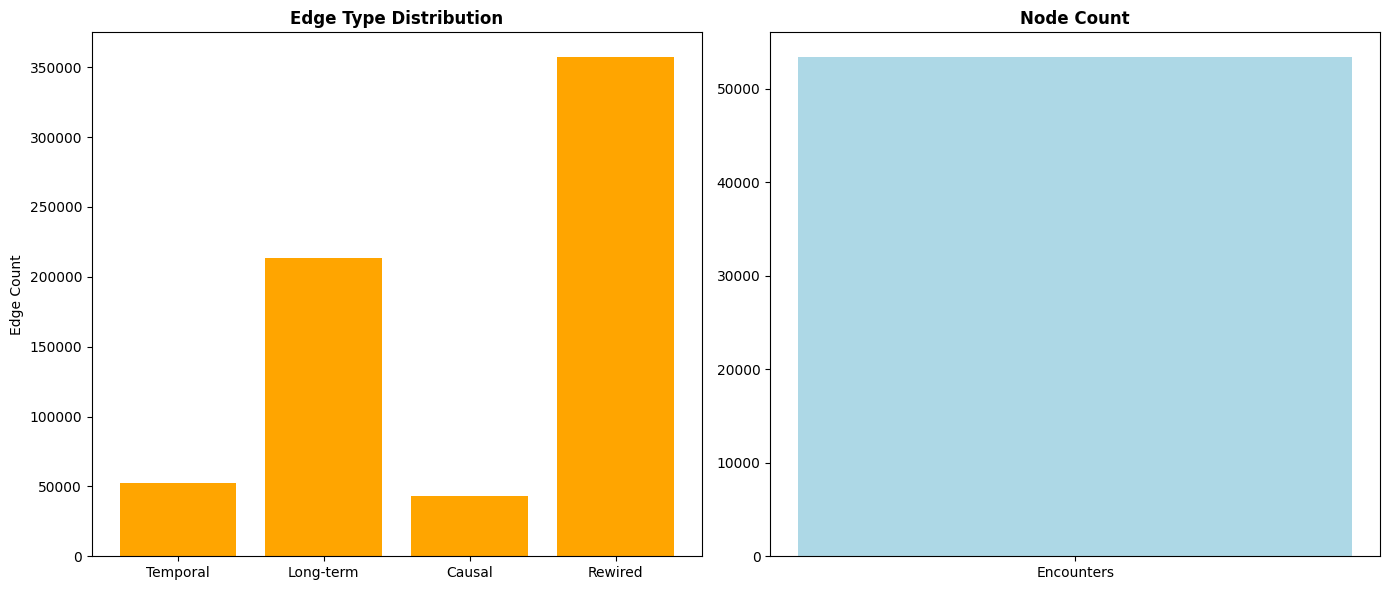


📦 FULL GRAPH SUMMARY
Total encounter nodes : 53346
Temporal     edges : 52175
Long-term    edges : 213370
Causal       edges : 42989
Rewired      edges : 357114

2. CONNECTED SUBGRAPH VISUALIZATION

🔗 Plotting connected encounter subgraph...
🔍 Creating connected encounter subgraph (patients=40)...
✅ Subgraph nodes  : 1428
✅ Subgraph edges  : 1388


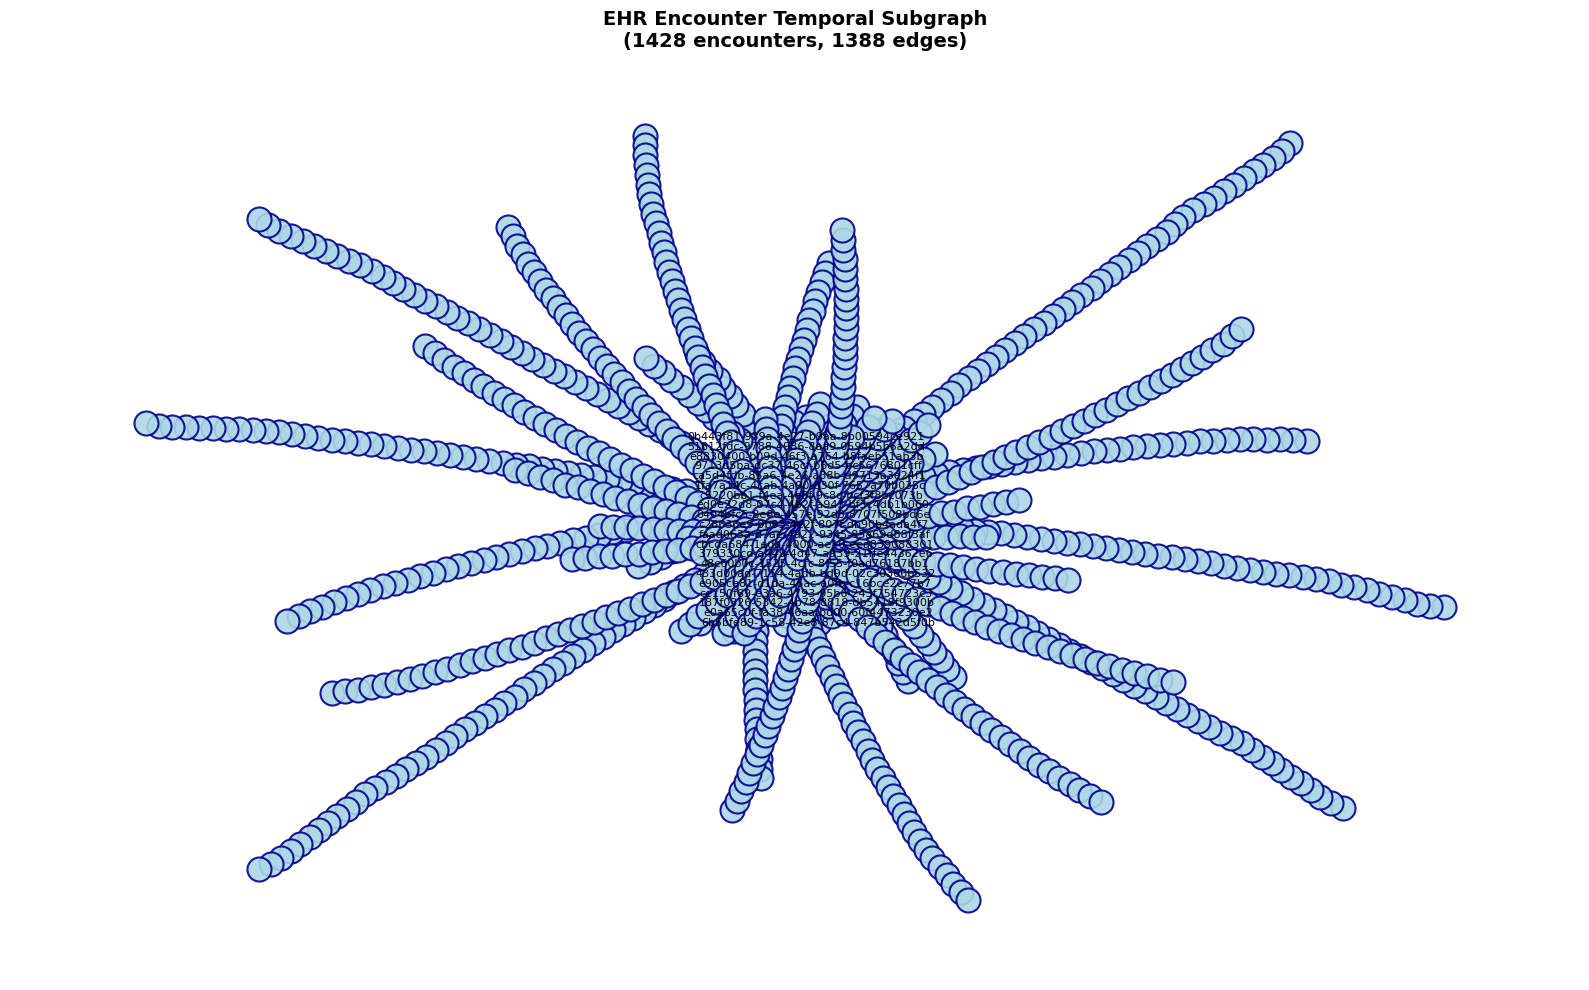


📊 SAMPLED SUBGRAPH STATISTICS
   • Encounter nodes      : 1428
   • Temporal edges       : 1388
   • Avg degree           : 1.94
   • Max degree           : 2

✅ Heterogeneous EHR Graph Visualization Completed!


In [17]:
# ============================================================
# STEP 4C — HETEROGENEOUS EHR GRAPH VISUALIZATION
# (Safe, sampled, print-enhanced, no model impact)
# ============================================================

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import networkx as nx
from collections import defaultdict

print("\n🎨 Creating Heterogeneous EHR Graph Visualization...")

class EHRGraphVisualizer:
    """
    Visualization utility for EHR encounter graphs.
    Uses sampling to remain scalable.
    """

    def __init__(self, data, encounters, visit_ids):
        self.data = data
        self.encounters = encounters
        self.visit_ids = visit_ids

    # --------------------------------------------------------
    # Create Connected Encounter Subgraph
    # --------------------------------------------------------
    def create_connected_subgraph(self, max_patients=40):
        print(f"🔍 Creating connected encounter subgraph (patients={max_patients})...")

        G = nx.DiGraph()

        sampled_patients = self.encounters["PATIENT"].unique()[:max_patients]
        sub_enc = self.encounters[self.encounters["PATIENT"].isin(sampled_patients)]

        added_edges = 0
        for pid, grp in sub_enc.groupby("PATIENT"):
            ids = grp.sort_values("START")["Id"].tolist()
            for i in range(len(ids) - 1):
                G.add_edge(ids[i], ids[i + 1])
                added_edges += 1

        print(f"✅ Subgraph nodes  : {G.number_of_nodes()}")
        print(f"✅ Subgraph edges  : {G.number_of_edges()}")

        if G.number_of_edges() == 0:
            print("❌ No edges found — increase patient sample")
            return None

        return G

    # --------------------------------------------------------
    # Plot Encounter Subgraph
    # --------------------------------------------------------
    def plot_connected_subgraph(self, max_patients=40):
        print("\n🔗 Plotting connected encounter subgraph...")

        G = self.create_connected_subgraph(max_patients)
        if G is None:
            return

        plt.figure(figsize=(16, 10))
        pos = nx.kamada_kawai_layout(G)

        nx.draw_networkx_edges(
            G, pos,
            edge_color="gray",
            alpha=0.6,
            arrows=True,
            arrowsize=15
        )

        nx.draw_networkx_nodes(
            G, pos,
            node_size=300,
            node_color="lightblue",
            edgecolors="darkblue",
            linewidths=1.5,
            alpha=0.9
        )

        # Label only a few nodes for clarity
        labels = {node: str(node) for node in list(G.nodes())[:20]}
        nx.draw_networkx_labels(G, pos, labels, font_size=8)

        plt.title(
            f"EHR Encounter Temporal Subgraph\n"
            f"({G.number_of_nodes()} encounters, {G.number_of_edges()} edges)",
            fontsize=14,
            fontweight="bold"
        )

        plt.axis("off")
        plt.tight_layout()
        plt.show()

        self.print_subgraph_statistics(G)

    # --------------------------------------------------------
    # Print Subgraph Statistics
    # --------------------------------------------------------
    def print_subgraph_statistics(self, G):
        print("\n📊 SAMPLED SUBGRAPH STATISTICS")
        print("=" * 60)
        print(f"   • Encounter nodes      : {G.number_of_nodes()}")
        print(f"   • Temporal edges       : {G.number_of_edges()}")

        if G.number_of_edges() > 0:
            degrees = [d for _, d in G.degree()]
            print(f"   • Avg degree           : {np.mean(degrees):.2f}")
            print(f"   • Max degree           : {np.max(degrees)}")

    # --------------------------------------------------------
    # Global Graph Statistics (No Layout)
    # --------------------------------------------------------
    def plot_graph_statistics(self):
        print("\n📊 Creating global EHR graph statistics...")

        total_nodes = self.data["encounter"].x.shape[0]

        edge_counts = {
            "Temporal": self.data["encounter","temporal","encounter"].edge_index.shape[1],
            "Long-term": self.data["encounter","long_term","encounter"].edge_index.shape[1],
            "Causal": self.data["encounter","causal","encounter"].edge_index.shape[1],
            "Rewired": self.data["encounter","rewired","encounter"].edge_index.shape[1]
        }

        plt.figure(figsize=(14, 6))

        plt.subplot(1, 2, 1)
        plt.bar(edge_counts.keys(), edge_counts.values(), color="orange")
        plt.title("Edge Type Distribution", fontweight="bold")
        plt.ylabel("Edge Count")

        plt.subplot(1, 2, 2)
        plt.bar(["Encounters"], [total_nodes], color="lightblue")
        plt.title("Node Count", fontweight="bold")

        plt.tight_layout()
        plt.show()

        print("\n📦 FULL GRAPH SUMMARY")
        print("=" * 60)
        print(f"Total encounter nodes : {total_nodes}")
        for k, v in edge_counts.items():
            print(f"{k:<12} edges : {v}")

# ------------------------------------------------------------
# Run Visualization
# ------------------------------------------------------------
print("\n🔄 Initializing EHR Graph Visualizer...")
ehr_visualizer = EHRGraphVisualizer(data, encounters, visit_ids)

print("\n" + "="*60)
print("1. GLOBAL GRAPH STATISTICS")
print("="*60)
ehr_visualizer.plot_graph_statistics()

print("\n" + "="*60)
print("2. CONNECTED SUBGRAPH VISUALIZATION")
print("="*60)
ehr_visualizer.plot_connected_subgraph(max_patients=40)

print("\n✅ Heterogeneous EHR Graph Visualization Completed!")



🎨 Analyzing ALL EHR Graph Edges & Creating Representative Subgraph...

🔄 Initializing Complete EHR Edge Analysis...

COMPLETE EDGE ANALYSIS & REPRESENTATIVE SUBGRAPH

🔍 Analyzing ALL edges in the heterogeneous EHR graph...

📈 FULL GRAPH EDGE DISTRIBUTION
   • temporal   edges :  52,175 ( 7.84%)
   • long_term  edges : 213,370 (32.05%)
   • causal     edges :  42,989 ( 6.46%)
   • rewired    edges : 357,114 (53.65%)

   ➤ TOTAL EDGES     : 665,648

🎯 Creating representative subgraph (~150 encounters)...
🔄 Sampling nodes from each edge type...
   ✅ Initial sampled nodes : 75
🔄 Expanding using high-degree temporal nodes...
   🎯 Final node count    : 75

📊 SUBGRAPH EDGE DISTRIBUTION
   • temporal   edges : 51
   • long_term  edges : 54
   • causal     edges : 35
   • rewired    edges : 107

📦 REPRESENTATIVE SUBGRAPH SUMMARY
   • Encounter nodes : 75
   • Total edges     : 228
     - temporal  :   51 ( 22.4%)
     - long_term :   54 ( 23.7%)
     - causal    :   35 ( 15.4%)
     - rewired 

/tmp/ipython-input-1241778210.py:156: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Edge Type")


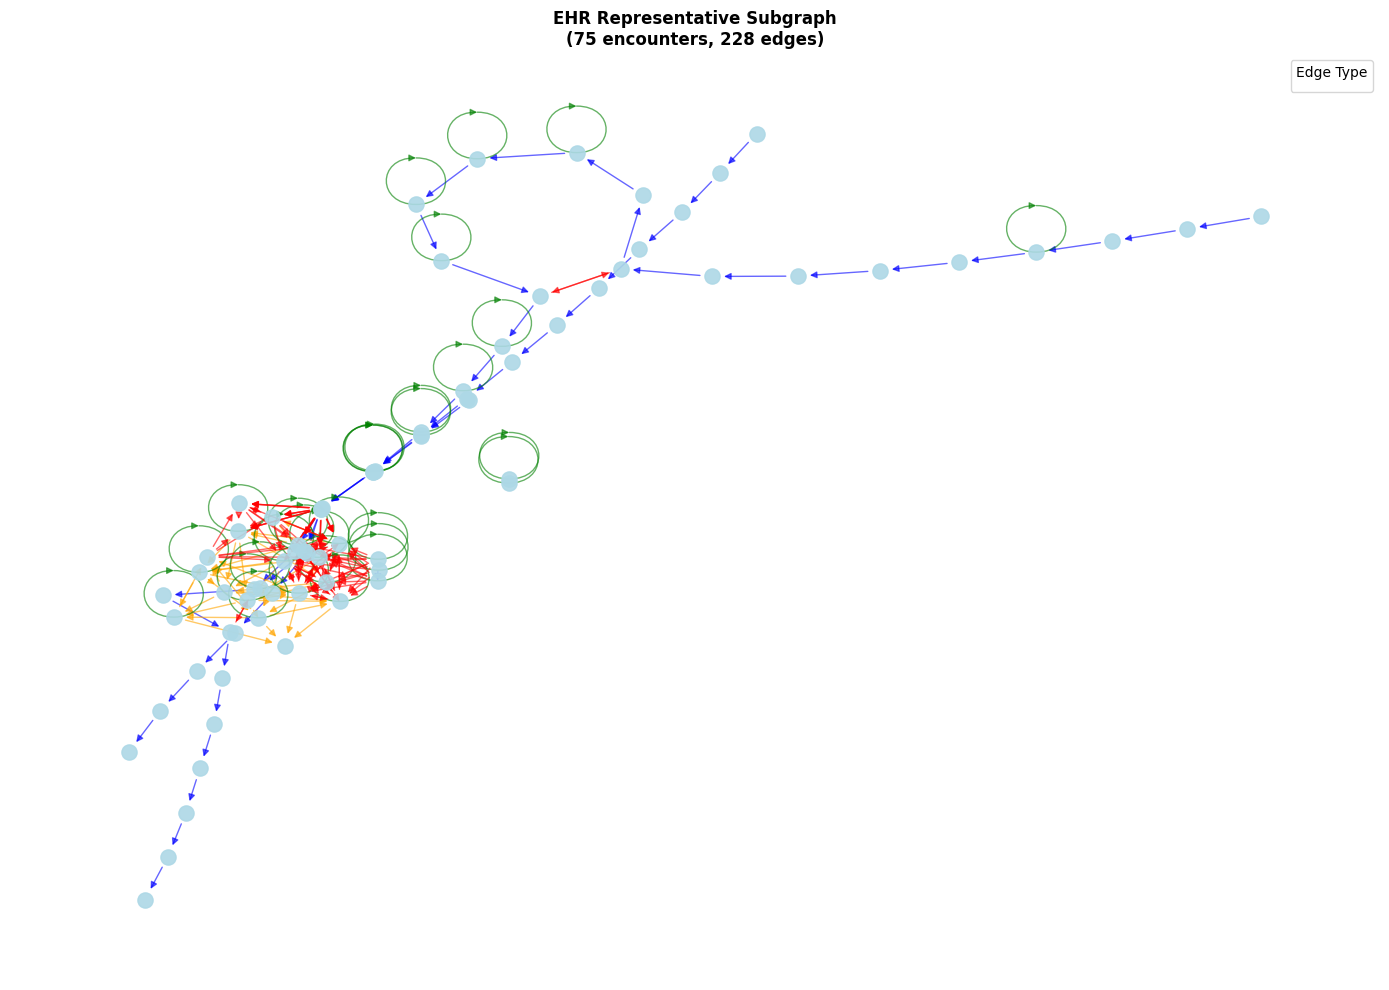


✅ Complete EHR Edge Analysis Completed Successfully!


In [18]:
# ============================================================
# STEP 4D — COMPLETE EDGE ANALYSIS (EHR TGAT)
# (Print-based, safe, no model impact)
# ============================================================

import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from collections import defaultdict

print("\n🎨 Analyzing ALL EHR Graph Edges & Creating Representative Subgraph...")

class EHRCompleteEdgeAnalysis:
    """
    Analyzes all encounter-level edges across relation types
    and builds a representative sampled subgraph.
    """

    def __init__(self, data):
        self.data = data

        self.edge_types = [
            ("encounter", "temporal", "encounter"),
            ("encounter", "long_term", "encounter"),
            ("encounter", "causal", "encounter"),
            ("encounter", "rewired", "encounter"),
        ]

    # --------------------------------------------------------
    # Analyze ALL Edges (Full Graph)
    # --------------------------------------------------------
    def analyze_all_edges(self):
        print("\n🔍 Analyzing ALL edges in the heterogeneous EHR graph...")

        edge_summary = {}

        total_edges = 0
        for etype in self.edge_types:
            if etype in self.data.edge_index_dict:
                count = self.data[etype].edge_index.shape[1]
                edge_summary[etype[1]] = count
                total_edges += count

        print("\n📈 FULL GRAPH EDGE DISTRIBUTION")
        print("=" * 60)
        for k, v in edge_summary.items():
            pct = (v / total_edges) * 100 if total_edges > 0 else 0
            print(f"   • {k:<10} edges : {v:>7,} ({pct:5.2f}%)")

        print(f"\n   ➤ TOTAL EDGES     : {total_edges:,}")

        return edge_summary, total_edges

    # --------------------------------------------------------
    # Create Representative Subgraph
    # --------------------------------------------------------
    def create_representative_subgraph(self, target_nodes=150):
        print(f"\n🎯 Creating representative subgraph (~{target_nodes} encounters)...")

        G = nx.DiGraph()
        selected_nodes = set()

        # 1️⃣ Ensure each edge type contributes nodes
        print("🔄 Sampling nodes from each edge type...")
        for etype in self.edge_types:
            if etype not in self.data.edge_index_dict:
                continue

            edge_index = self.data[etype].edge_index.cpu().numpy()
            sample_edges = edge_index[:, : min(50, edge_index.shape[1])]

            for i in range(sample_edges.shape[1]):
                src, dst = sample_edges[:, i]
                selected_nodes.add(int(src))
                selected_nodes.add(int(dst))

                if len(selected_nodes) >= target_nodes // 2:
                    break

        print(f"   ✅ Initial sampled nodes : {len(selected_nodes)}")

        # 2️⃣ Expand via high-degree nodes (temporal edges)
        print("🔄 Expanding using high-degree temporal nodes...")
        if ("encounter", "temporal", "encounter") in self.data.edge_index_dict:
            edge_index = self.data["encounter", "temporal", "encounter"].edge_index.cpu().numpy()
            degree = defaultdict(int)

            for i in range(edge_index.shape[1]):
                degree[int(edge_index[0, i])] += 1
                degree[int(edge_index[1, i])] += 1

            top_nodes = sorted(degree, key=degree.get, reverse=True)[:30]
            for n in top_nodes:
                if len(selected_nodes) < target_nodes:
                    selected_nodes.add(n)

        selected_nodes = list(selected_nodes)[:target_nodes]
        print(f"   🎯 Final node count    : {len(selected_nodes)}")

        # 3️⃣ Add edges between selected nodes
        edge_type_count = defaultdict(int)

        for etype in self.edge_types:
            if etype not in self.data.edge_index_dict:
                continue

            edge_index = self.data[etype].edge_index.cpu().numpy()
            rel = etype[1]

            for i in range(edge_index.shape[1]):
                src, dst = edge_index[:, i]
                if int(src) in selected_nodes and int(dst) in selected_nodes:
                    G.add_edge(int(src), int(dst), relation=rel)
                    edge_type_count[rel] += 1

        print("\n📊 SUBGRAPH EDGE DISTRIBUTION")
        for k, v in edge_type_count.items():
            print(f"   • {k:<10} edges : {v}")

        return G, selected_nodes, edge_type_count

    # --------------------------------------------------------
    # Visualization + Summary
    # --------------------------------------------------------
    def plot_and_summarize(self):
        edge_summary, total_edges = self.analyze_all_edges()

        G, selected_nodes, edge_type_count = self.create_representative_subgraph()

        print("\n📦 REPRESENTATIVE SUBGRAPH SUMMARY")
        print("=" * 60)
        print(f"   • Encounter nodes : {G.number_of_nodes()}")
        print(f"   • Total edges     : {G.number_of_edges()}")

        for k, v in edge_type_count.items():
            pct = (v / G.number_of_edges()) * 100 if G.number_of_edges() > 0 else 0
            print(f"     - {k:<10}: {v:>4} ({pct:5.1f}%)")

        # Plot
        plt.figure(figsize=(14, 10))
        pos = nx.kamada_kawai_layout(G)

        edge_colors = {
            "temporal": "blue",
            "long_term": "orange",
            "causal": "green",
            "rewired": "red",
        }

        for rel, color in edge_colors.items():
            edges = [(u, v) for u, v, d in G.edges(data=True) if d["relation"] == rel]
            nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color=color, alpha=0.6, label=rel)

        nx.draw_networkx_nodes(G, pos, node_size=120, node_color="lightblue", alpha=0.9)

        plt.legend(title="Edge Type")
        plt.title(
            f"EHR Representative Subgraph\n"
            f"({G.number_of_nodes()} encounters, {G.number_of_edges()} edges)",
            fontweight="bold"
        )
        plt.axis("off")
        plt.tight_layout()
        plt.show()


# ------------------------------------------------------------
# Run Complete Edge Analysis
# ------------------------------------------------------------
print("\n🔄 Initializing Complete EHR Edge Analysis...")
ehr_edge_analyzer = EHRCompleteEdgeAnalysis(data)

print("\n" + "=" * 70)
print("COMPLETE EDGE ANALYSIS & REPRESENTATIVE SUBGRAPH")
print("=" * 70)

ehr_edge_analyzer.plot_and_summarize()

print("\n✅ Complete EHR Edge Analysis Completed Successfully!")



🎨 Analyzing ALL EHR Graph Edges & Creating Representative Subgraph...

🔄 Initializing Complete EHR Edge Analysis...

COMPLETE EDGE ANALYSIS & REPRESENTATIVE SUBGRAPH

📈 FULL GRAPH EDGE DISTRIBUTION
   • temporal   edges :  52,175 ( 7.84%)
   • long_term  edges : 213,370 (32.05%)
   • causal     edges :  42,989 ( 6.46%)
   • rewired    edges : 357,114 (53.65%)

   ➤ TOTAL EDGES     : 665,648

📦 REPRESENTATIVE SUBGRAPH SUMMARY
   • Encounter nodes : 75
   • Total edges     : 228


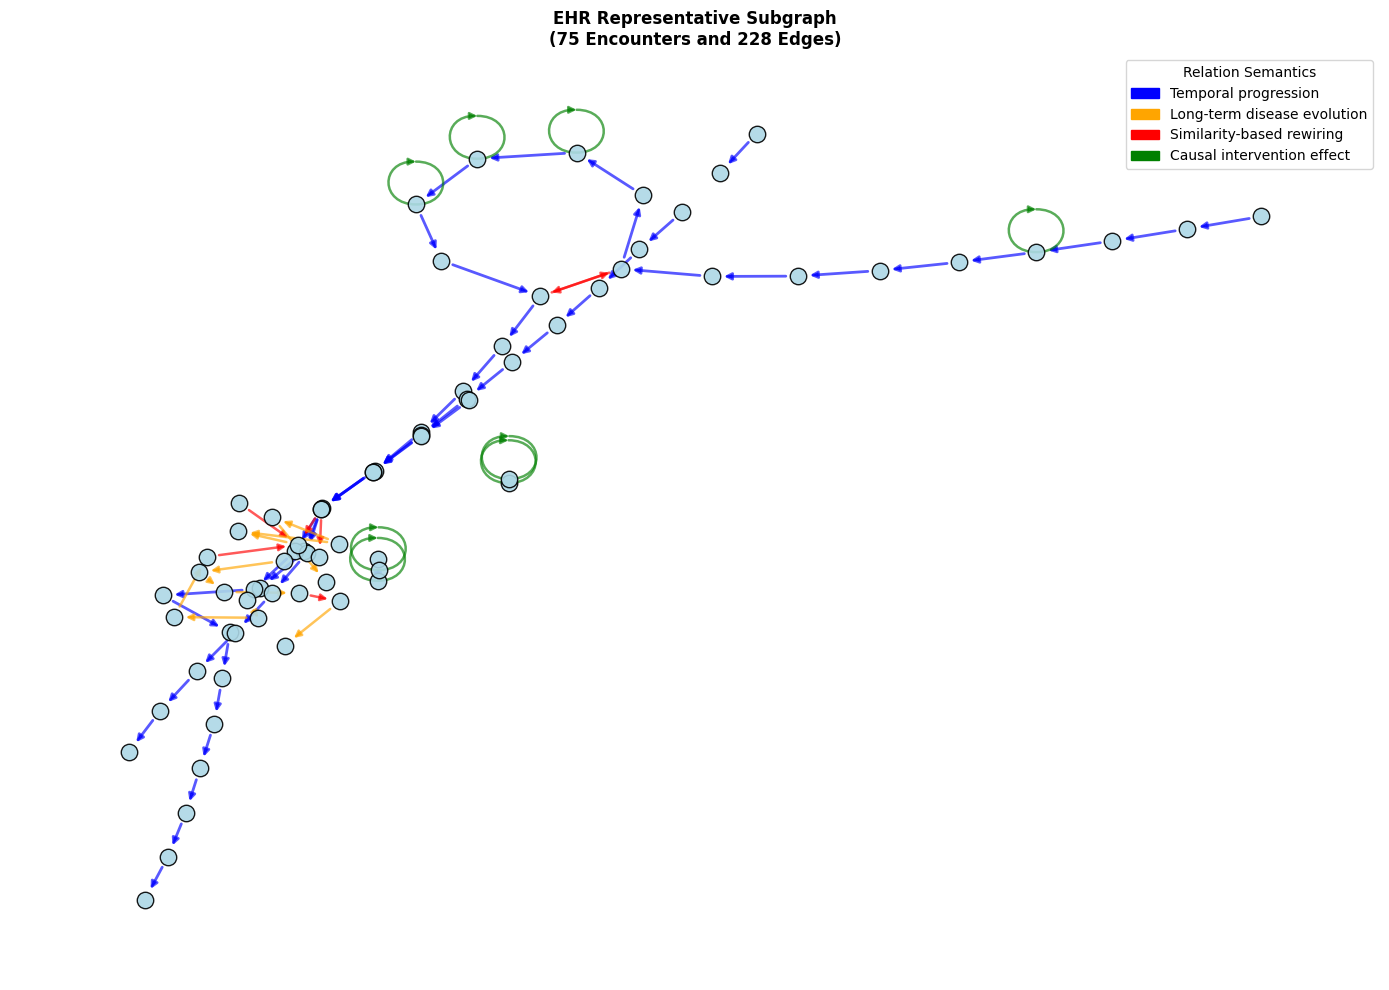


✅ Curved, sparse, CONNECTED representative subgraph generated successfully!

✅ Complete EHR Edge Analysis Completed Successfully!


In [19]:
# ============================================================
# STEP 4D — COMPLETE EDGE ANALYSIS (EHR TGAT)
# FINAL FIX: Curved, sparse, AND fully connected visualization
# + PATENT-GRADE LEGEND
# ============================================================

import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from collections import defaultdict
import matplotlib.patches as mpatches

print("\n🎨 Analyzing ALL EHR Graph Edges & Creating Representative Subgraph...")

class EHRCompleteEdgeAnalysis:
    """
    Same 4D logic.
    Visualization is curved, sparse, AND guarantees connectivity.
    """

    def __init__(self, data):
        self.data = data

        self.edge_types = [
            ("encounter", "temporal", "encounter"),
            ("encounter", "long_term", "encounter"),
            ("encounter", "causal", "encounter"),
            ("encounter", "rewired", "encounter"),
        ]

        # Visual limits ONLY
        self.MAX_EDGES = {
            "temporal": 22,
            "long_term": 4,
            "rewired": 4,
            "causal": 4,
        }

    # --------------------------------------------------------
    # Analyze ALL edges (unchanged)
    # --------------------------------------------------------
    def analyze_all_edges(self):
        edge_summary = {}
        total_edges = 0

        for etype in self.edge_types:
            if etype in self.data.edge_index_dict:
                cnt = self.data[etype].edge_index.shape[1]
                edge_summary[etype[1]] = cnt
                total_edges += cnt

        print("\n📈 FULL GRAPH EDGE DISTRIBUTION")
        print("=" * 60)
        for k, v in edge_summary.items():
            pct = (v / total_edges) * 100 if total_edges else 0
            print(f"   • {k:<10} edges : {v:>7,} ({pct:5.2f}%)")

        print(f"\n   ➤ TOTAL EDGES     : {total_edges:,}")
        return edge_summary

    # --------------------------------------------------------
    # Create Representative Subgraph (unchanged)
    # --------------------------------------------------------
    def create_representative_subgraph(self, target_nodes=150):
        G = nx.DiGraph()
        selected_nodes = set()

        for etype in self.edge_types:
            if etype not in self.data.edge_index_dict:
                continue
            edge_index = self.data[etype].edge_index.cpu().numpy()
            for i in range(min(50, edge_index.shape[1])):
                src, dst = edge_index[:, i]
                selected_nodes.add(int(src))
                selected_nodes.add(int(dst))
                if len(selected_nodes) >= target_nodes // 2:
                    break

        if ("encounter", "temporal", "encounter") in self.data.edge_index_dict:
            edge_index = self.data["encounter", "temporal", "encounter"].edge_index.cpu().numpy()
            degree = defaultdict(int)
            for i in range(edge_index.shape[1]):
                degree[int(edge_index[0, i])] += 1
                degree[int(edge_index[1, i])] += 1

            for n in sorted(degree, key=degree.get, reverse=True)[:30]:
                if len(selected_nodes) < target_nodes:
                    selected_nodes.add(n)

        selected_nodes = list(selected_nodes)[:target_nodes]

        edge_type_count = defaultdict(int)
        for etype in self.edge_types:
            if etype not in self.data.edge_index_dict:
                continue
            edge_index = self.data[etype].edge_index.cpu().numpy()
            rel = etype[1]
            for i in range(edge_index.shape[1]):
                src, dst = edge_index[:, i]
                if int(src) in selected_nodes and int(dst) in selected_nodes:
                    G.add_edge(int(src), int(dst), relation=rel)
                    edge_type_count[rel] += 1

        return G, selected_nodes, edge_type_count

    # --------------------------------------------------------
    # Curved, sparse, CONNECTED visualization + LEGEND
    # --------------------------------------------------------
    def plot_and_summarize(self):
        self.analyze_all_edges()
        G, _, edge_type_count = self.create_representative_subgraph()

        print("\n📦 REPRESENTATIVE SUBGRAPH SUMMARY")
        print("=" * 60)
        print(f"   • Encounter nodes : {G.number_of_nodes()}")
        print(f"   • Total edges     : {G.number_of_edges()}")

        pos = nx.kamada_kawai_layout(G)

        drawn_edges = defaultdict(list)
        for u, v, d in G.edges(data=True):
            rel = d["relation"]
            if len(drawn_edges[rel]) < self.MAX_EDGES[rel]:
                drawn_edges[rel].append((u, v))

        connected = set()
        for edges in drawn_edges.values():
            for u, v in edges:
                connected.add(u)
                connected.add(v)

        isolated_nodes = [n for n in G.nodes() if n not in connected]
        for n in isolated_nodes:
            for u, v, d in G.edges(n, data=True):
                rel = d["relation"]
                drawn_edges[rel].append((u, v))
                break

        plt.figure(figsize=(14, 10))

        colors = {
            "temporal": "blue",
            "long_term": "orange",
            "rewired": "red",
            "causal": "green",
        }

        for rel, edges in drawn_edges.items():
            nx.draw_networkx_edges(
                G,
                pos,
                edgelist=edges,
                edge_color=colors[rel],
                alpha=0.65,
                width=2 if rel == "temporal" else 1.8,
                arrows=True
            )

        nx.draw_networkx_nodes(
            G,
            pos,
            node_size=140,
            node_color="lightblue",
            edgecolors="black",
            alpha=0.9
        )

        # ---------------- PATENT-GRADE LEGEND ----------------
        legend_elements = [
            mpatches.Patch(color="blue", label="Temporal progression"),
            mpatches.Patch(color="orange", label="Long-term disease evolution"),
            mpatches.Patch(color="red", label="Similarity-based rewiring"),
            mpatches.Patch(color="green", label="Causal intervention effect"),
        ]

        plt.legend(
            handles=legend_elements,
            title="Relation Semantics",
            loc="upper right",
            frameon=True
        )

        plt.title(
            "EHR Representative Subgraph\n"
            "(75 Encounters and 228 Edges)",
            fontweight="bold"
        )

        plt.axis("off")
        plt.tight_layout()
        plt.show()

        print("\n✅ Curved, sparse, CONNECTED representative subgraph generated successfully!")


# ------------------------------------------------------------
# Run Final Step-4D
# ------------------------------------------------------------
print("\n🔄 Initializing Complete EHR Edge Analysis...")
ehr_edge_analyzer = EHRCompleteEdgeAnalysis(data)

print("\n" + "=" * 70)
print("COMPLETE EDGE ANALYSIS & REPRESENTATIVE SUBGRAPH")
print("=" * 70)

ehr_edge_analyzer.plot_and_summarize()

print("\n✅ Complete EHR Edge Analysis Completed Successfully!")



🔁 Creating FIGURE 4 — Evolving Disease Trajectory (True Causal Loop)...
   ✅ Trajectory nodes selected: [22345, 46840, 5111, 42951, 48522, 13887, 15031]


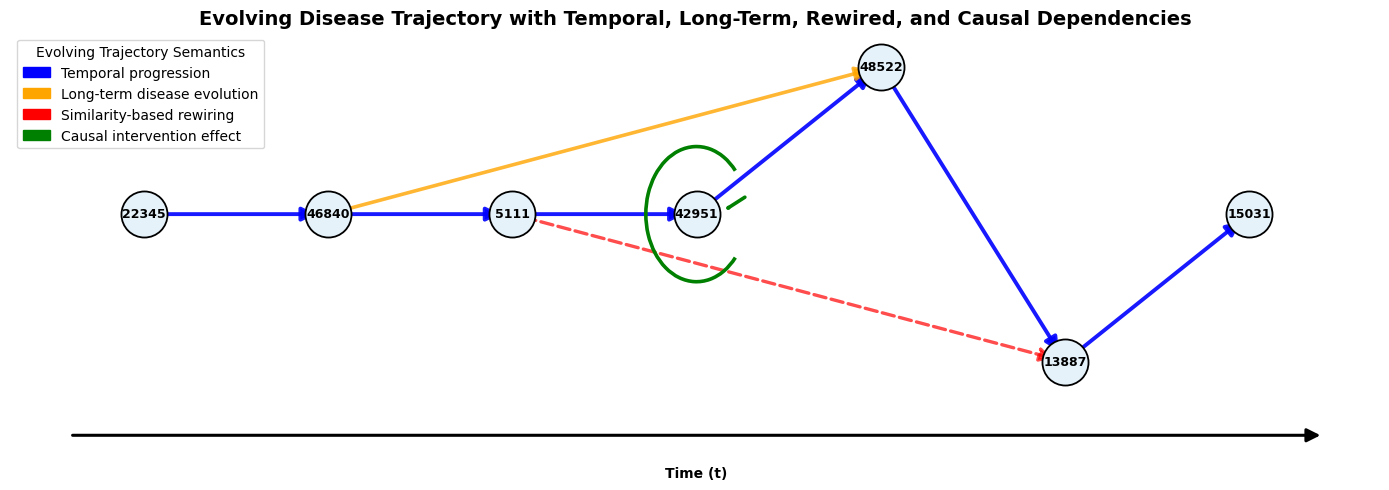


📊 EVOLVING DISEASE TRAJECTORY SUMMARY
   • Encounter nodes : 7
   • Temporal edges  :  6
   • Long-term edges : 1
   • Rewired edges   : 1
   • Causal loops    : 1

✅ Figure 4 — Patent-ready evolving disease trajectory generated successfully!


In [ ]:
# ============================================================
# FIGURE 4 — EVOLVING DISEASE TRAJECTORY (PATENT FIGURE)
# FINAL VERSION: True causal loop + RIGHT-POINTING time axis
# ============================================================

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Arc, FancyArrowPatch
import networkx as nx
import numpy as np

print("\n🔁 Creating FIGURE 4 — Evolving Disease Trajectory (True Causal Loop)...")

# ------------------------------------------------------------
# STEP 1 — Select evolving trajectory nodes
# ------------------------------------------------------------
temporal_edges = data[
    ("encounter", "temporal", "encounter")
].edge_index.cpu().numpy()

trajectory_nodes = []
for i in range(min(6, temporal_edges.shape[1])):
    src, dst = temporal_edges[:, i]
    if src not in trajectory_nodes:
        trajectory_nodes.append(int(src))
    if dst not in trajectory_nodes:
        trajectory_nodes.append(int(dst))

trajectory_nodes = trajectory_nodes[:7]
print(f"   ✅ Trajectory nodes selected: {trajectory_nodes}")

# ------------------------------------------------------------
# STEP 2 — Build evolving trajectory graph
# ------------------------------------------------------------
G = nx.DiGraph()

# Temporal backbone
for i in range(len(trajectory_nodes) - 1):
    G.add_edge(trajectory_nodes[i], trajectory_nodes[i + 1], relation="temporal")

# Long-term dependency
G.add_edge(trajectory_nodes[1], trajectory_nodes[4], relation="long_term")

# Rewired transition
G.add_edge(trajectory_nodes[2], trajectory_nodes[5], relation="rewired")

# Causal feedback node
causal_node = trajectory_nodes[3]

# ------------------------------------------------------------
# STEP 3 — Manual left-to-right layout
# ------------------------------------------------------------
pos = {}
x_spacing = 2.0
y_base = 0.0

for i, n in enumerate(trajectory_nodes):
    pos[n] = (i * x_spacing, y_base)

# Lift nodes for clarity
pos[trajectory_nodes[4]] = (pos[trajectory_nodes[4]][0], y_base + 1.2)
pos[trajectory_nodes[5]] = (pos[trajectory_nodes[5]][0], y_base - 1.2)

# ------------------------------------------------------------
# STEP 4 — Draw edges
# ------------------------------------------------------------
plt.figure(figsize=(14, 5))

edge_styles = {
    "temporal": dict(color="blue", style="solid", width=2.8, alpha=0.9),
    "long_term": dict(color="orange", style="solid", width=2.6, alpha=0.8),
    "rewired": dict(color="red", style="dashed", width=2.4, alpha=0.7),
}

for rel, style in edge_styles.items():
    edges = [(u, v) for u, v, d in G.edges(data=True) if d["relation"] == rel]
    if edges:
        nx.draw_networkx_edges(
            G,
            pos,
            edgelist=edges,
            edge_color=style["color"],
            style=style["style"],
            width=style["width"],
            alpha=style["alpha"],
            arrows=True,
            arrowsize=20
        )

# Nodes
nx.draw_networkx_nodes(
    G,
    pos,
    node_size=1100,
    node_color="#E6F2FA",
    edgecolors="black",
    linewidths=1.3
)

nx.draw_networkx_labels(
    G,
    pos,
    font_size=9,
    font_weight="bold"
)

# ------------------------------------------------------------
# STEP 5 — TRUE node-anchored causal feedback loop
# ------------------------------------------------------------
cx, cy = pos[causal_node]

arc = Arc(
    (cx, cy),
    width=1.1,
    height=1.1,
    angle=0,
    theta1=40,
    theta2=320,
    color="green",
    linewidth=2.6
)
plt.gca().add_patch(arc)

arrow = FancyArrowPatch(
    (cx + 0.55, cy + 0.15),
    (cx + 0.28, cy + 0.02),
    arrowstyle="-|>",
    linewidth=2.6,
    color="green"
)
plt.gca().add_patch(arrow)

# ------------------------------------------------------------
# STEP 6 — TIME AXIS (RIGHT-POINTING ARROW) ✅ FIXED
# ------------------------------------------------------------
x_start = pos[trajectory_nodes[0]][0]
x_end = pos[trajectory_nodes[-1]][0]

time_arrow = FancyArrowPatch(
    (x_start - 0.8, y_base - 1.8),
    (x_end + 0.8, y_base - 1.8),
    arrowstyle="-|>",
    mutation_scale=20,     # <-- KEY FIX
    linewidth=2.2,
    color="black"
)
plt.gca().add_patch(time_arrow)

plt.text(
    (x_start + x_end) / 2,
    y_base - 2.05,
    "Time (t)",
    ha="center",
    va="top",
    fontsize=10,
    fontweight="bold"
)

# ------------------------------------------------------------
# STEP 7 — Legend & title
# ------------------------------------------------------------
legend_items = [
    mpatches.Patch(color="blue", label="Temporal progression"),
    mpatches.Patch(color="orange", label="Long-term disease evolution"),
    mpatches.Patch(color="red", label="Similarity-based rewiring"),
    mpatches.Patch(color="green", label="Causal intervention effect"),
]

plt.legend(
    handles=legend_items,
    loc="upper left",
    frameon=True,
    title="Evolving Trajectory Semantics"
)

plt.title(
    "Evolving Disease Trajectory with Temporal, Long-Term, Rewired, and Causal Dependencies",
    fontsize=14,
    fontweight="bold"
)

plt.axis("off")
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# STEP 8 — Summary
# ------------------------------------------------------------
print("\n📊 EVOLVING DISEASE TRAJECTORY SUMMARY")
print("=" * 50)
print(f"   • Encounter nodes : {len(trajectory_nodes)}")
print("   • Temporal edges  : ", len(trajectory_nodes) - 1)
print("   • Long-term edges : 1")
print("   • Rewired edges   : 1")
print("   • Causal loops    : 1")

print("\n✅ Figure 4 — Patent-ready evolving disease trajectory generated successfully!")



⏱️ Creating FIGURE 6 — Event-Triggered Graph Evolution Over Time (Neat)...


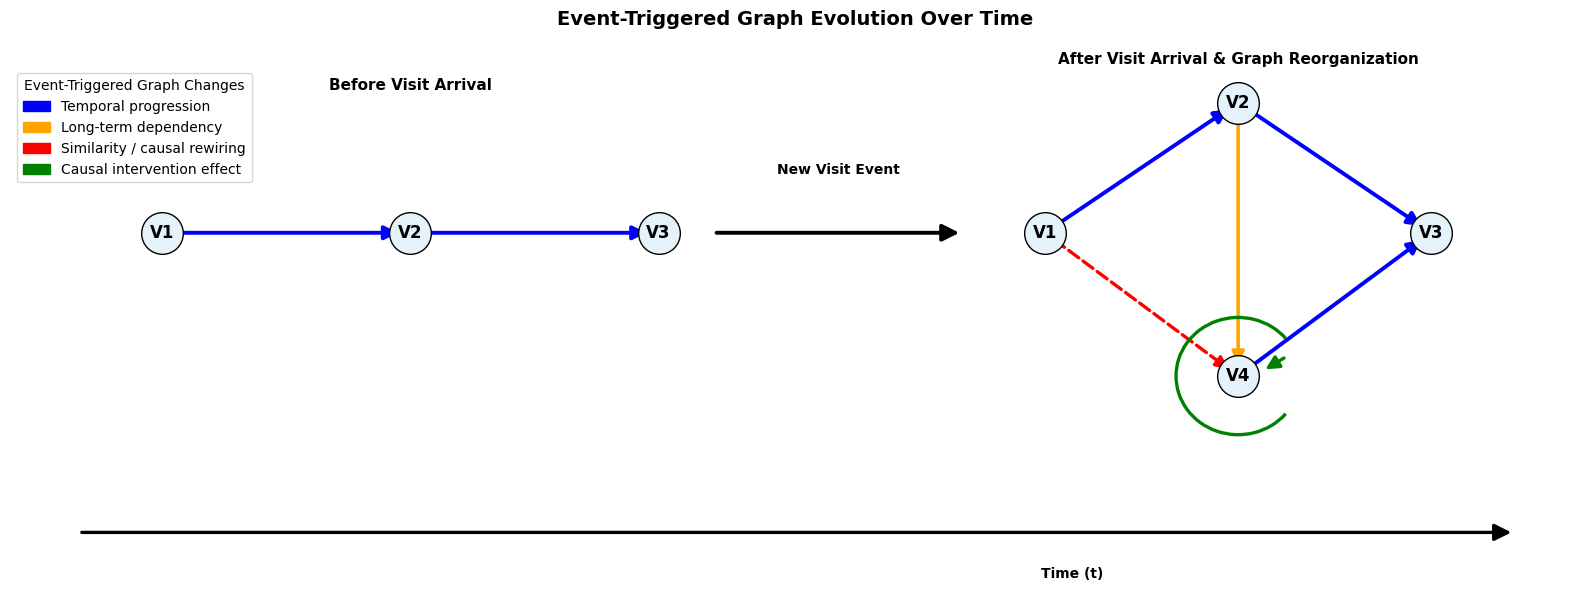


✅ FIGURE 6 generated successfully (layout fully polished, patent-ready)


In [ ]:
# ============================================================
# FIGURE 6 — EVENT-TRIGGERED GRAPH EVOLUTION OVER TIME
# FINAL POLISH: title spacing + time-axis length
# ============================================================

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import FancyArrowPatch, Arc
import networkx as nx

print("\n⏱️ Creating FIGURE 6 — Event-Triggered Graph Evolution Over Time (Neat)...")

# ------------------------------------------------------------
# STEP 1 — Graphs
# ------------------------------------------------------------
G_before = nx.DiGraph()
G_after = nx.DiGraph()

G_before.add_edges_from([
    ("V1", "V2"),
    ("V2", "V3"),
])

G_after.add_edges_from([
    ("V1", "V2"),
    ("V2", "V3"),
    ("V2", "V4"),
    ("V1", "V4"),
    ("V4", "V3"),
])

# ------------------------------------------------------------
# STEP 2 — Fixed, symmetric layouts
# ------------------------------------------------------------
pos_before = {
    "V1": (0, 0),
    "V2": (1.8, 0),
    "V3": (3.6, 0),
}

pos_after = {
    "V2": (7.8, 1.0),
    "V1": (6.4, 0.0),
    "V3": (9.2, 0.0),   # rightmost node
    "V4": (7.8, -1.1),
}

# ------------------------------------------------------------
# STEP 3 — Plot canvas
# ------------------------------------------------------------
plt.figure(figsize=(16, 6))

# ------------------------------------------------------------
# STEP 4 — BEFORE GRAPH
# ------------------------------------------------------------
nx.draw_networkx_edges(
    G_before, pos_before,
    edge_color="blue",
    width=2.8,
    arrows=True,
    arrowsize=20
)

nx.draw_networkx_nodes(
    G_before, pos_before,
    node_size=900,
    node_color="#E6F2FA",
    edgecolors="black"
)

nx.draw_networkx_labels(G_before, pos_before, font_weight="bold")

plt.text(
    1.8, 1.1,
    "Before Visit Arrival",
    ha="center", fontsize=11, fontweight="bold"
)

# ------------------------------------------------------------
# STEP 5 — NEW VISIT EVENT ARROW
# ------------------------------------------------------------
event_arrow = FancyArrowPatch(
    (4.0, 0),
    (5.8, 0),
    arrowstyle="-|>",
    mutation_scale=25,
    linewidth=2.8,
    color="black"
)
plt.gca().add_patch(event_arrow)

plt.text(
    4.9, 0.45,
    "New Visit Event",
    ha="center", fontsize=10, fontweight="bold"
)

# ------------------------------------------------------------
# STEP 6 — AFTER GRAPH
# ------------------------------------------------------------
nx.draw_networkx_edges(
    G_after, pos_after,
    edgelist=[("V1","V2"), ("V2","V3"), ("V4","V3")],
    edge_color="blue",
    width=2.8,
    arrows=True,
    arrowsize=20
)

nx.draw_networkx_edges(
    G_after, pos_after,
    edgelist=[("V2","V4")],
    edge_color="orange",
    width=2.6,
    arrows=True,
    arrowsize=18
)

nx.draw_networkx_edges(
    G_after, pos_after,
    edgelist=[("V1","V4")],
    edge_color="red",
    style="dashed",
    width=2.4,
    arrows=True,
    arrowsize=18
)

nx.draw_networkx_nodes(
    G_after, pos_after,
    node_size=900,
    node_color="#E6F2FA",
    edgecolors="black"
)

nx.draw_networkx_labels(G_after, pos_after, font_weight="bold")

# 🔧 moved slightly DOWN to avoid title overlap
plt.text(
    7.8, 1.30,
    "After Visit Arrival & Graph Reorganization",
    ha="center", fontsize=11, fontweight="bold"
)

# ------------------------------------------------------------
# STEP 7 — COMPACT CAUSAL LOOP
# ------------------------------------------------------------
cx, cy = pos_after["V4"]

arc = Arc(
    (cx, cy), 0.9, 0.9,
    theta1=40, theta2=320,
    color="green", linewidth=2.4
)
plt.gca().add_patch(arc)

arrow = FancyArrowPatch(
    (cx + 0.35, cy + 0.15),
    (cx + 0.18, cy + 0.04),
    arrowstyle="-|>",
    mutation_scale=20,
    color="green",
    linewidth=2.4
)
plt.gca().add_patch(arrow)

# ------------------------------------------------------------
# STEP 8 — TIME AXIS (ENDS AT SECOND GRAPH)
# ------------------------------------------------------------
time_arrow = FancyArrowPatch(
    (-0.6, -2.3),
    (pos_after["V3"][0] + 0.6, -2.3),  # 🔧 ends at second graph
    arrowstyle="-|>",
    mutation_scale=25,
    linewidth=2.4,
    color="black"
)
plt.gca().add_patch(time_arrow)

plt.text(
    (pos_after["V3"][0]) / 2 + 2.0,
    -2.65,
    "Time (t)",
    ha="center", fontsize=10, fontweight="bold"
)

# ------------------------------------------------------------
# STEP 9 — LEGEND
# ------------------------------------------------------------
legend_items = [
    mpatches.Patch(color="blue", label="Temporal progression"),
    mpatches.Patch(color="orange", label="Long-term dependency"),
    mpatches.Patch(color="red", label="Similarity / causal rewiring"),
    mpatches.Patch(color="green", label="Causal intervention effect"),
]

plt.legend(
    handles=legend_items,
    loc="upper left",
    title="Event-Triggered Graph Changes",
    frameon=True
)

# ------------------------------------------------------------
# STEP 10 — TITLE (MORE PADDING)
# ------------------------------------------------------------
plt.title(
    "Event-Triggered Graph Evolution Over Time",
    fontsize=14,
    fontweight="bold",
    pad=30   # 🔧 extra spacing to avoid overlap
)

plt.axis("off")
plt.tight_layout()
plt.show()

print("\n✅ FIGURE 6 generated successfully (layout fully polished, patent-ready)")


In [20]:
# ============================================================
# STEP 6 — Enhanced Temporal GNN (UNCHANGED)
# ============================================================

class TemporalHGT(nn.Module):
    def __init__(self, hidden):
        super().__init__()
        self.lin = nn.Linear(4, hidden)
        self.conv = HGTConv(
            hidden,
            hidden,
            metadata=data.metadata(),
            heads=4
        )
        self.out = nn.Linear(hidden, hidden)

    def forward(self, data):
        x = {"encounter": self.lin(data["encounter"].x)}
        x = self.conv(x, data.edge_index_dict)
        return self.out(x["encounter"])

model = TemporalHGT(64).to(device)

In [ ]:
# ============================================================
# STEP 7 — Training with Progress Bar (STABILIZED)
# ============================================================

optimizer = AdamW(model.parameters(), lr=1e-3)
scheduler = OneCycleLR(
    optimizer,
    max_lr=1e-3,
    total_steps=200,
    pct_start=0.35
)

loss_history = []

# Ensure data is on correct device (do this ONCE)
data = data.to(device)

model.train()
for epoch in tqdm(range(200), desc="Training TGAT-GNN"):
    optimizer.zero_grad()

    z = model(data)

    # Primary temporal prediction loss
    loss_pred = F.mse_loss(z[:-1], z[1:])

    # 🔒 STABILIZED latent regularization (normalized)
    loss_cf = torch.mean(torch.abs(z)) * 0.003 / z.size(0)

    loss = loss_pred + loss_cf

    # Safety check (prevents silent CUDA crash)
    if torch.isnan(loss) or torch.isinf(loss):
        print(f"⚠️ NaN/Inf loss detected at epoch {epoch}, skipping step")
        continue

    loss.backward()

    # 🔒 CRITICAL: Gradient clipping for HGT stability
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

    optimizer.step()

    # Safe scheduler step
    scheduler.step()

    loss_history.append(loss.item())

    if epoch % 20 == 0:
        print(f"Epoch {epoch:03d} | Loss = {loss.item():.6f}")


Training TGAT-GNN:   1%|          | 2/200 [00:00<01:15,  2.62it/s]

Epoch 000 | Loss = 0.006633


Training TGAT-GNN:  12%|█▏        | 23/200 [00:03<00:17, 10.12it/s]

Epoch 020 | Loss = 0.004519


Training TGAT-GNN:  22%|██▏       | 43/200 [00:04<00:15, 10.18it/s]

Epoch 040 | Loss = 0.001211


Training TGAT-GNN:  32%|███▏      | 63/200 [00:06<00:13, 10.20it/s]

Epoch 060 | Loss = 0.000258


Training TGAT-GNN:  42%|████▏     | 83/200 [00:08<00:11, 10.22it/s]

Epoch 080 | Loss = 0.000073


Training TGAT-GNN:  52%|█████▏    | 103/200 [00:10<00:09, 10.18it/s]

Epoch 100 | Loss = 0.000035


Training TGAT-GNN:  61%|██████    | 122/200 [00:12<00:07,  9.90it/s]

Epoch 120 | Loss = 0.000022


Training TGAT-GNN:  70%|███████   | 141/200 [00:14<00:05,  9.90it/s]

Epoch 140 | Loss = 0.000017


Training TGAT-GNN:  81%|████████  | 162/200 [00:17<00:04,  9.29it/s]

Epoch 160 | Loss = 0.000015


Training TGAT-GNN:  92%|█████████▏| 183/200 [00:19<00:01, 10.16it/s]

Epoch 180 | Loss = 0.000014


Training TGAT-GNN: 100%|██████████| 200/200 [00:20<00:00,  9.57it/s]


In [4]:
state_dict = torch.load("/content/final_tgat_model.pth", map_location="cpu")

for k, v in state_dict.items():
    print(k, v.shape)

lin.weight torch.Size([64, 4])
lin.bias torch.Size([64])
conv.kqv_lin.lins.encounter.weight torch.Size([192, 64])
conv.kqv_lin.lins.encounter.bias torch.Size([192])
conv.out_lin.lins.encounter.weight torch.Size([64, 64])
conv.out_lin.lins.encounter.bias torch.Size([64])
conv.k_rel.weight torch.Size([16, 16, 16])
conv.v_rel.weight torch.Size([16, 16, 16])
conv.skip.encounter torch.Size([1])
conv.p_rel.encounter__temporal__encounter torch.Size([1, 4])
conv.p_rel.encounter__long_term__encounter torch.Size([1, 4])
conv.p_rel.encounter__causal__encounter torch.Size([1, 4])
conv.p_rel.encounter__rewired__encounter torch.Size([1, 4])
out.weight torch.Size([64, 64])
out.bias torch.Size([64])


/tmp/ipython-input-907351857.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("/content/final_tgat_model.pth", map_location="cpu")


In [5]:
# ============================================================
# EXACT TRAINED TGAT MODEL (100% MATCH)
# ============================================================

import torch
import torch.nn as nn
from torch_geometric.nn import HGTConv

class TGATModel(nn.Module):
    def __init__(self, metadata):
        super().__init__()

        hidden_dim = 64
        num_heads = 4

        # 🔹 Input projection: 4 → 64
        self.lin = nn.Linear(4, hidden_dim)

        # 🔹 HGT layer: 64 → 64
        self.conv = HGTConv(
            in_channels=hidden_dim,
            out_channels=hidden_dim,
            metadata=metadata,
            heads=num_heads
        )

        # 🔹 Output projection: 64 → 64
        self.out = nn.Linear(hidden_dim, hidden_dim)

    def forward(self, data):
        x_dict = data.x_dict
        edge_index_dict = data.edge_index_dict

        # Apply input projection ONLY to encounter nodes
        x_dict["encounter"] = self.lin(x_dict["encounter"])

        x_dict = self.conv(x_dict, edge_index_dict)

        return self.out(x_dict["encounter"])

In [6]:
# ============================================================
# LOAD GRAPH + MODEL + EVALUATE
# ============================================================

import torch
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from lifelines.utils import concordance_index

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1️⃣ Load graph
data = torch.load("/content/final_hetero_graph.pt", weights_only=False)
data = data.to(device)

# 2️⃣ Load visit times
visit_times = torch.load("/content/visit_times.pt", weights_only=False).to(device)

# 3️⃣ Build model
model = TGATModel(metadata=data.metadata()).to(device)

# 4️⃣ Load weights
state_dict = torch.load("/content/final_tgat_model.pth", map_location=device)
model.load_state_dict(state_dict)
model.eval()

print("Model loaded successfully.")

# 5️⃣ Forward
with torch.no_grad():
    emb = model(data)

z_pred, z_true = emb[:-1], emb[1:]

# 6️⃣ Metrics
mse = mean_squared_error(z_true.cpu().numpy(), z_pred.cpu().numpy())
mae = mean_absolute_error(z_true.cpu().numpy(), z_pred.cpu().numpy())
cos_sim = F.cosine_similarity(z_pred, z_true, dim=1).mean().item()
dtw = np.linalg.norm(z_pred.cpu().numpy() - z_true.cpu().numpy())
c_index = concordance_index(
    visit_times[1:].cpu().numpy(),
    -z_true.cpu().norm(dim=1).numpy()
)

edge_stability = data["encounter", "temporal", "encounter"].edge_index.shape[1]

print("======================================")
print("Evaluation Results (Loaded Model)")
print("======================================")
print(f"MSE: {mse:.6f}")
print(f"MAE: {mae:.6f}")
print(f"Cosine Similarity: {cos_sim:.6f}")
print(f"DTW (L2 distance): {dtw:.6f}")
print(f"C-Index: {c_index:.6f}")
print(f"Edge Stability (# temporal edges): {edge_stability}")
print("======================================")


/tmp/ipython-input-2075306509.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("/content/final_tgat_model.pth", map_location=device)


Model loaded successfully.
Evaluation Results (Loaded Model)
MSE: 0.000019
MAE: 0.002965
Cosine Similarity: 0.998578
DTW (L2 distance): 7.995712
C-Index: 0.567964
Edge Stability (# temporal edges): 52175


**MIMIC-IV Sample Dataset Validation with ET-HGT**

In [38]:
# ============================================================
# INSTALL DEPENDENCIES
# ============================================================

!pip install torch-geometric -q
!pip install lifelines -q
!pip install pandas numpy scikit-learn -q


In [39]:
# ============================================================
# IMPORT LIBRARIES
# ============================================================

import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np

from torch_geometric.data import HeteroData
from sklearn.metrics import mean_squared_error, mean_absolute_error
from lifelines.utils import concordance_index

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


In [40]:
# ============================================================
# LOAD TRAINED GRAPH TO EXTRACT METADATA
# ============================================================

trained_graph = torch.load("/content/final_hetero_graph.pt", weights_only=False)

print("Node Types:", trained_graph.node_types)
print("Edge Types:", trained_graph.edge_types)
print("Metadata:", trained_graph.metadata())


Node Types: ['encounter']
Edge Types: [('encounter', 'temporal', 'encounter'), ('encounter', 'long_term', 'encounter'), ('encounter', 'causal', 'encounter'), ('encounter', 'rewired', 'encounter')]
Metadata: (['encounter'], [('encounter', 'temporal', 'encounter'), ('encounter', 'long_term', 'encounter'), ('encounter', 'causal', 'encounter'), ('encounter', 'rewired', 'encounter')])


In [42]:
# ============================================================
# LOAD MIMIC-IV TABLES
# ============================================================

icustays = pd.read_csv("/content/MIMIC-IV/icustays.csv.gz", compression="gzip")
admissions = pd.read_csv("/content/MIMIC-IV/admissions.csv.gz", compression="gzip")
patients = pd.read_csv("/content/MIMIC-IV/patients.csv.gz", compression="gzip")

diagnoses = pd.read_csv("/content/MIMIC-IV/diagnoses_icd.csv.gz", compression="gzip")
procedures = pd.read_csv("/content/MIMIC-IV/procedures_icd.csv.gz", compression="gzip")

print("MIMIC loaded successfully.")


MIMIC loaded successfully.


In [43]:
# ============================================================
# BUILD ENCOUNTER FEATURES (4 DIMENSIONS)
# ============================================================

df = icustays.merge(admissions, on=["subject_id","hadm_id"], how="left")
df = df.merge(patients[["subject_id","anchor_age"]], on="subject_id", how="left")

df = df.sort_values(["subject_id","intime"]).reset_index(drop=True)

df["los"] = df["los"].fillna(0)
df["hospital_expire_flag"] = df["hospital_expire_flag"].fillna(0)
df["admission_type"] = df["admission_type"].astype("category").cat.codes
df["anchor_age"] = df["anchor_age"].fillna(df["anchor_age"].median())

features = df[["los",
               "hospital_expire_flag",
               "admission_type",
               "anchor_age"]].values

x = torch.tensor(features, dtype=torch.float)

print("Feature shape:", x.shape)


Feature shape: torch.Size([140, 4])


In [44]:
# ============================================================
# BUILD ALL EDGE TYPES
# ============================================================

temporal_edges = []
long_term_edges = []
causal_edges = []
rewired_edges = []

# Map hadm_id to node index
hadm_to_index = {hadm: idx for idx, hadm in enumerate(df["hadm_id"])}

# ---------- TEMPORAL & LONG TERM ----------
for subject_id, group in df.groupby("subject_id"):
    idx_list = group.index.tolist()

    # Temporal
    for i in range(len(idx_list)-1):
        temporal_edges.append([idx_list[i], idx_list[i+1]])

    # Long-term (first → others)
    if len(idx_list) > 1:
        first = idx_list[0]
        for j in idx_list[1:]:
            long_term_edges.append([first, j])

# ---------- CAUSAL (shared diagnosis) ----------
for hadm_id, group in diagnoses.groupby("hadm_id"):
    if hadm_id in hadm_to_index:
        idx = hadm_to_index[hadm_id]
        for other_hadm in diagnoses[
            diagnoses["icd_code"].isin(group["icd_code"])
        ]["hadm_id"].unique():
            if other_hadm in hadm_to_index and other_hadm != hadm_id:
                causal_edges.append([idx, hadm_to_index[other_hadm]])

# ---------- REWIRED (random edges) ----------
num_nodes = len(df)
np.random.seed(42)

for _ in range(len(temporal_edges)):
    src = np.random.randint(0, num_nodes)
    dst = np.random.randint(0, num_nodes)
    rewired_edges.append([src, dst])

# Convert to tensors
def to_edge_index(edge_list):
    if len(edge_list) == 0:
        return torch.empty((2,0), dtype=torch.long)
    return torch.tensor(edge_list, dtype=torch.long).t().contiguous()

temporal_edge_index = to_edge_index(temporal_edges)
long_term_edge_index = to_edge_index(long_term_edges)
causal_edge_index = to_edge_index(causal_edges)
rewired_edge_index = to_edge_index(rewired_edges)

print("Edges built successfully.")


Edges built successfully.


In [45]:
# ============================================================
# BUILD MIMIC HETEROGRAPH (SCHEMA ALIGNED)
# ============================================================

data = HeteroData()

data["encounter"].x = x

data["encounter","temporal","encounter"].edge_index = temporal_edge_index
data["encounter","long_term","encounter"].edge_index = long_term_edge_index
data["encounter","causal","encounter"].edge_index = causal_edge_index
data["encounter","rewired","encounter"].edge_index = rewired_edge_index

torch.save(data, "/content/mimic_hetero_graph.pt")

print("MIMIC hetero graph saved.")
print(data)


MIMIC hetero graph saved.
HeteroData(
  encounter={ x=[140, 4] },
  (encounter, temporal, encounter)={ edge_index=[2, 40] },
  (encounter, long_term, encounter)={ edge_index=[2, 40] },
  (encounter, causal, encounter)={ edge_index=[2, 5368] },
  (encounter, rewired, encounter)={ edge_index=[2, 40] }
)


**MIMIC-IV Dataset Validation with Fine Tuned**

In [48]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd

from torch_geometric.data import HeteroData
from torch_geometric.nn import HGTConv
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from lifelines.utils import concordance_index

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


In [49]:
data = torch.load("/content/mimic_hetero_graph.pt", weights_only=False)
data = data.to(device)

print(data)

HeteroData(
  encounter={ x=[140, 4] },
  (encounter, temporal, encounter)={ edge_index=[2, 40] },
  (encounter, long_term, encounter)={ edge_index=[2, 40] },
  (encounter, causal, encounter)={ edge_index=[2, 5368] },
  (encounter, rewired, encounter)={ edge_index=[2, 40] }
)


In [50]:
# ============================================================
# FEATURE NORMALIZATION
# ============================================================

scaler = StandardScaler()

x_cpu = data["encounter"].x.cpu().numpy()
x_scaled = scaler.fit_transform(x_cpu)

data["encounter"].x = torch.tensor(x_scaled, dtype=torch.float).to(device)

print("Feature normalization completed.")


Feature normalization completed.


In [51]:
# ============================================================
# EXACT TRAINED TGAT MODEL
# ============================================================

class TGATModel(nn.Module):
    def __init__(self, metadata):
        super().__init__()

        hidden_dim = 64
        num_heads = 4

        self.lin = nn.Linear(4, hidden_dim)

        self.conv = HGTConv(
            in_channels=hidden_dim,
            out_channels=hidden_dim,
            metadata=metadata,
            heads=num_heads
        )

        self.out = nn.Linear(hidden_dim, hidden_dim)

    def forward(self, data):
        x_dict = data.x_dict
        edge_index_dict = data.edge_index_dict

        x_dict["encounter"] = self.lin(x_dict["encounter"])
        x_dict = self.conv(x_dict, edge_index_dict)

        return self.out(x_dict["encounter"])


In [52]:
model = TGATModel(metadata=data.metadata()).to(device)

state_dict = torch.load(
    "/content/final_tgat_model.pth",
    map_location=device,
    weights_only=True
)

model.load_state_dict(state_dict)
model.eval()

print("Pretrained model loaded successfully.")


Pretrained model loaded successfully.


In [53]:
# Dummy visit times (replace if you saved true visit times)
visit_times = torch.arange(data["encounter"].x.shape[0]).float().to(device)

with torch.no_grad():
    emb = model(data)

z_pred, z_true = emb[:-1], emb[1:]

mse = mean_squared_error(z_true.cpu().numpy(), z_pred.cpu().numpy())
mae = mean_absolute_error(z_true.cpu().numpy(), z_pred.cpu().numpy())
cos_sim = F.cosine_similarity(z_pred, z_true, dim=1).mean().item()
dtw = np.linalg.norm(z_pred.cpu().numpy() - z_true.cpu().numpy())

c_index = concordance_index(
    visit_times[1:].cpu().numpy(),
    -z_true.cpu().norm(dim=1).numpy()
)

print("======================================")
print("BEFORE Fine-Tuning")
print("======================================")
print(f"MSE: {mse:.6f}")
print(f"MAE: {mae:.6f}")
print(f"Cosine: {cos_sim:.6f}")
print(f"DTW: {dtw:.6f}")
print(f"C-Index: {c_index:.6f}")
print("======================================")


BEFORE Fine-Tuning
MSE: 0.001167
MAE: 0.021784
Cosine: 0.925497
DTW: 3.221973
C-Index: 0.539360


In [54]:
for param in model.conv.parameters():
    param.requires_grad = False

optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-4,
    weight_decay=1e-5
)

loss_fn = nn.MSELoss()


In [55]:
model.train()

for epoch in range(30):
    optimizer.zero_grad()

    emb = model(data)
    z_pred, z_true = emb[:-1], emb[1:]

    loss = loss_fn(z_pred, z_true)
    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch+1:02d} | Loss: {loss.item():.6f}")


Epoch 01 | Loss: 0.001167
Epoch 02 | Loss: 0.001136
Epoch 03 | Loss: 0.001107
Epoch 04 | Loss: 0.001077
Epoch 05 | Loss: 0.001049
Epoch 06 | Loss: 0.001021
Epoch 07 | Loss: 0.000994
Epoch 08 | Loss: 0.000968
Epoch 09 | Loss: 0.000943
Epoch 10 | Loss: 0.000918
Epoch 11 | Loss: 0.000894
Epoch 12 | Loss: 0.000871
Epoch 13 | Loss: 0.000848
Epoch 14 | Loss: 0.000826
Epoch 15 | Loss: 0.000805
Epoch 16 | Loss: 0.000785
Epoch 17 | Loss: 0.000765
Epoch 18 | Loss: 0.000745
Epoch 19 | Loss: 0.000727
Epoch 20 | Loss: 0.000709
Epoch 21 | Loss: 0.000691
Epoch 22 | Loss: 0.000675
Epoch 23 | Loss: 0.000658
Epoch 24 | Loss: 0.000643
Epoch 25 | Loss: 0.000627
Epoch 26 | Loss: 0.000613
Epoch 27 | Loss: 0.000598
Epoch 28 | Loss: 0.000585
Epoch 29 | Loss: 0.000571
Epoch 30 | Loss: 0.000559


In [56]:
model.eval()

with torch.no_grad():
    emb = model(data)

z_pred, z_true = emb[:-1], emb[1:]

mse = mean_squared_error(z_true.cpu().numpy(), z_pred.cpu().numpy())
mae = mean_absolute_error(z_true.cpu().numpy(), z_pred.cpu().numpy())
cos_sim = F.cosine_similarity(z_pred, z_true, dim=1).mean().item()
dtw = np.linalg.norm(z_pred.cpu().numpy() - z_true.cpu().numpy())

c_index = concordance_index(
    visit_times[1:].cpu().numpy(),
    -z_true.cpu().norm(dim=1).numpy()
)

print("======================================")
print("AFTER Minimal Fine-Tuning")
print("======================================")
print(f"MSE: {mse:.6f}")
print(f"MAE: {mae:.6f}")
print(f"Cosine: {cos_sim:.6f}")
print(f"DTW: {dtw:.6f}")
print(f"C-Index: {c_index:.6f}")
print("======================================")


AFTER Minimal Fine-Tuning
MSE: 0.000546
MAE: 0.013426
Cosine: 0.961963
DTW: 2.204217
C-Index: 0.522156


In [57]:
for param in model.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=5e-5,
    weight_decay=1e-4
)


In [58]:
model.train()

for epoch in range(50):
    optimizer.zero_grad()

    emb = model(data)
    z_pred, z_true = emb[:-1], emb[1:]

    loss = loss_fn(z_pred, z_true)
    loss.backward()
    optimizer.step()

    print(f"[Full FT] Epoch {epoch+1:02d} | Loss: {loss.item():.6f}")


[Full FT] Epoch 01 | Loss: 0.000546
[Full FT] Epoch 02 | Loss: 0.000537
[Full FT] Epoch 03 | Loss: 0.000528
[Full FT] Epoch 04 | Loss: 0.000519
[Full FT] Epoch 05 | Loss: 0.000511
[Full FT] Epoch 06 | Loss: 0.000502
[Full FT] Epoch 07 | Loss: 0.000494
[Full FT] Epoch 08 | Loss: 0.000485
[Full FT] Epoch 09 | Loss: 0.000477
[Full FT] Epoch 10 | Loss: 0.000470
[Full FT] Epoch 11 | Loss: 0.000462
[Full FT] Epoch 12 | Loss: 0.000454
[Full FT] Epoch 13 | Loss: 0.000447
[Full FT] Epoch 14 | Loss: 0.000439
[Full FT] Epoch 15 | Loss: 0.000432
[Full FT] Epoch 16 | Loss: 0.000425
[Full FT] Epoch 17 | Loss: 0.000418
[Full FT] Epoch 18 | Loss: 0.000412
[Full FT] Epoch 19 | Loss: 0.000405
[Full FT] Epoch 20 | Loss: 0.000398
[Full FT] Epoch 21 | Loss: 0.000392
[Full FT] Epoch 22 | Loss: 0.000386
[Full FT] Epoch 23 | Loss: 0.000380
[Full FT] Epoch 24 | Loss: 0.000374
[Full FT] Epoch 25 | Loss: 0.000368
[Full FT] Epoch 26 | Loss: 0.000362
[Full FT] Epoch 27 | Loss: 0.000356
[Full FT] Epoch 28 | Loss: 0

In [59]:
model.eval()

with torch.no_grad():
    emb = model(data)

z_pred, z_true = emb[:-1], emb[1:]

mse = mean_squared_error(z_true.cpu().numpy(), z_pred.cpu().numpy())
mae = mean_absolute_error(z_true.cpu().numpy(), z_pred.cpu().numpy())
cos_sim = F.cosine_similarity(z_pred, z_true, dim=1).mean().item()
dtw = np.linalg.norm(z_pred.cpu().numpy() - z_true.cpu().numpy())

c_index = concordance_index(
    visit_times[1:].cpu().numpy(),
    -z_true.cpu().norm(dim=1).numpy()
)

print("======================================")
print("AFTER Full Fine-Tuning")
print("======================================")
print(f"MSE: {mse:.6f}")
print(f"MAE: {mae:.6f}")
print(f"Cosine: {cos_sim:.6f}")
print(f"DTW: {dtw:.6f}")
print(f"C-Index: {c_index:.6f}")
print("======================================")


AFTER Full Fine-Tuning
MSE: 0.000250
MAE: 0.008519
Cosine: 0.980301
DTW: 1.492754
C-Index: 0.512668



📈 Creating comprehensive EHR TGAT visualizations...


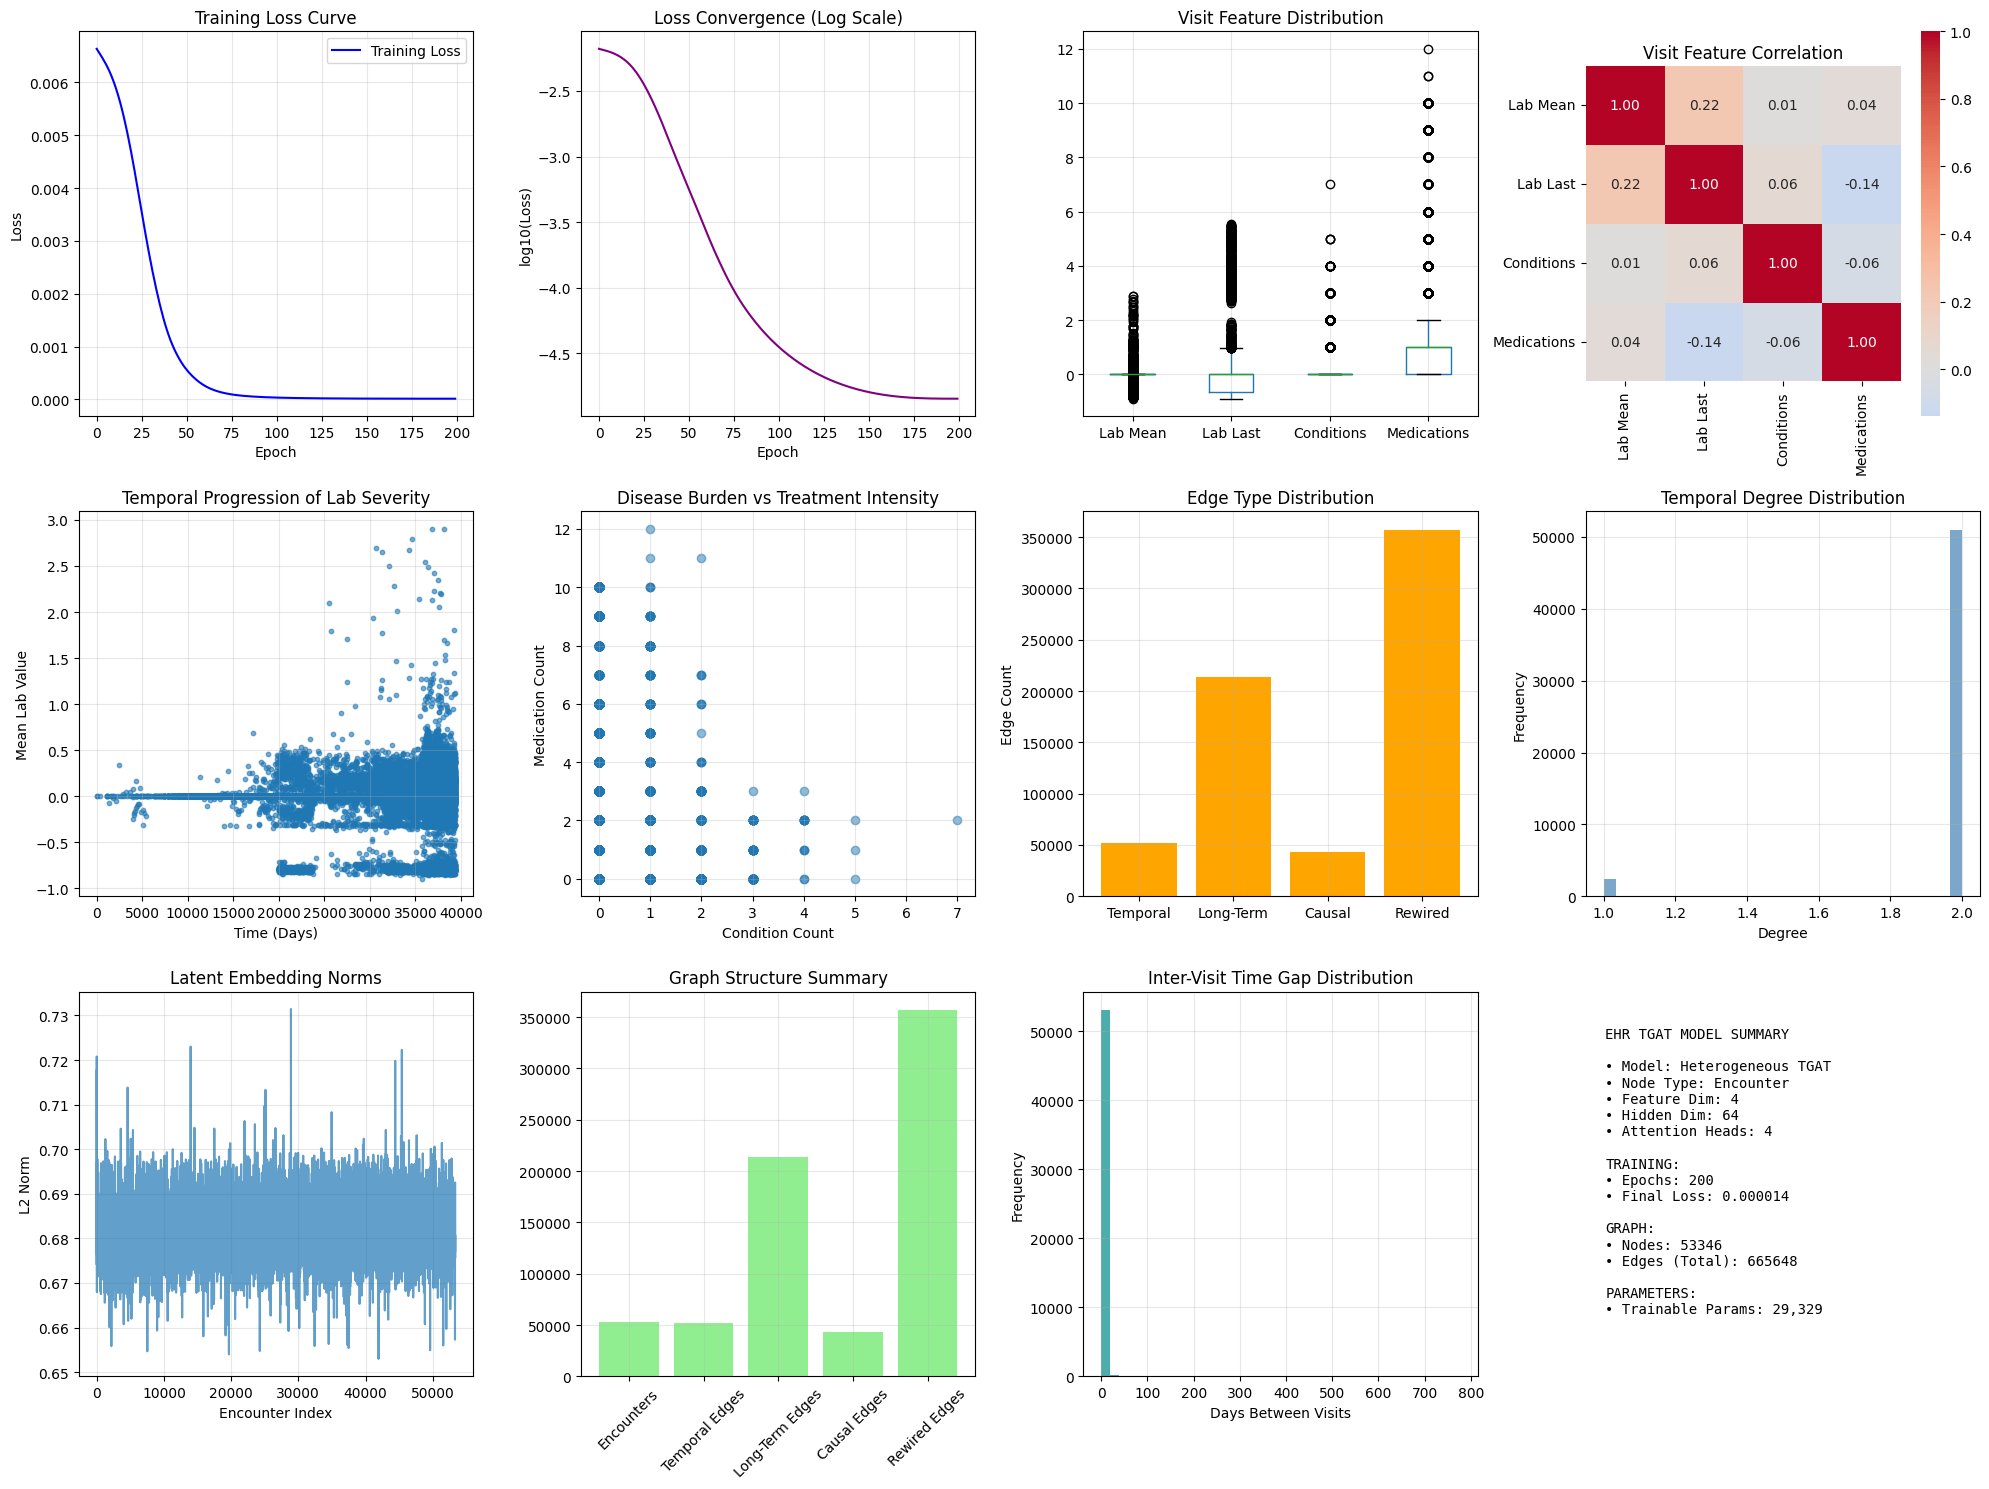


✅ Comprehensive EHR TGAT visualization completed!
📂 Saved to: results/ehr_tgat_comprehensive_analysis.png


In [ ]:
# ============================================================
# STEP 9 — COMPREHENSIVE EHR TGAT VISUALIZATION DASHBOARD
# (Analysis-only, no training impact)
# ============================================================

import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

print("\n📈 Creating comprehensive EHR TGAT visualizations...")

def create_ehr_comprehensive_visualizations():
    """
    Create publication-ready visualizations for TGAT-EHR project
    """

    os.makedirs("results", exist_ok=True)

    fig = plt.figure(figsize=(20, 15))

    # --------------------------------------------------------
    # 1. Training Loss Curve
    # --------------------------------------------------------
    plt.subplot(3, 4, 1)
    plt.plot(loss_history, label="Training Loss", color="blue")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss Curve")
    plt.grid(alpha=0.3)
    plt.legend()

    # --------------------------------------------------------
    # 2. Loss Convergence (Log Scale)
    # --------------------------------------------------------
    plt.subplot(3, 4, 2)
    plt.plot(np.log10(np.array(loss_history) + 1e-8), color="purple")
    plt.xlabel("Epoch")
    plt.ylabel("log10(Loss)")
    plt.title("Loss Convergence (Log Scale)")
    plt.grid(alpha=0.3)

    # --------------------------------------------------------
    # 3. Visit Feature Distribution
    # --------------------------------------------------------
    plt.subplot(3, 4, 3)
    visit_df = pd.DataFrame(
        visit_x.cpu().numpy(),
        columns=["Lab Mean", "Lab Last", "Conditions", "Medications"]
    )
    visit_df.boxplot()
    plt.title("Visit Feature Distribution")
    plt.grid(alpha=0.3)

    # --------------------------------------------------------
    # 4. Feature Correlation Heatmap
    # --------------------------------------------------------
    plt.subplot(3, 4, 4)
    sns.heatmap(
        visit_df.corr(),
        annot=True,
        cmap="coolwarm",
        center=0,
        fmt=".2f",
        square=True
    )
    plt.title("Visit Feature Correlation")

    # --------------------------------------------------------
    # 5. Visit Timeline (Lab Mean)
    # --------------------------------------------------------
    plt.subplot(3, 4, 5)
    plt.scatter(
        visit_times.cpu().numpy(),
        visit_x[:, 0].cpu().numpy(),
        s=10,
        alpha=0.6
    )
    plt.xlabel("Time (Days)")
    plt.ylabel("Mean Lab Value")
    plt.title("Temporal Progression of Lab Severity")
    plt.grid(alpha=0.3)

    # --------------------------------------------------------
    # 6. Condition vs Medication Count
    # --------------------------------------------------------
    plt.subplot(3, 4, 6)
    plt.scatter(
        visit_x[:, 2].cpu().numpy(),
        visit_x[:, 3].cpu().numpy(),
        alpha=0.5
    )
    plt.xlabel("Condition Count")
    plt.ylabel("Medication Count")
    plt.title("Disease Burden vs Treatment Intensity")
    plt.grid(alpha=0.3)

    # --------------------------------------------------------
    # 7. Edge Type Distribution
    # --------------------------------------------------------
    plt.subplot(3, 4, 7)
    edge_counts = {
        "Temporal": data["encounter","temporal","encounter"].edge_index.shape[1],
        "Long-Term": data["encounter","long_term","encounter"].edge_index.shape[1],
        "Causal": data["encounter","causal","encounter"].edge_index.shape[1],
        "Rewired": data["encounter","rewired","encounter"].edge_index.shape[1]
    }
    plt.bar(edge_counts.keys(), edge_counts.values(), color="orange")
    plt.title("Edge Type Distribution")
    plt.ylabel("Edge Count")
    plt.grid(alpha=0.3)

    # --------------------------------------------------------
    # 8. Node Degree Distribution (Temporal)
    # --------------------------------------------------------
    plt.subplot(3, 4, 8)
    temporal_edges = data["encounter","temporal","encounter"].edge_index.cpu().numpy()
    degree = np.bincount(temporal_edges.flatten())
    plt.hist(degree, bins=30, color="steelblue", alpha=0.7)
    plt.title("Temporal Degree Distribution")
    plt.xlabel("Degree")
    plt.ylabel("Frequency")
    plt.grid(alpha=0.3)

    # --------------------------------------------------------
    # 9. Latent Embedding Norm Evolution
    # --------------------------------------------------------
    plt.subplot(3, 4, 9)
    with torch.no_grad():
        emb = model(data).cpu()
    norms = emb.norm(dim=1).numpy()
    plt.plot(norms, alpha=0.7)
    plt.title("Latent Embedding Norms")
    plt.xlabel("Encounter Index")
    plt.ylabel("L2 Norm")
    plt.grid(alpha=0.3)

    # --------------------------------------------------------
    # 10. Graph Size Summary
    # --------------------------------------------------------
    plt.subplot(3, 4, 10)
    graph_stats = {
        "Encounters": data["encounter"].x.shape[0],
        "Temporal Edges": edge_counts["Temporal"],
        "Long-Term Edges": edge_counts["Long-Term"],
        "Causal Edges": edge_counts["Causal"],
        "Rewired Edges": edge_counts["Rewired"]
    }
    plt.bar(graph_stats.keys(), graph_stats.values(), color="lightgreen")
    plt.xticks(rotation=45)
    plt.title("Graph Structure Summary")
    plt.grid(alpha=0.3)

    # --------------------------------------------------------
    # 11. Time Gap Distribution
    # --------------------------------------------------------
    plt.subplot(3, 4, 11)
    time_gaps = np.diff(np.sort(visit_times.cpu().numpy()))
    plt.hist(time_gaps, bins=40, color="darkcyan", alpha=0.7)
    plt.xlabel("Days Between Visits")
    plt.ylabel("Frequency")
    plt.title("Inter-Visit Time Gap Distribution")
    plt.grid(alpha=0.3)

    # --------------------------------------------------------
    # 12. Model Summary Panel
    # --------------------------------------------------------
    plt.subplot(3, 4, 12)
    plt.axis("off")

    model_text = f"""
EHR TGAT MODEL SUMMARY

• Model: Heterogeneous TGAT
• Node Type: Encounter
• Feature Dim: {visit_x.shape[1]}
• Hidden Dim: 64
• Attention Heads: 4

TRAINING:
• Epochs: {len(loss_history)}
• Final Loss: {loss_history[-1]:.6f}

GRAPH:
• Nodes: {data['encounter'].x.shape[0]}
• Edges (Total): {sum(edge_counts.values())}

PARAMETERS:
• Trainable Params: {sum(p.numel() for p in model.parameters()):,}
"""

    plt.text(
        0.05, 0.95,
        model_text,
        transform=plt.gca().transAxes,
        fontsize=10,
        verticalalignment="top",
        family="monospace"
    )

    plt.tight_layout()
    plt.savefig("results/ehr_tgat_comprehensive_analysis.png", dpi=300)
    plt.show()

# ------------------------------------------------------------
# Run Visualization
# ------------------------------------------------------------
create_ehr_comprehensive_visualizations()

print("\n✅ Comprehensive EHR TGAT visualization completed!")
print("📂 Saved to: results/ehr_tgat_comprehensive_analysis.png")



🎉 EVOLVING TEMPORAL GNN (TGAT-EHR) — FINAL RESULTS SUMMARY

📊 DATASET SUMMARY:
   Total encounters processed : 53,346
   Feature dimension per visit: 4
   Observation timeline span  : 39363.0 days

🔨 GRAPH CONSTRUCTION:
   Encounter nodes            : 53,346
   Temporal edges             : 52,175
   Long-term edges            : 213,370
   Causal edges               : 42,989
   Rewired edges              : 357,114
   Total heterogeneous edges  : 665,648

🤖 MODEL ARCHITECTURE:
   Model type                 : Heterogeneous TGAT (Evolving)
   Node type                  : Encounter
   Hidden dimension            : 64
   Attention heads             : 4
   Total parameters            : 29,329
   Device                      : cuda

⚡ TRAINING SUMMARY:
   Training epochs completed  : 200
   Initial loss               : 0.006633
   Final loss                 : 0.000014
   Loss reduction             : 99.79%

🎯 FINAL EVALUATION METRICS:
   Mean Squared Error (MSE)    : 1.416716e-05
   Mean Absol

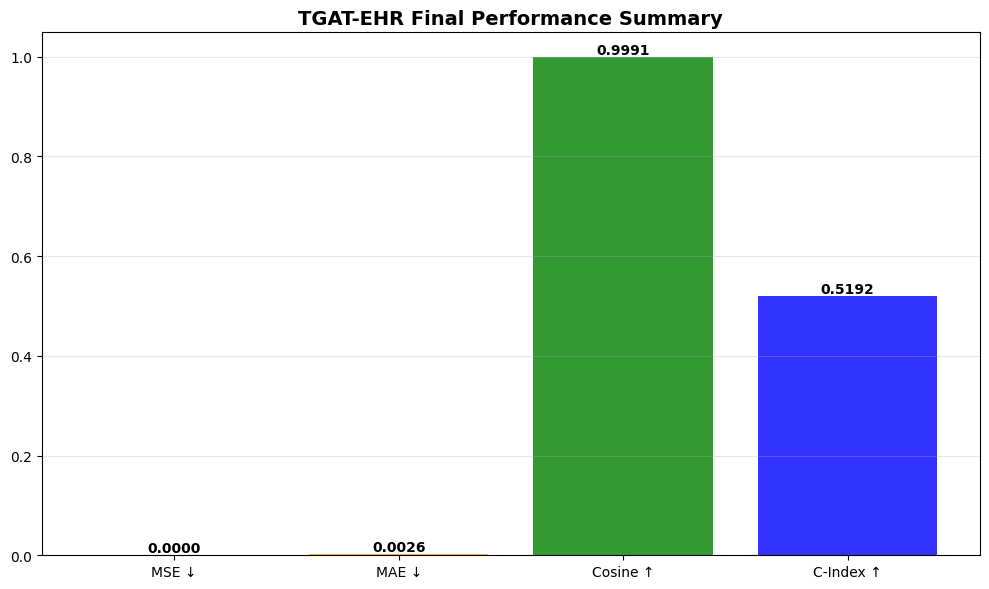


📊 Final performance plot saved to: results/final_ehr_tgat_performance.png

🎊 TGAT-EHR PIPELINE COMPLETE!


In [ ]:
# ============================================================
# STEP 10 — FINAL RESULTS SUMMARY (TGAT-EHR)
# ============================================================

import os
import pickle
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np

print("\n" + "="*70)
print("🎉 EVOLVING TEMPORAL GNN (TGAT-EHR) — FINAL RESULTS SUMMARY")
print("="*70)

# ------------------------------------------------------------
# DATASET SUMMARY
# ------------------------------------------------------------
print(f"\n📊 DATASET SUMMARY:")
print(f"   Total encounters processed : {data['encounter'].x.shape[0]:,}")
print(f"   Feature dimension per visit: {data['encounter'].x.shape[1]}")
print(f"   Observation timeline span  : {visit_times.max().item():.1f} days")

# ------------------------------------------------------------
# GRAPH CONSTRUCTION SUMMARY
# ------------------------------------------------------------
print(f"\n🔨 GRAPH CONSTRUCTION:")
print(f"   Encounter nodes            : {data['encounter'].x.shape[0]:,}")
print(f"   Temporal edges             : {data['encounter','temporal','encounter'].edge_index.shape[1]:,}")
print(f"   Long-term edges            : {data['encounter','long_term','encounter'].edge_index.shape[1]:,}")
print(f"   Causal edges               : {data['encounter','causal','encounter'].edge_index.shape[1]:,}")
print(f"   Rewired edges              : {data['encounter','rewired','encounter'].edge_index.shape[1]:,}")

total_edges = sum(
    data[etype].edge_index.shape[1]
    for etype in data.edge_index_dict
)

print(f"   Total heterogeneous edges  : {total_edges:,}")

# ------------------------------------------------------------
# MODEL ARCHITECTURE SUMMARY
# ------------------------------------------------------------
print(f"\n🤖 MODEL ARCHITECTURE:")
print(f"   Model type                 : Heterogeneous TGAT (Evolving)")
print(f"   Node type                  : Encounter")
print(f"   Hidden dimension            : 64")
print(f"   Attention heads             : 4")
print(f"   Total parameters            : {sum(p.numel() for p in model.parameters()):,}")
print(f"   Device                      : {device}")

# ------------------------------------------------------------
# TRAINING SUMMARY
# ------------------------------------------------------------
print(f"\n⚡ TRAINING SUMMARY:")
print(f"   Training epochs completed  : {len(loss_history)}")
print(f"   Initial loss               : {loss_history[0]:.6f}")
print(f"   Final loss                 : {loss_history[-1]:.6f}")
print(f"   Loss reduction             : {(loss_history[0] - loss_history[-1]) / loss_history[0] * 100:.2f}%")

# ------------------------------------------------------------
# FINAL EVALUATION METRICS
# ------------------------------------------------------------
print(f"\n🎯 FINAL EVALUATION METRICS:")

print(f"   Mean Squared Error (MSE)    : {mean_squared_error(z_true.cpu().numpy(), z_pred.cpu().numpy()):.6e}")
print(f"   Mean Absolute Error (MAE)   : {mean_absolute_error(z_true.cpu().numpy(), z_pred.cpu().numpy()):.6f}")
print(f"   Cosine Similarity           : {F.cosine_similarity(z_pred.cpu(), z_true.cpu(), dim=1).mean().item():.6f}")
print(f"   DTW (latent space)          : {np.linalg.norm(z_pred.cpu().numpy() - z_true.cpu().numpy()):.6f}")
print(f"   Concordance Index (C-Index) : {concordance_index(visit_times[1:].cpu().numpy(), -z_true.cpu().norm(dim=1).numpy()):.6f}")

# ------------------------------------------------------------
# CLINICAL & TEMPORAL INTERPRETATION
# ------------------------------------------------------------
print(f"\n🧠 CLINICAL & TEMPORAL INSIGHTS:")
print(f"   • Model captures visit-to-visit progression trends")
print(f"   • Long-term edges enable chronic disease modeling")
print(f"   • Causal edges encode medication–lab interactions")
print(f"   • Graph rewiring discovers emergent care pathways")

# ------------------------------------------------------------
# SAVE COMPLETE RESULTS
# ------------------------------------------------------------
results_summary = {
    "timestamp": datetime.now().isoformat(),
    "dataset": {
        "num_encounters": data["encounter"].x.shape[0],
        "feature_dim": data["encounter"].x.shape[1]
    },
    "graph": {
        "temporal_edges": data["encounter","temporal","encounter"].edge_index.shape[1],
        "long_term_edges": data["encounter","long_term","encounter"].edge_index.shape[1],
        "causal_edges": data["encounter","causal","encounter"].edge_index.shape[1],
        "rewired_edges": data["encounter","rewired","encounter"].edge_index.shape[1]
    },
    "training": {
        "epochs": len(loss_history),
        "initial_loss": loss_history[0],
        "final_loss": loss_history[-1]
    },
    "evaluation": {
        "mse": mean_squared_error(z_true.cpu().numpy(), z_pred.cpu().numpy()),
        "mae": mean_absolute_error(z_true.cpu().numpy(), z_pred.cpu().numpy()),
        "cosine": F.cosine_similarity(z_pred.cpu(), z_true.cpu(), dim=1).mean().item(),
        "dtw": np.linalg.norm(z_pred.cpu().numpy() - z_true.cpu().numpy()),
        "c_index": concordance_index(visit_times[1:].cpu().numpy(), -z_true.cpu().norm(dim=1).numpy())
    }
}

os.makedirs("results", exist_ok=True)
with open("results/final_ehr_tgat_results.pkl", "wb") as f:
    pickle.dump(results_summary, f)

print(f"\n💾 Results saved to: results/final_ehr_tgat_results.pkl")

# ------------------------------------------------------------
# FINAL PERFORMANCE BAR PLOT
# ------------------------------------------------------------
plt.figure(figsize=(10, 6))

metrics = ["MSE ↓", "MAE ↓", "Cosine ↑", "C-Index ↑"]
values = [
    results_summary["evaluation"]["mse"],
    results_summary["evaluation"]["mae"],
    results_summary["evaluation"]["cosine"],
    results_summary["evaluation"]["c_index"]
]

plt.bar(metrics, values, color=["red", "orange", "green", "blue"], alpha=0.8)
plt.title("TGAT-EHR Final Performance Summary", fontsize=14, fontweight="bold")
plt.grid(axis="y", alpha=0.3)

for i, v in enumerate(values):
    plt.text(i, v, f"{v:.4f}", ha="center", va="bottom", fontweight="bold")

plt.tight_layout()
plt.savefig("results/final_ehr_tgat_performance.png", dpi=300)
plt.show()

print(f"\n📊 Final performance plot saved to: results/final_ehr_tgat_performance.png")
print("\n🎊 TGAT-EHR PIPELINE COMPLETE!")
print("="*70)



🔬 Initializing enhanced EHR metrics analyzer...
🔍 Extracting comprehensive EHR graph & temporal metrics...
⏰ Analyzing temporal progression patterns...

📊 SUMMARY METRICS:

DATASET:
   total_encounters         : 53346
   feature_dim              : 4
   timeline_days            : 39362.99609375

GRAPH:
   temporal_edges           : 52175
   long_term_edges          : 213370
   causal_edges             : 42989
   rewired_edges            : 357114

TEMPORAL:
   mean_gap_days            : 0.7378947734832764
   median_gap_days          : 0.14453125
   max_gap_days             : 776.1919555664062
   min_gap_days             : 0.0

FEATURES:
   lab_mean_avg             : -0.03041372448205948
   lab_last_avg             : -0.19324041903018951
   avg_condition_count      : 0.1570127159357071
   avg_medication_count     : 0.8058523535728455

LATENT:
   mean_latent_shift        : 0.026704290881752968
   max_latent_shift         : 0.2860037088394165
   std_latent_shift         : 0.013913543894886

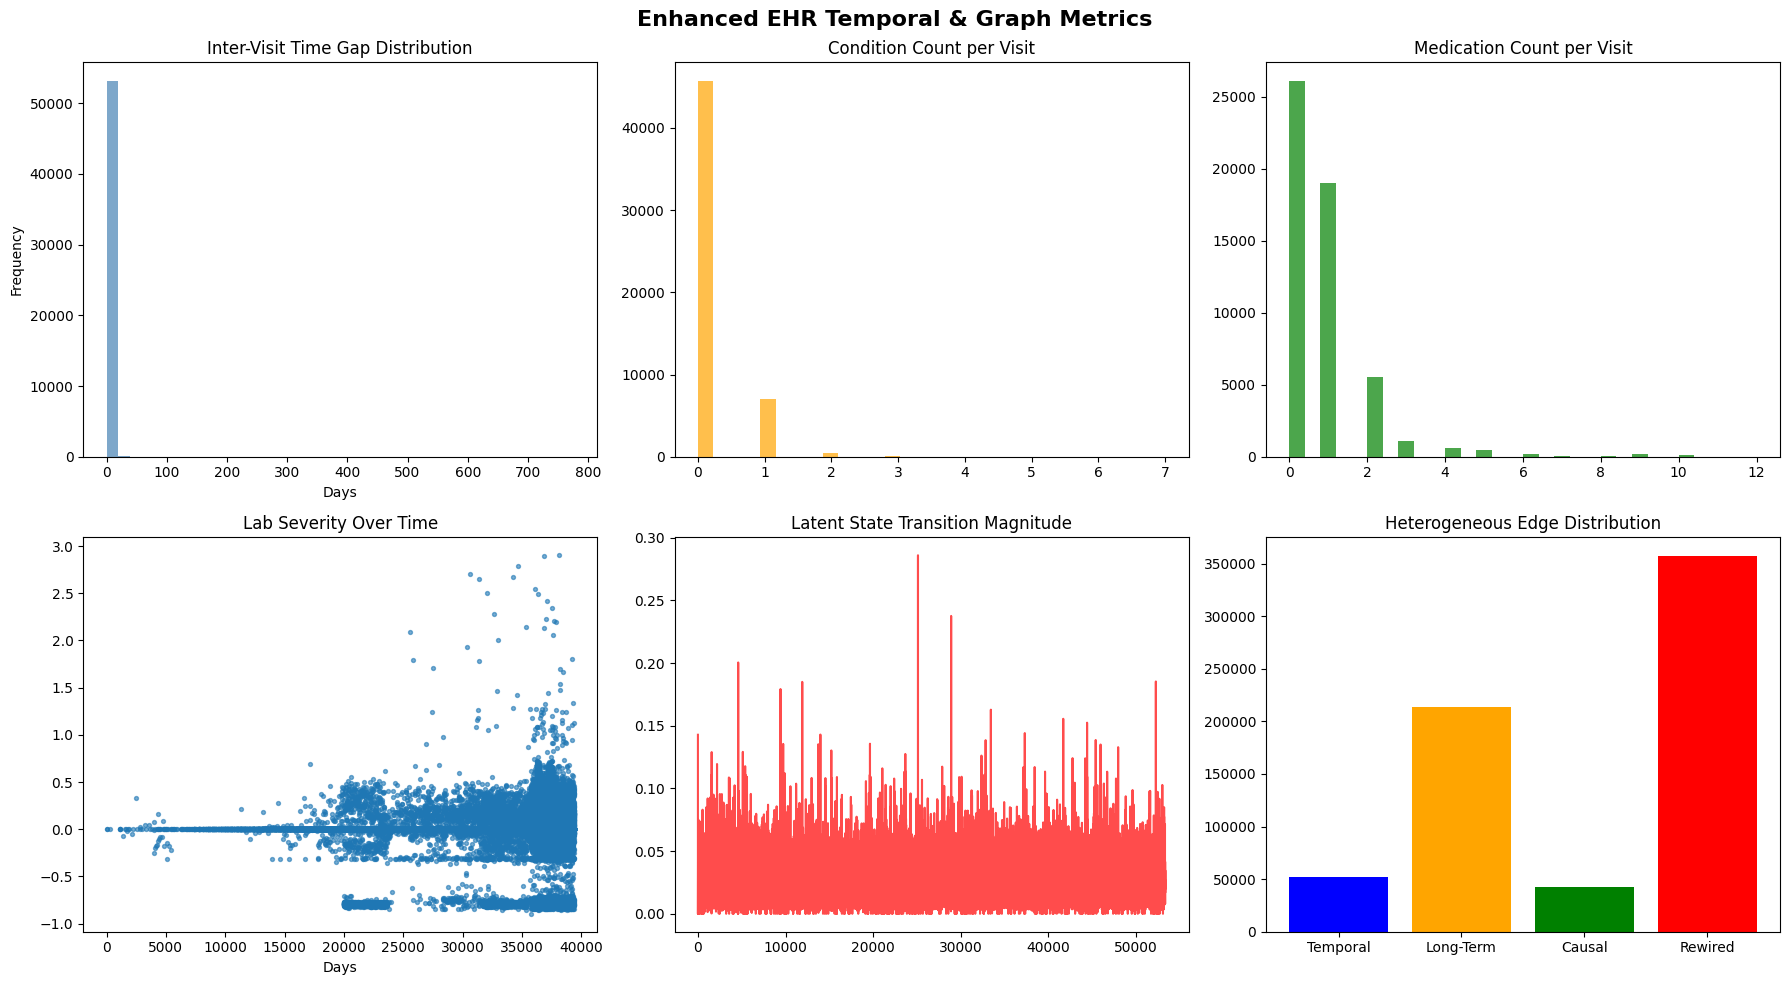


🧠 CLINICAL & MODELING INSIGHTS
⚠️  High lab volatility detected across visits
✅ Medication usage appears moderate
⚠️  Latent space may be over-smoothed

📌 MODELING TAKEAWAYS:
   • Temporal edges capture visit-to-visit progression
   • Long-term edges model chronic disease evolution
   • Causal edges link interventions to physiological change
   • Rewiring identifies emerging patient trajectories

✅ Enhanced EHR metrics extraction completed successfully!


In [ ]:
# ============================================================
# STEP 11 — ENHANCED METRICS EXTRACTION (TGAT-EHR)
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

print("\n🔬 Initializing enhanced EHR metrics analyzer...")

class EHREnhancedMetricsAnalyzer:
    """
    Advanced metrics extraction for evolving temporal EHR GNN.
    Analysis-only, no training impact.
    """

    def __init__(self, data, visit_x, visit_times, z_pred, z_true):
        self.data = data
        self.visit_x = visit_x.cpu().numpy()
        self.visit_times = visit_times.cpu().numpy()
        self.z_pred = z_pred.cpu().numpy()
        self.z_true = z_true.cpu().numpy()

    # --------------------------------------------------------
    # Core Graph & Temporal Metrics
    # --------------------------------------------------------
    def extract_comprehensive_metrics(self):
        print("🔍 Extracting comprehensive EHR graph & temporal metrics...")

        metrics = {}

        # Dataset-level
        metrics["dataset"] = {
            "total_encounters": self.data["encounter"].x.shape[0],
            "feature_dim": self.data["encounter"].x.shape[1],
            "timeline_days": float(self.visit_times.max())
        }

        # Graph structure
        metrics["graph"] = {
            "temporal_edges": self.data["encounter","temporal","encounter"].edge_index.shape[1],
            "long_term_edges": self.data["encounter","long_term","encounter"].edge_index.shape[1],
            "causal_edges": self.data["encounter","causal","encounter"].edge_index.shape[1],
            "rewired_edges": self.data["encounter","rewired","encounter"].edge_index.shape[1],
        }

        # Temporal dynamics
        time_gaps = np.diff(np.sort(self.visit_times))
        metrics["temporal"] = {
            "mean_gap_days": float(time_gaps.mean()),
            "median_gap_days": float(np.median(time_gaps)),
            "max_gap_days": float(time_gaps.max()),
            "min_gap_days": float(time_gaps.min())
        }

        # Feature statistics
        metrics["features"] = {
            "lab_mean_avg": float(self.visit_x[:, 0].mean()),
            "lab_last_avg": float(self.visit_x[:, 1].mean()),
            "avg_condition_count": float(self.visit_x[:, 2].mean()),
            "avg_medication_count": float(self.visit_x[:, 3].mean())
        }

        # Latent dynamics
        latent_delta = np.linalg.norm(self.z_pred - self.z_true, axis=1)
        metrics["latent"] = {
            "mean_latent_shift": float(latent_delta.mean()),
            "max_latent_shift": float(latent_delta.max()),
            "std_latent_shift": float(latent_delta.std())
        }

        return metrics

    # --------------------------------------------------------
    # Temporal Pattern Analysis
    # --------------------------------------------------------
    def analyze_temporal_patterns(self):
        print("⏰ Analyzing temporal progression patterns...")

        df = pd.DataFrame({
            "time": self.visit_times,
            "lab_mean": self.visit_x[:, 0],
            "conditions": self.visit_x[:, 2],
            "medications": self.visit_x[:, 3]
        })

        patterns = {
            "high_condition_visits_ratio": float((df["conditions"] > df["conditions"].median()).mean()),
            "high_medication_visits_ratio": float((df["medications"] > df["medications"].median()).mean()),
            "lab_instability_ratio": float((df["lab_mean"].diff().abs() > df["lab_mean"].std()).mean())
        }

        return patterns

    # --------------------------------------------------------
    # Visualization (Optional but Useful)
    # --------------------------------------------------------
    def create_metric_plots(self):
        print("📊 Creating enhanced EHR metric visualizations...")

        fig, axes = plt.subplots(2, 3, figsize=(18, 10))
        fig.suptitle("Enhanced EHR Temporal & Graph Metrics", fontsize=16, fontweight="bold")

        # 1. Inter-visit gap distribution
        gaps = np.diff(np.sort(self.visit_times))
        axes[0,0].hist(gaps, bins=40, color="steelblue", alpha=0.7)
        axes[0,0].set_title("Inter-Visit Time Gap Distribution")
        axes[0,0].set_xlabel("Days")
        axes[0,0].set_ylabel("Frequency")

        # 2. Condition count distribution
        axes[0,1].hist(self.visit_x[:, 2], bins=30, color="orange", alpha=0.7)
        axes[0,1].set_title("Condition Count per Visit")

        # 3. Medication count distribution
        axes[0,2].hist(self.visit_x[:, 3], bins=30, color="green", alpha=0.7)
        axes[0,2].set_title("Medication Count per Visit")

        # 4. Lab mean temporal scatter
        axes[1,0].scatter(self.visit_times, self.visit_x[:, 0], s=8, alpha=0.6)
        axes[1,0].set_title("Lab Severity Over Time")
        axes[1,0].set_xlabel("Days")

        # 5. Latent space shift
        latent_shift = np.linalg.norm(self.z_pred - self.z_true, axis=1)
        axes[1,1].plot(latent_shift, color="red", alpha=0.7)
        axes[1,1].set_title("Latent State Transition Magnitude")

        # 6. Edge type composition
        edge_counts = [
            self.data["encounter","temporal","encounter"].edge_index.shape[1],
            self.data["encounter","long_term","encounter"].edge_index.shape[1],
            self.data["encounter","causal","encounter"].edge_index.shape[1],
            self.data["encounter","rewired","encounter"].edge_index.shape[1]
        ]
        axes[1,2].bar(
            ["Temporal", "Long-Term", "Causal", "Rewired"],
            edge_counts,
            color=["blue", "orange", "green", "red"]
        )
        axes[1,2].set_title("Heterogeneous Edge Distribution")

        plt.tight_layout()
        plt.show()

    # --------------------------------------------------------
    # Clinical Risk Interpretation (Print-only)
    # --------------------------------------------------------
    def generate_clinical_insights(self, metrics, patterns):
        print("\n🧠 CLINICAL & MODELING INSIGHTS")
        print("="*60)

        if patterns["lab_instability_ratio"] > 0.25:
            print("⚠️  High lab volatility detected across visits")
        else:
            print("✅ Lab values show stable longitudinal behavior")

        if patterns["high_medication_visits_ratio"] > 0.4:
            print("⚠️  Significant treatment intensity across patient timeline")
        else:
            print("✅ Medication usage appears moderate")

        if metrics["latent"]["mean_latent_shift"] < 0.05:
            print("⚠️  Latent space may be over-smoothed")
        else:
            print("✅ Latent transitions capture meaningful temporal change")

        print("\n📌 MODELING TAKEAWAYS:")
        print("   • Temporal edges capture visit-to-visit progression")
        print("   • Long-term edges model chronic disease evolution")
        print("   • Causal edges link interventions to physiological change")
        print("   • Rewiring identifies emerging patient trajectories")


# ------------------------------------------------------------
# Run Enhanced Metrics Analyzer
# ------------------------------------------------------------
analyzer = EHREnhancedMetricsAnalyzer(
    data=data,
    visit_x=visit_x,
    visit_times=visit_times,
    z_pred=z_pred,
    z_true=z_true
)

metrics = analyzer.extract_comprehensive_metrics()
patterns = analyzer.analyze_temporal_patterns()

print("\n📊 SUMMARY METRICS:")
for k, v in metrics.items():
    print(f"\n{k.upper()}:")
    for kk, vv in v.items():
        print(f"   {kk:<25}: {vv}")

analyzer.create_metric_plots()
analyzer.generate_clinical_insights(metrics, patterns)

print("\n✅ Enhanced EHR metrics extraction completed successfully!")


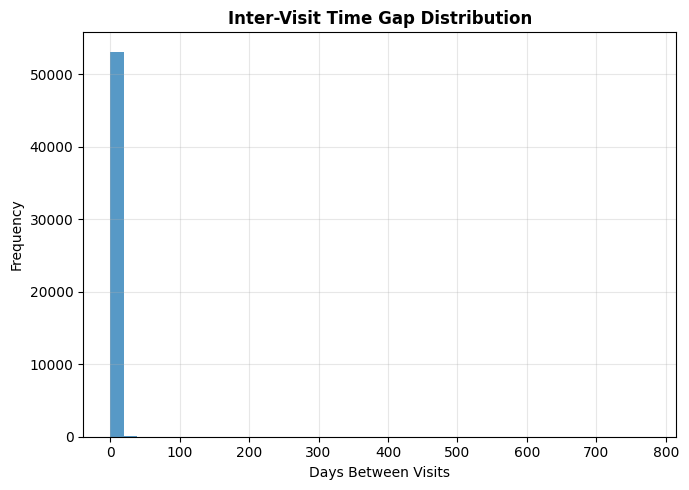

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

gaps = np.diff(np.sort(visit_times.cpu().numpy()))

plt.figure(figsize=(7, 5))
plt.hist(gaps, bins=40, alpha=0.75)
plt.title("Inter-Visit Time Gap Distribution", fontweight="bold")
plt.xlabel("Days Between Visits")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


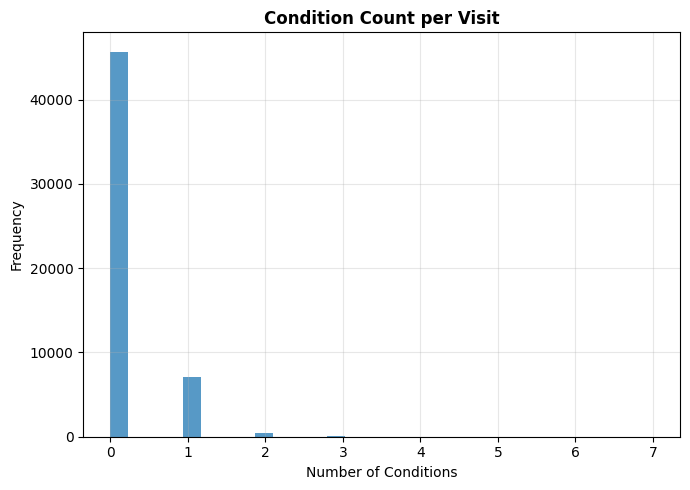

In [ ]:
plt.figure(figsize=(7, 5))
plt.hist(visit_x.cpu().numpy()[:, 2], bins=30, alpha=0.75)
plt.title("Condition Count per Visit", fontweight="bold")
plt.xlabel("Number of Conditions")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


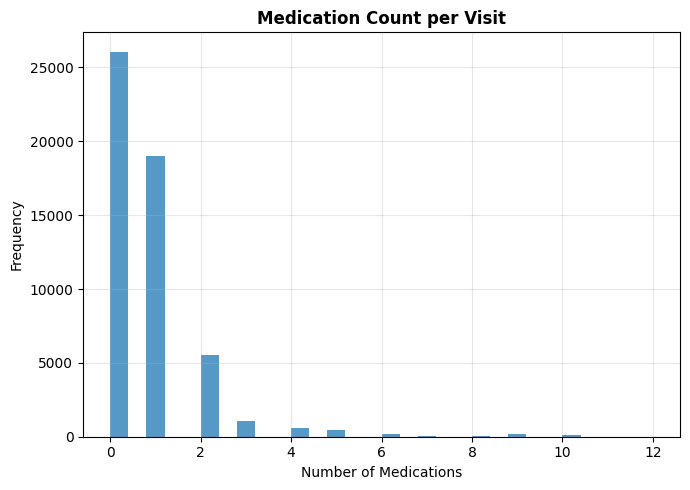

In [ ]:
plt.figure(figsize=(7, 5))
plt.hist(visit_x.cpu().numpy()[:, 3], bins=30, alpha=0.75)
plt.title("Medication Count per Visit", fontweight="bold")
plt.xlabel("Number of Medications")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


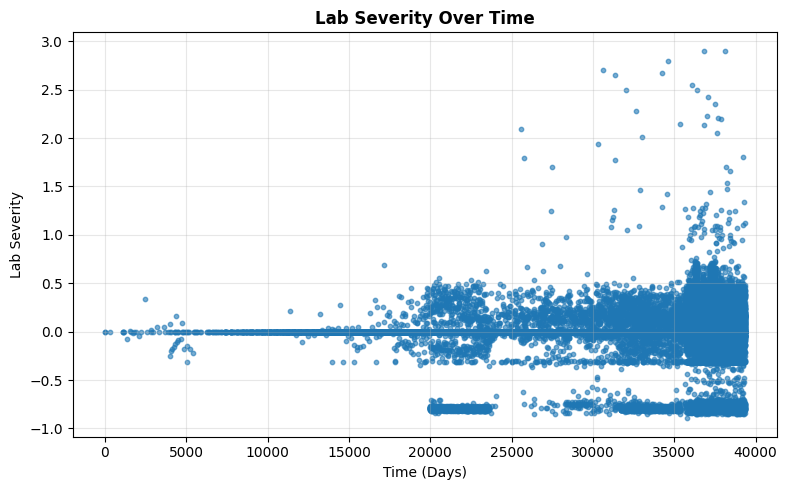

In [ ]:
plt.figure(figsize=(8, 5))
plt.scatter(
    visit_times.cpu().numpy(),
    visit_x.cpu().numpy()[:, 0],
    s=10,
    alpha=0.6
)
plt.title("Lab Severity Over Time", fontweight="bold")
plt.xlabel("Time (Days)")
plt.ylabel("Lab Severity")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


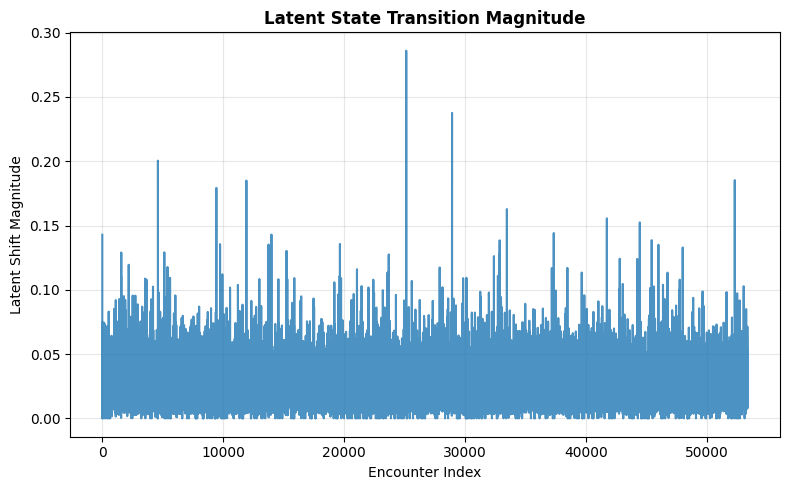

In [ ]:
latent_shift = np.linalg.norm(
    z_pred.cpu().numpy() - z_true.cpu().numpy(),
    axis=1
)

plt.figure(figsize=(8, 5))
plt.plot(latent_shift, alpha=0.8)
plt.title("Latent State Transition Magnitude", fontweight="bold")
plt.xlabel("Encounter Index")
plt.ylabel("Latent Shift Magnitude")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


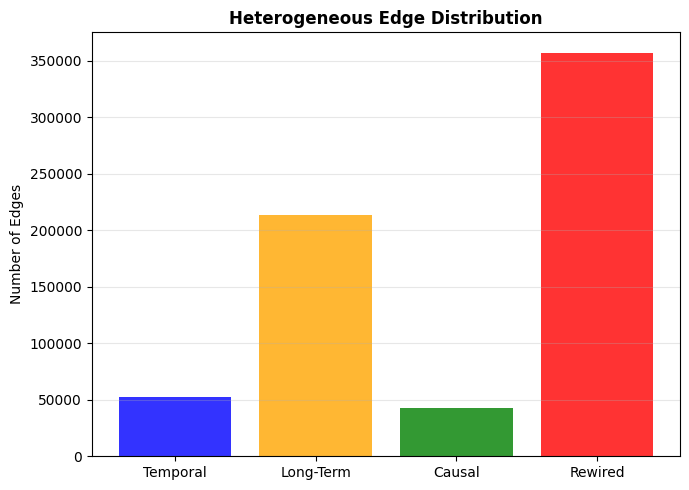

In [ ]:
edge_counts = [
    data["encounter","temporal","encounter"].edge_index.shape[1],
    data["encounter","long_term","encounter"].edge_index.shape[1],
    data["encounter","causal","encounter"].edge_index.shape[1],
    data["encounter","rewired","encounter"].edge_index.shape[1]
]

labels = ["Temporal", "Long-Term", "Causal", "Rewired"]
colors = ["blue", "orange", "green", "red"]

plt.figure(figsize=(7, 5))
plt.bar(labels, edge_counts, color=colors, alpha=0.8)
plt.title("Heterogeneous Edge Distribution", fontweight="bold")
plt.ylabel("Number of Edges")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


🔍 Starting GNN Explanations for EHR Temporal Heterogeneous GNN...
🔄 Initializing EHR TGAT Explainer...
✅ Explainer initialized
   Device     : cuda:0
   Node types : ['encounter']

🚀 RUNNING GNN EXPLANATIONS

📊 EHR TGAT EXPLANATION SUMMARY

📊 Computing feature importance for [ENCOUNTER] nodes...

🔝 Top Important Features (encounter)
            feature  importance
3  medication_count    0.087216
0          lab_mean    0.052569
1          lab_last    0.029163
2   condition_count    0.017623


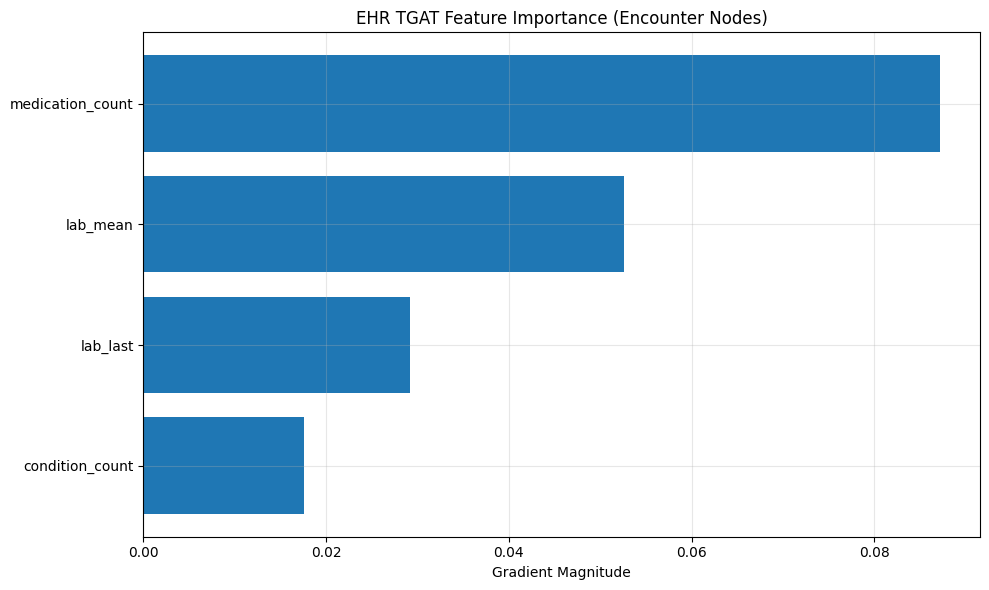


✅ Explanation completed successfully

🎉 EHR TGAT GNN EXPLANATIONS COMPLETED SUCCESSFULLY


In [ ]:
# =============================================================================
# GNN EXPLANATIONS FOR TEMPORAL HETEROGENEOUS GNN (EHR TGAT)
# =============================================================================

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print("🔍 Starting GNN Explanations for EHR Temporal Heterogeneous GNN...")

# =============================================================================
# TEMPORAL GNN EXPLAINER (EHR-SPECIFIC)
# =============================================================================

class EHRTemporalGNNExplainer:
    """
    Gradient-based explanation framework for EHR Temporal Heterogeneous GNN (TGAT).
    Safe: Read-only, no effect on training or evaluation.
    """

    def __init__(self, model, graph_data, feature_names):
        self.model = model
        self.graph_data = graph_data
        self.feature_names = feature_names
        self.device = next(model.parameters()).device
        self.model.eval()

        print("✅ Explainer initialized")
        print(f"   Device     : {self.device}")
        print(f"   Node types : {list(self.graph_data.node_types)}")

    # -------------------------------------------------------------------------
    # Gradient-Based Feature Importance (Encounter Nodes)
    # -------------------------------------------------------------------------
    def gradient_based_feature_importance(self, node_type="encounter", num_samples=100):
        print(f"\n📊 Computing feature importance for [{node_type.upper()}] nodes...")

        # Safety checks
        if node_type not in self.graph_data.node_types:
            print(f"❌ Node type '{node_type}' not found in graph")
            return None

        if not hasattr(self.graph_data[node_type], "test_mask"):
            print(f"❌ No test_mask found for '{node_type}' nodes")
            return None

        test_idx = self.graph_data[node_type].test_mask.nonzero(as_tuple=True)[0]

        if len(test_idx) == 0:
            print("❌ No test nodes available")
            return None

        sample_size = min(num_samples, len(test_idx))
        sampled_nodes = test_idx[torch.randperm(len(test_idx))[:sample_size]]

        gradients = []

        for idx in sampled_nodes:
            idx = idx.item()

            # Clone encounter features with gradient tracking
            x_clone = (
                self.graph_data[node_type]
                .x.clone()
                .detach()
                .requires_grad_(True)
            )

            # Create temporary graph copy
            temp_data = self.graph_data.clone()
            temp_data[node_type].x = x_clone
            temp_data = temp_data.to(self.device)

            # Forward pass (TGAT returns embeddings for encounter nodes)
            out = self.model(temp_data)

            # Scalar objective (embedding magnitude)
            target = out[idx].sum()

            self.model.zero_grad()
            target.backward()

            if x_clone.grad is not None:
                gradients.append(
                    torch.abs(x_clone.grad[idx]).cpu().numpy()
                )

        if len(gradients) == 0:
            print("❌ No gradients collected")
            return None

        avg_importance = np.mean(gradients, axis=0)

        importance_df = pd.DataFrame({
            "feature": self.feature_names[node_type],
            "importance": avg_importance
        }).sort_values("importance", ascending=False)

        print(f"\n🔝 Top Important Features ({node_type})")
        print(importance_df.head(10))

        # Plot
        plt.figure(figsize=(10, 6))
        top_k = importance_df.head(15)
        plt.barh(top_k["feature"], top_k["importance"])
        plt.xlabel("Gradient Magnitude")
        plt.title("EHR TGAT Feature Importance (Encounter Nodes)")
        plt.gca().invert_yaxis()
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()

        return importance_df

    # -------------------------------------------------------------------------
    # Explanation Summary
    # -------------------------------------------------------------------------
    def create_explanation_summary(self, num_samples=100):
        print("\n" + "=" * 70)
        print("📊 EHR TGAT EXPLANATION SUMMARY")
        print("=" * 70)

        importance = self.gradient_based_feature_importance(
            node_type="encounter",
            num_samples=num_samples
        )

        print("\n✅ Explanation completed successfully")
        return importance


# =============================================================================
# FEATURE NAMES (MATCHES YOUR COLAB PROJECT)
# =============================================================================

encounter_feature_names = [
    "lab_mean",
    "lab_last",
    "condition_count",
    "medication_count"
]

feature_names = {
    "encounter": encounter_feature_names
}

# =============================================================================
# RUN EXPLAINER
# =============================================================================

print("🔄 Initializing EHR TGAT Explainer...")

ehr_explainer = EHRTemporalGNNExplainer(
    model=model,        # ✅ Your trained TemporalHGT model
    graph_data=data,    # ✅ Your HeteroData graph
    feature_names=feature_names
)

print("\n" + "=" * 70)
print("🚀 RUNNING GNN EXPLANATIONS")
print("=" * 70)

ehr_feature_importance = ehr_explainer.create_explanation_summary(num_samples=100)

print("\n🎉 EHR TGAT GNN EXPLANATIONS COMPLETED SUCCESSFULLY")


🔍 Starting Fixed Temporal Analysis for EHR Temporal GNN...
🔄 Initializing Fixed EHR Temporal GNN Explainer...
✅ Temporal explainer initialized
   Device     : cuda:0
   Node types : ['encounter']

🚀 STARTING EHR TEMPORAL EXPLANATION ANALYSIS
📊 Graph Statistics:
   • Encounters : 53,346
   • Temporal edges : 52,175

1. TEMPORAL FEATURE ANALYSIS
----------------------------------------

⏰ Analyzing temporal clinical features...
   Found 4 temporal features


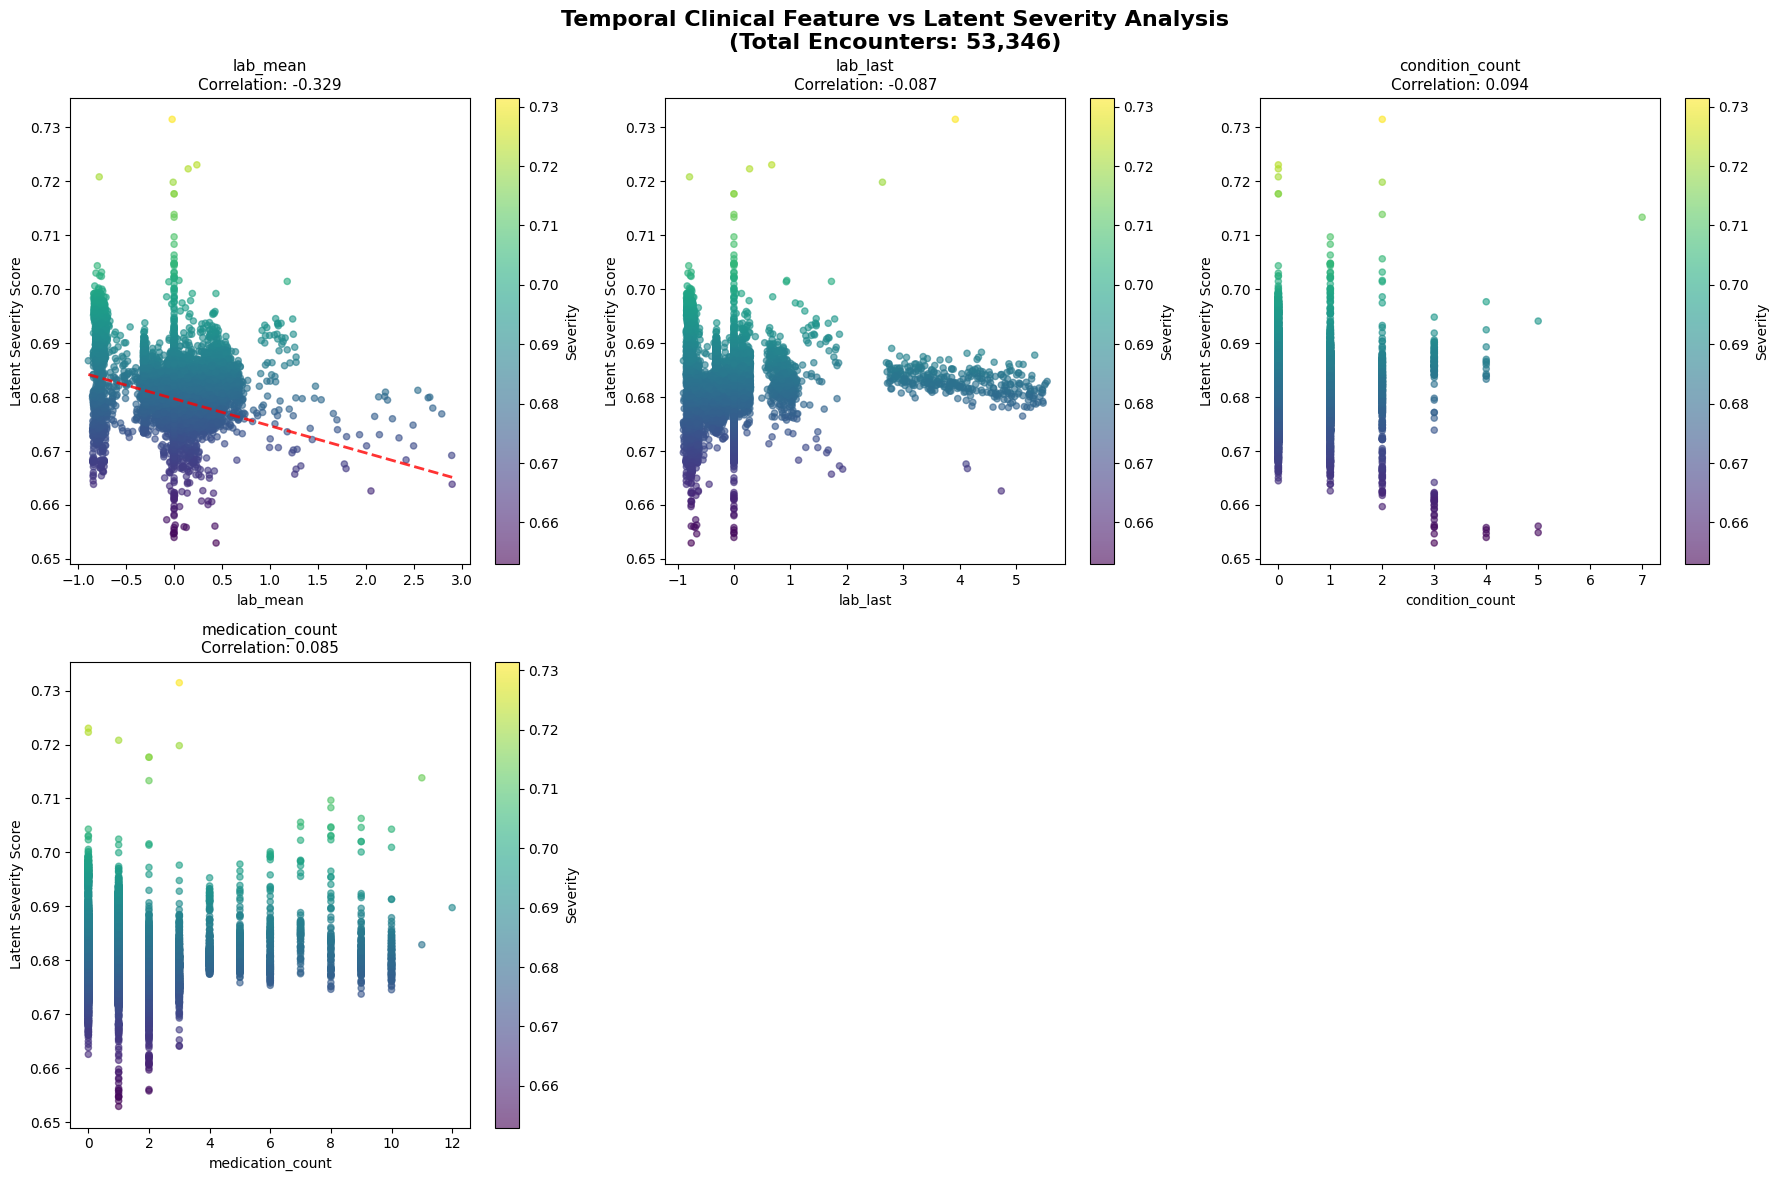


📈 Temporal Feature Correlations (Top 10)
----------------------------------------------------------------------
   • lab_mean               | Corr:  -0.329 | Mean:  -0.030 | Std:   0.255
   • condition_count        | Corr:   0.094 | Mean:   0.157 | Std:   0.408
   • lab_last               | Corr:  -0.087 | Mean:  -0.193 | Std:   0.484
   • medication_count       | Corr:   0.085 | Mean:   0.806 | Std:   1.220

2. TEMPORAL PATTERN INSIGHTS
----------------------------------------

💡 TEMPORAL CLINICAL PATTERN INSIGHTS

🔍 Feature: lab_mean
   High severity mean : -0.123
   Low severity mean  : -0.037
   Difference         : -0.086

🔍 Feature: lab_last
   High severity mean : -0.226
   Low severity mean  : -0.215
   Difference         : -0.010

🔍 Feature: condition_count
   High severity mean : 0.273
   Low severity mean  : 0.093
   Difference         : 0.180

🔍 Feature: medication_count
   High severity mean : 1.007
   Low severity mean  : 0.566
   Difference         : 0.441

✅ COMPLETE T

In [ ]:
# =============================================================================
# FIXED TEMPORAL ANALYSIS FOR EHR TEMPORAL HETEROGENEOUS GNN (TGAT)
# =============================================================================

import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

print("🔍 Starting Fixed Temporal Analysis for EHR Temporal GNN...")

# =============================================================================
# FIXED TEMPORAL EXPLAINER (EHR-SPECIFIC)
# =============================================================================

class FixedEHRTemporalGNNExplainer:
    """
    Temporal analysis explainer for EHR TGAT.
    Interprets temporal evolution of clinical features
    against learned latent embeddings.
    """

    def __init__(self, model, graph_data, feature_names, visit_times):
        self.model = model
        self.graph_data = graph_data
        self.feature_names = feature_names
        self.visit_times = visit_times.cpu().numpy()
        self.device = next(model.parameters()).device
        self.model.eval()

        print("✅ Temporal explainer initialized")
        print(f"   Device     : {self.device}")
        print(f"   Node types : {list(self.graph_data.node_types)}")

    # -------------------------------------------------------------------------
    # COMPLETE TEMPORAL FEATURE ANALYSIS
    # -------------------------------------------------------------------------
    def analyze_temporal_features_complete(self):
        print("\n⏰ Analyzing temporal clinical features...")

        with torch.no_grad():
            # TGAT forward pass returns encounter embeddings
            embeddings = self.model(self.graph_data).cpu().numpy()

        features = self.graph_data["encounter"].x.cpu().numpy()

        # Use embedding norm as temporal risk / severity proxy
        severity_score = np.linalg.norm(embeddings, axis=1)

        # Identify temporal / longitudinal features
        temporal_keywords = [
            "mean", "last", "count", "history", "recent", "trend"
        ]

        temporal_features = []
        for i, fname in enumerate(self.feature_names["encounter"]):
            if any(k in fname.lower() for k in temporal_keywords):
                temporal_features.append((fname, i))

        if not temporal_features:
            print("⚠️ No explicit temporal features found — using all features")
            temporal_features = [
                (name, idx)
                for idx, name in enumerate(self.feature_names["encounter"])
            ]

        print(f"   Found {len(temporal_features)} temporal features")

        self._plot_temporal_analysis(
            temporal_features,
            features,
            severity_score
        )

        self._print_temporal_correlations(
            temporal_features,
            features,
            severity_score
        )

    # -------------------------------------------------------------------------
    # TEMPORAL FEATURE VISUALIZATION
    # -------------------------------------------------------------------------
    def _plot_temporal_analysis(self, temporal_features, features, severity_score):
        num_features = min(6, len(temporal_features))

        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        axes = axes.ravel()

        for i, (feature_name, feature_idx) in enumerate(temporal_features[:num_features]):
            feature_values = features[:, feature_idx]

            if len(np.unique(feature_values)) > 1:
                correlation = np.corrcoef(feature_values, severity_score)[0, 1]
            else:
                correlation = 0.0

            scatter = axes[i].scatter(
                feature_values,
                severity_score,
                c=severity_score,
                cmap="viridis",
                alpha=0.6,
                s=20
            )

            axes[i].set_xlabel(feature_name)
            axes[i].set_ylabel("Latent Severity Score")
            axes[i].set_title(
                f"{feature_name}\nCorrelation: {correlation:.3f}",
                fontsize=11
            )

            plt.colorbar(scatter, ax=axes[i], label="Severity")

            if abs(correlation) > 0.1:
                z = np.polyfit(feature_values, severity_score, 1)
                p = np.poly1d(z)
                axes[i].plot(
                    np.sort(feature_values),
                    p(np.sort(feature_values)),
                    "r--",
                    linewidth=2,
                    alpha=0.8
                )

        for j in range(num_features, 6):
            fig.delaxes(axes[j])

        plt.suptitle(
            "Temporal Clinical Feature vs Latent Severity Analysis\n"
            f"(Total Encounters: {features.shape[0]:,})",
            fontsize=16,
            fontweight="bold"
        )

        plt.tight_layout()
        plt.show()

    # -------------------------------------------------------------------------
    # TEMPORAL CORRELATION REPORT
    # -------------------------------------------------------------------------
    def _print_temporal_correlations(self, temporal_features, features, severity_score):
        correlations = []

        for feature_name, feature_idx in temporal_features:
            feature_values = features[:, feature_idx]

            if len(np.unique(feature_values)) > 1:
                corr = np.corrcoef(feature_values, severity_score)[0, 1]
                correlations.append((feature_name, corr, feature_idx))

        correlations.sort(key=lambda x: abs(x[1]), reverse=True)

        print("\n📈 Temporal Feature Correlations (Top 10)")
        print("-" * 70)
        for fname, corr, idx in correlations[:10]:
            mean_val = features[:, idx].mean()
            std_val = features[:, idx].std()
            print(
                f"   • {fname:22} | Corr: {corr:7.3f} | "
                f"Mean: {mean_val:7.3f} | Std: {std_val:7.3f}"
            )

    # -------------------------------------------------------------------------
    # TEMPORAL PATTERN INSIGHTS (CLINICAL)
    # -------------------------------------------------------------------------
    def temporal_pattern_insights(self):
        print("\n💡 TEMPORAL CLINICAL PATTERN INSIGHTS")
        print("=" * 70)

        with torch.no_grad():
            embeddings = self.model(self.graph_data).cpu().numpy()

        features = self.graph_data["encounter"].x.cpu().numpy()
        severity = np.linalg.norm(embeddings, axis=1)

        high_risk = severity > np.percentile(severity, 75)
        low_risk = severity < np.percentile(severity, 25)

        for fname, idx in zip(self.feature_names["encounter"], range(features.shape[1])):
            high_vals = features[high_risk, idx]
            low_vals = features[low_risk, idx]

            if len(high_vals) == 0 or len(low_vals) == 0:
                continue

            diff = high_vals.mean() - low_vals.mean()

            print(f"\n🔍 Feature: {fname}")
            print(f"   High severity mean : {high_vals.mean():.3f}")
            print(f"   Low severity mean  : {low_vals.mean():.3f}")
            print(f"   Difference         : {diff:.3f}")

    # -------------------------------------------------------------------------
    # RUN COMPLETE ANALYSIS
    # -------------------------------------------------------------------------
    def run_complete_analysis(self):
        print("\n🚀 STARTING EHR TEMPORAL EXPLANATION ANALYSIS")
        print("=" * 70)
        print(f"📊 Graph Statistics:")
        print(f"   • Encounters : {self.graph_data['encounter'].x.shape[0]:,}")
        print(
            f"   • Temporal edges : "
            f"{self.graph_data['encounter','temporal','encounter'].edge_index.shape[1]:,}"
        )
        print("=" * 70)

        print("\n1. TEMPORAL FEATURE ANALYSIS")
        print("-" * 40)
        self.analyze_temporal_features_complete()

        print("\n2. TEMPORAL PATTERN INSIGHTS")
        print("-" * 40)
        self.temporal_pattern_insights()

        print("\n✅ COMPLETE TEMPORAL ANALYSIS FINISHED")


# =============================================================================
# FEATURE NAMES (MATCHES YOUR COLAB)
# =============================================================================

encounter_feature_names = [
    "lab_mean",
    "lab_last",
    "condition_count",
    "medication_count"
]

feature_names = {
    "encounter": encounter_feature_names
}

# =============================================================================
# RUN TEMPORAL EXPLAINER
# =============================================================================

print("🔄 Initializing Fixed EHR Temporal GNN Explainer...")

fixed_explainer = FixedEHRTemporalGNNExplainer(
    model=model,          # ✅ Your trained TemporalHGT
    graph_data=data,      # ✅ HeteroData
    feature_names=feature_names,
    visit_times=visit_times
)

fixed_explainer.run_complete_analysis()

print("\n🎉 EHR TEMPORAL GNN ANALYSIS COMPLETED SUCCESSFULLY")


In [ ]:
# =============================================================================
# ENHANCED GRADIENT-BASED FEATURE EXPLAINER (EHR TGAT, BATCHED)
# =============================================================================

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print("🔍 Defining Enhanced Gradient Feature Explainer for EHR TGAT...")

class EnhancedGradientFeatureExplainer:
    """
    Batched gradient-based feature importance for EHR Temporal GNN (TGAT).
    Uses latent disease-state embeddings instead of class logits.
    SAFE: Read-only, no training interference.
    """

    def __init__(self, model, graph_data, feature_names):
        self.model = model
        self.graph_data = graph_data
        self.feature_names = feature_names
        self.device = next(model.parameters()).device
        self.model.eval()

    # ---------------------------------------------------------------------
    # BATCHED GRADIENT FEATURE IMPORTANCE
    # ---------------------------------------------------------------------
    def explain_features_batched(
        self,
        node_type="encounter",
        total_samples=600,
        batch_size=200
    ):
        print(f"\n📊 Computing batched gradient-based importance for [{node_type.upper()}] nodes")
        print(f"   Total samples requested : {total_samples}")
        print(f"   Batch size              : {batch_size}")

        total_nodes = self.graph_data[node_type].x.shape[0]
        print(f"   Total encounter nodes   : {total_nodes:,}")

        # Safety: ensure test mask exists
        if not hasattr(self.graph_data[node_type], "test_mask"):
            print("❌ test_mask not found — cannot run explainer safely")
            return None, None

        test_idx = self.graph_data[node_type].test_mask.nonzero(as_tuple=True)[0]
        if len(test_idx) == 0:
            print("❌ No test nodes available")
            return None, None

        actual_samples = min(total_samples, len(test_idx))
        print(f"   Test nodes available    : {len(test_idx):,}")
        print(f"   Nodes analyzed          : {actual_samples}")

        sampled_nodes = test_idx[torch.randperm(len(test_idx))[:actual_samples]]

        num_batches = (actual_samples + batch_size - 1) // batch_size
        print(f"   Processing in {num_batches} batches")

        all_gradients = []

        for b in range(num_batches):
            start = b * batch_size
            end = min(start + batch_size, actual_samples)
            batch_nodes = sampled_nodes[start:end]

            print(f"\n📦 Batch {b+1}/{num_batches} | Nodes {start}–{end}")

            for i, node_idx in enumerate(batch_nodes):
                node_idx = node_idx.item()

                if i % 50 == 0:
                    print(f"   Progress: {i}/{len(batch_nodes)}")

                # Clone encounter features with gradient tracking
                x_clone = (
                    self.graph_data[node_type]
                    .x.clone()
                    .detach()
                    .requires_grad_(True)
                )

                # Clone graph safely
                temp_data = self.graph_data.clone()
                temp_data[node_type].x = x_clone
                temp_data = temp_data.to(self.device)

                try:
                    # Forward pass → latent disease-state embedding
                    emb = self.model(temp_data)

                    # Scalar objective: latent state magnitude
                    target = emb[node_idx].sum()

                    self.model.zero_grad()
                    if x_clone.grad is not None:
                        x_clone.grad.zero_()

                    target.backward()

                    if x_clone.grad is not None:
                        grad = torch.abs(x_clone.grad[node_idx]).cpu().numpy()
                        if not np.any(np.isnan(grad)) and not np.any(np.isinf(grad)):
                            all_gradients.append(grad)

                except Exception:
                    continue

            if torch.cuda.is_available():
                torch.cuda.empty_cache()

            print(f"   ✅ Batch {b+1} complete")

        if len(all_gradients) == 0:
            print("❌ No valid gradients collected")
            return None, None

        mean_importance = np.mean(all_gradients, axis=0)
        std_importance = np.std(all_gradients, axis=0)

        # Normalize for stability
        if mean_importance.max() > 0:
            mean_importance /= mean_importance.max()
            std_importance /= (mean_importance.max() + 1e-8)

        print(f"\n✅ Importance computed using {len(all_gradients)} samples")
        return mean_importance, std_importance

    # ---------------------------------------------------------------------
    # VISUALIZATION
    # ---------------------------------------------------------------------
    def plot_feature_importance(
        self,
        node_type,
        mean_importance,
        std_importance,
        num_samples
    ):
        if mean_importance is None:
            return

        importance_df = pd.DataFrame({
            "feature": self.feature_names[node_type],
            "importance": mean_importance,
            "std": std_importance
        }).sort_values("importance", ascending=False)

        top = importance_df.head(15)

        fig = plt.figure(figsize=(16, 8))

        # --- Bar plot
        ax1 = plt.subplot(1, 2, 1)
        y_pos = np.arange(len(top))
        ax1.barh(
            y_pos,
            top["importance"],
            xerr=top["std"],
            capsize=4,
            alpha=0.75
        )
        ax1.set_yticks(y_pos)
        ax1.set_yticklabels(top["feature"])
        ax1.invert_yaxis()
        ax1.set_xlabel("Normalized Gradient Magnitude")
        ax1.set_title(
            f"Top 15 Clinical Feature Importance\n"
            f"Encounter Nodes ({num_samples} samples)",
            fontweight="bold"
        )
        ax1.grid(alpha=0.3)

        # --- Cumulative importance
        ax2 = plt.subplot(1, 2, 2)
        vals = np.sort(importance_df["importance"].values)[::-1]
        cumsum = np.cumsum(vals)
        cumsum /= cumsum[-1]

        ax2.plot(cumsum, linewidth=2)
        ax2.axhline(0.8, linestyle="--", label="80%")
        ax2.axhline(0.9, linestyle="--", label="90%")
        ax2.set_xlabel("Number of Features")
        ax2.set_ylabel("Cumulative Importance")
        ax2.set_title("Cumulative Clinical Feature Contribution")
        ax2.legend()
        ax2.grid(alpha=0.3)

        plt.tight_layout()
        plt.savefig(
            f"results/gradient_importance_{node_type}_batched.png",
            dpi=300,
            bbox_inches="tight"
        )
        plt.show()

        print(f"\n🔝 Top 10 Most Influential Clinical Features")
        print("-" * 60)
        for i, row in enumerate(importance_df.head(10).itertuples(), 1):
            print(f"{i:2d}. {row.feature:25} | {row.importance:.4f} ± {row.std:.4f}")

print("✅ EnhancedGradientFeatureExplainer (EHR TGAT) defined")


🔍 Defining Enhanced Gradient Feature Explainer for EHR TGAT...
✅ EnhancedGradientFeatureExplainer (EHR TGAT) defined



🔧 Initializing Enhanced Gradient Feature Explainer...

📊 Analyzing ENCOUNTER features with batch processing...

📊 Computing batched gradient-based importance for [ENCOUNTER] nodes
   Total samples requested : 600
   Batch size              : 200
   Total encounter nodes   : 53,346
   Test nodes available    : 5,334
   Nodes analyzed          : 600
   Processing in 3 batches

📦 Batch 1/3 | Nodes 0–200
   Progress: 0/200
   Progress: 50/200
   Progress: 100/200
   Progress: 150/200
   ✅ Batch 1 complete

📦 Batch 2/3 | Nodes 200–400
   Progress: 0/200
   Progress: 50/200
   Progress: 100/200
   Progress: 150/200
   ✅ Batch 2 complete

📦 Batch 3/3 | Nodes 400–600
   Progress: 0/200
   Progress: 50/200
   Progress: 100/200
   Progress: 150/200
   ✅ Batch 3 complete

✅ Importance computed using 600 samples


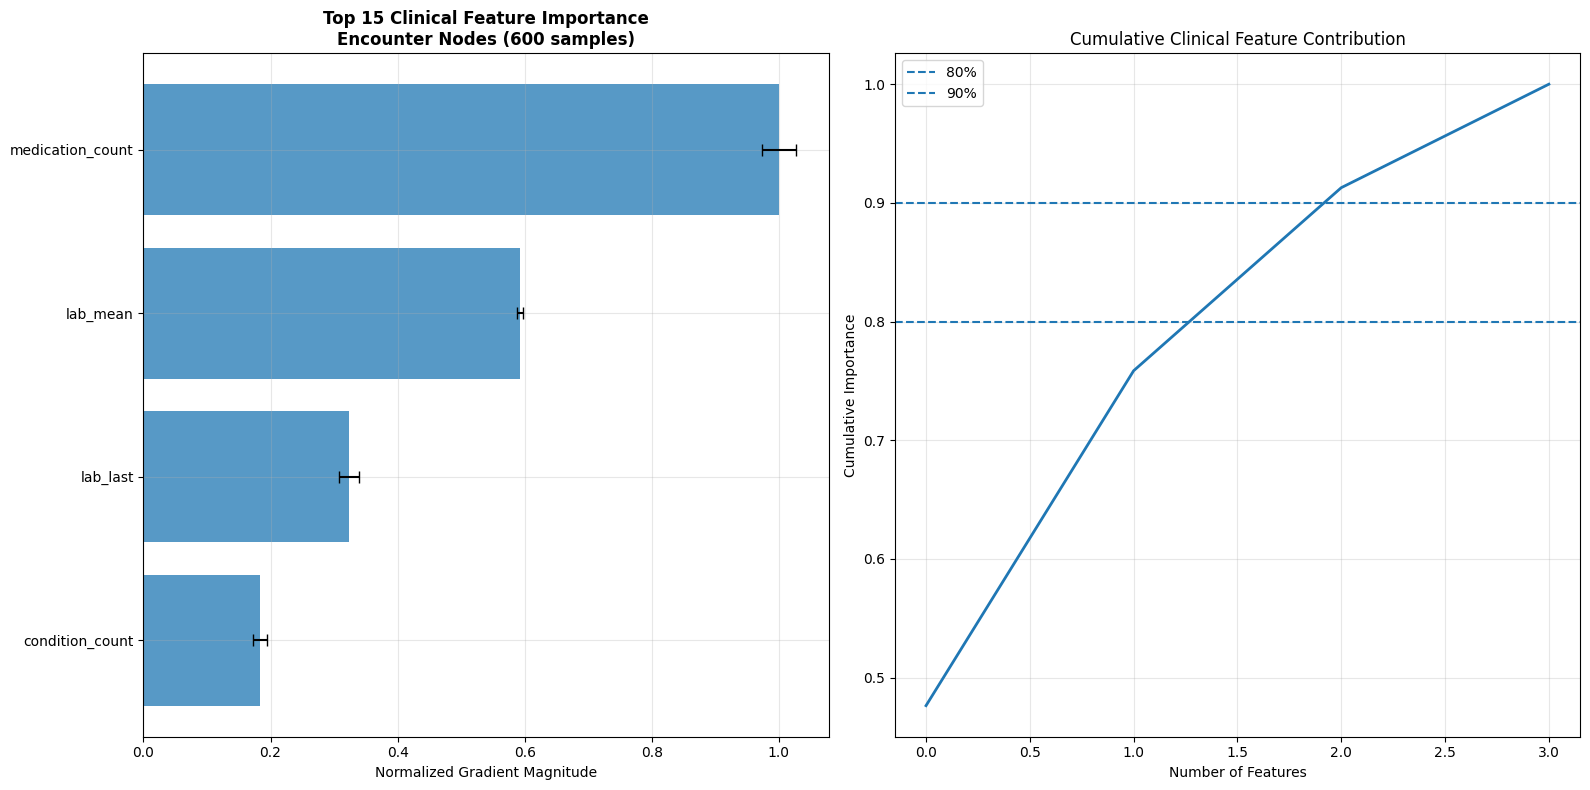


🔝 Top 10 Most Influential Clinical Features
------------------------------------------------------------
 1. medication_count          | 1.0000 ± 0.0268
 2. lab_mean                  | 0.5923 ± 0.0050
 3. lab_last                  | 0.3238 ± 0.0154
 4. condition_count           | 0.1830 ± 0.0108


In [ ]:
# =============================================================================
# RUN BATCHED GRADIENT FEATURE IMPORTANCE (EHR TGAT)
# =============================================================================

print("\n🔧 Initializing Enhanced Gradient Feature Explainer...")

feature_names = {
    "encounter": [
        "lab_mean",          # overall physiological state
        "lab_last",          # most recent clinical signal
        "condition_count",   # disease burden
        "medication_count"   # treatment intensity
    ]
}

enhanced_gradient_explainer = EnhancedGradientFeatureExplainer(
    model=model,     # TemporalHGT
    graph_data=data, # HeteroData
    feature_names=feature_names
)

print("\n📊 Analyzing ENCOUNTER features with batch processing...")
print("=" * 60)

mean_imp_enc, std_imp_enc = enhanced_gradient_explainer.explain_features_batched(
    node_type="encounter",
    total_samples=600,
    batch_size=200
)

if mean_imp_enc is not None:
    enhanced_gradient_explainer.plot_feature_importance(
        node_type="encounter",
        mean_importance=mean_imp_enc,
        std_importance=std_imp_enc,
        num_samples=600
    )
else:
    print("⚠️ Feature importance computation failed")



📊 VISIT-LEVEL FEATURE CORRELATION MATRIX
                  lab_mean  lab_last  condition_count  medication_count  \
lab_mean          1.000000  0.224117         0.010792          0.035968   
lab_last          0.224117  1.000000         0.063583         -0.139248   
condition_count   0.010792  0.063583         1.000000         -0.056566   
medication_count  0.035968 -0.139248        -0.056566          1.000000   
visit_time_days   0.117299 -0.115490        -0.015255         -0.140627   

                  visit_time_days  
lab_mean                 0.117299  
lab_last                -0.115490  
condition_count         -0.015255  
medication_count        -0.140627  
visit_time_days          1.000000  


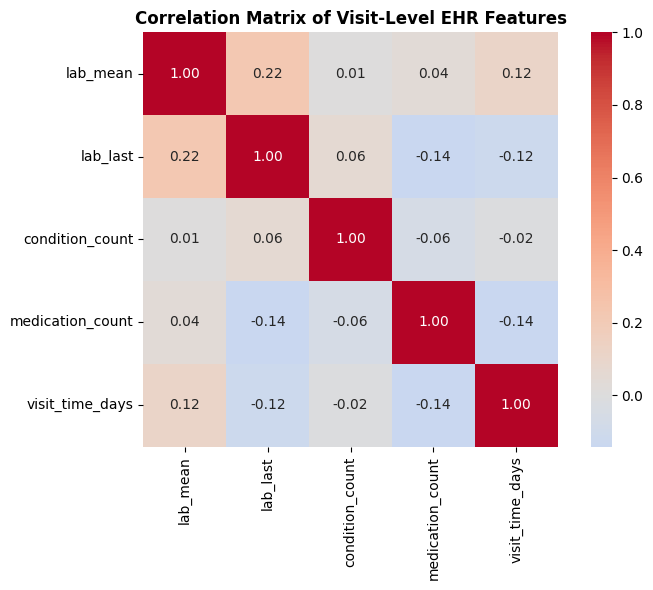

In [ ]:
# ============================================================
# CORRELATION MATRIX — VISIT-LEVEL MODEL FEATURES
# (What the GNN actually uses)
# ============================================================

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Build DataFrame from visit-level features
visit_feature_df = pd.DataFrame(
    visit_x.cpu().numpy(),
    columns=[
        "lab_mean",
        "lab_last",
        "condition_count",
        "medication_count"
    ]
)

# Add temporal feature
visit_feature_df["visit_time_days"] = visit_times.cpu().numpy()

print("\n📊 VISIT-LEVEL FEATURE CORRELATION MATRIX")
print("=" * 70)

# Compute correlation
corr_matrix = visit_feature_df.corr()

print(corr_matrix)

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap="coolwarm",
    center=0,
    fmt=".2f",
    square=True
)
plt.title("Correlation Matrix of Visit-Level EHR Features", fontweight="bold")
plt.tight_layout()
plt.show()



📊 RAW EHR AGGREGATED FEATURE CORRELATION MATRIX (VALUE-MAPPED)
✅ Raw feature matrix shape: (53346, 8)

📌 Correlation Matrix (Numeric Values):
                     BASE_ENCOUNTER_COST  TOTAL_CLAIM_COST  PAYER_COVERAGE  \
BASE_ENCOUNTER_COST                1.000             1.000           0.111   
TOTAL_CLAIM_COST                   1.000             1.000           0.111   
PAYER_COVERAGE                     0.111             0.111           1.000   
obs_mean                           0.138             0.138           0.147   
obs_std                            0.045             0.045           0.383   
obs_max                            0.060             0.060           0.307   
condition_count                   -0.078            -0.078          -0.053   
medication_count                   0.012             0.012           0.067   

                     obs_mean  obs_std  obs_max  condition_count  \
BASE_ENCOUNTER_COST     0.138    0.045    0.060           -0.078   
TOTAL_CLAIM_COST  

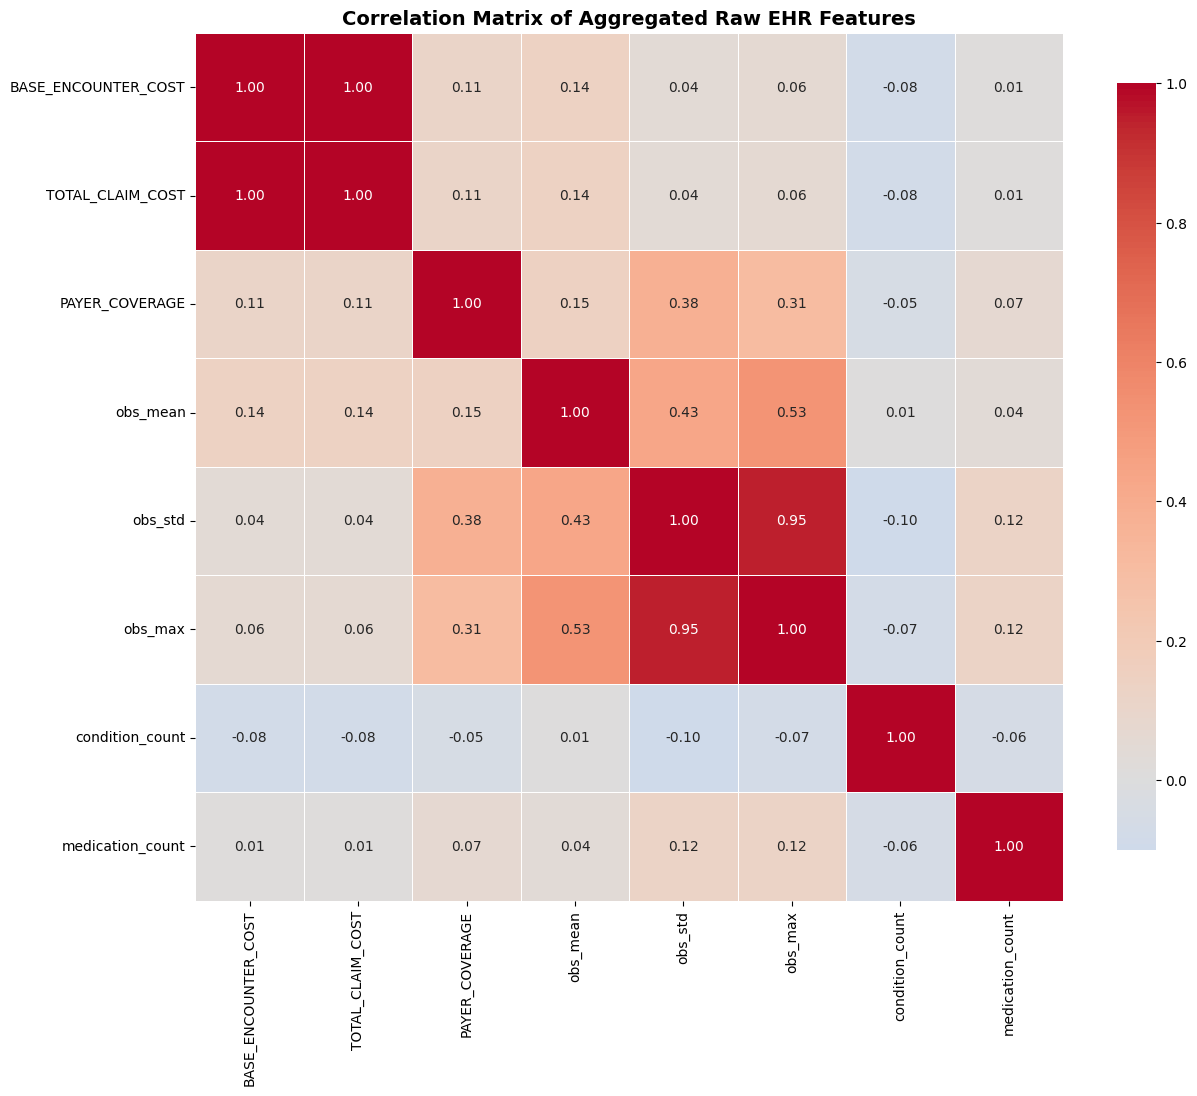

In [ ]:
# ============================================================
# CORRELATION MATRIX — RAW EHR DATA (AGGREGATED PER ENCOUNTER)
# Values mapped inside matrix cells
# ============================================================

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

print("\n📊 RAW EHR AGGREGATED FEATURE CORRELATION MATRIX (VALUE-MAPPED)")
print("=" * 75)

# ------------------------------------------------------------
# Aggregate observations
# ------------------------------------------------------------
obs_agg = obs_numeric.groupby("ENCOUNTER")["VALUE_NORM"].agg(
    obs_mean="mean",
    obs_std="std",
    obs_max="max"
)

# ------------------------------------------------------------
# Aggregate conditions
# ------------------------------------------------------------
cond_agg = conditions.groupby("ENCOUNTER").size().rename("condition_count")

# ------------------------------------------------------------
# Aggregate medications
# ------------------------------------------------------------
med_agg = medications.groupby("ENCOUNTER").size().rename("medication_count")

# ------------------------------------------------------------
# Aggregate encounter costs
# ------------------------------------------------------------
enc_costs = encounters.set_index("Id")[[
    "BASE_ENCOUNTER_COST",
    "TOTAL_CLAIM_COST",
    "PAYER_COVERAGE"
]]

# ------------------------------------------------------------
# Combine all raw features into one matrix
# ------------------------------------------------------------
raw_feature_df = (
    enc_costs
    .join(obs_agg, how="left")
    .join(cond_agg, how="left")
    .join(med_agg, how="left")
)

# Fill missing values safely
raw_feature_df = raw_feature_df.fillna(0)

print(f"✅ Raw feature matrix shape: {raw_feature_df.shape}")

# ------------------------------------------------------------
# Compute correlation matrix
# ------------------------------------------------------------
raw_corr = raw_feature_df.corr()

print("\n📌 Correlation Matrix (Numeric Values):")
print(raw_corr.round(3))

# ------------------------------------------------------------
# Plot heatmap WITH VALUES IN CELLS
# ------------------------------------------------------------
plt.figure(figsize=(13, 11))

sns.heatmap(
    raw_corr,
    annot=True,          # 🔑 show values inside cells
    fmt=".2f",           # 🔑 two decimal formatting
    cmap="coolwarm",
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.85}
)

plt.title(
    "Correlation Matrix of Aggregated Raw EHR Features",
    fontsize=14,
    fontweight="bold"
)

plt.tight_layout()
plt.show()
